# Conclusion

Decision tree classification with kfolds=5, random undersampled, and pruned parameter values found with `RandomizedSearchCV`.

Worse results than guessing.


In [1]:
## Make width of notebook 100%
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false; // disable scrollable frames
}

<IPython.core.display.Javascript object>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append('../../')
from datasets import data as Local ## Local module to get dataframes

from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split

In [4]:
games_df, winners_df, greater_fgp_df, greater_fg3_df, greater_ft_df, greater_ast_df, greater_reb_df, cumulative_stats_df, games_details_df, teams_df, players_df, ranking_df = \
    Local.get_all_dataset_dataframes('../../datasets/')

# Target datasets

- Home has:
    - 59.1% Winrate
    - 55.0% Rate of Higher FGP
    - 50.8% Rate of Higher FG3
    - 49.5% Rate of Higher FTP
    - 55.0% Rate of Higher AST
    - 53.4% Rate of Higher REB

In [5]:
winners_df # Whether the home team won in a game in each row of `games_df`

16157    1
16156    1
16155    1
16154    1
16153    1
        ..
4        0
3        0
2        0
1        1
0        1
Name: HOME_TEAM_WINS, Length: 23520, dtype: int64

In [6]:
winners_df.describe()

count    23520.000000
mean         0.591029
std          0.491654
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: HOME_TEAM_WINS, dtype: float64

In [7]:
greater_fgp_df.describe()

count    23520.000000
mean         0.550468
std          0.497457
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: HOME_HIGHER_FG_PCT, dtype: float64

In [8]:
greater_fg3_df.describe()

count    23520.000000
mean         0.507993
std          0.499947
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: HOME_HIGHER_FG3_PCT, dtype: float64

In [9]:
greater_ft_df.describe()

count    23520.000000
mean         0.494855
std          0.499984
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: HOME_HIGHER_FT_PCT, dtype: float64

In [10]:
greater_ast_df.describe()

count    23520.000000
mean         0.550128
std          0.497491
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: HOME_HIGHER_AST, dtype: float64

In [11]:
greater_reb_df.describe()

count    23520.000000
mean         0.533886
std          0.498861
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: HOME_HIGHER_REB, dtype: float64

# Datasets

In [12]:
games_df

GAME_DATE_EST   GAME_ID  HOME_TEAM_ID  VISITOR_TEAM_ID  SEASON  \
16157    2003-10-05  10300001    1610612762       1610612742    2003   
16156    2003-10-06  10300002    1610612763       1610612749    2003   
16155    2003-10-07  10300009    1610612758       1610612746    2003   
16154    2003-10-07  10300005    1610612757       1610612745    2003   
16153    2003-10-07  10300007    1610612748       1610612755    2003   
...             ...       ...           ...              ...     ...   
4        2020-12-18  12000040    1610612761       1610612748    2020   
3        2020-12-18  12000039    1610612754       1610612755    2020   
2        2020-12-19  12000049    1610612763       1610612737    2020   
1        2020-12-19  12000048    1610612764       1610612765    2020   
0        2020-12-19  12000047    1610612753       1610612766    2020   

       PTS_home  FG_PCT_home  FT_PCT_home  FG3_PCT_home  AST_home  REB_home  \
16157      90.0        0.457        0.735         0.143      23.0      41.0   
16156     105.0        0.494        0.618         0.267      25.0      48.0   
16155     101.0        0.467        0.871         0.444      19.0      39.0   
16154     104.0        0.527        0.657         0.429      22.0      33.0   
16153      86.0        0.352        0.647         0.222      15.0      55.0   
...         ...          ...          ...           ...       ...       ...   
4         105.0        0.380        0.737         0.356      27.0      37.0   
3         107.0        0.371        0.692         0.262      19.0      45.0   
2         116.0        0.400        0.744         0.396      21.0      43.0   
1          99.0        0.427        0.625         0.295      24.0      45.0   
0         120.0        0.433        0.792         0.425      23.0      50.0   

       PTS_away  FG_PCT_away  FT_PCT_away  FG3_PCT_away  AST_away  REB_away  
16157      85.0        0.447        0.500         0.250      20.0      38.0  
16156      94.0        0.427        0.700         0.154      20.0      43.0  
16155      82.0        0.368        0.609         0.364      13.0      50.0  
16154      80.0        0.470        0.667         0.333      10.0      37.0  
16153      79.0        0.329        0.897         0.143       7.0      44.0  
...         ...          ...          ...           ...       ...       ...  
4         117.0        0.534        0.741         0.514      30.0      51.0  
3         113.0        0.533        0.629         0.355      23.0      48.0  
2         117.0        0.422        0.837         0.297      24.0      47.0  
1          96.0        0.402        0.647         0.326      18.0      51.0  
0         117.0        0.444        0.864         0.439      21.0      52.0  

[23520 rows x 17 columns]

In [13]:
cumulative_stats_df

DATE   GAME_ID  SEASON_TYPE  SEASON  GAMES_PLAYED_home  \
0      2003-10-05  10300001            1    2003                  0   
1      2003-10-06  10300002            1    2003                  0   
2      2003-10-07  10300009            1    2003                  0   
3      2003-10-07  10300005            1    2003                  0   
4      2003-10-07  10300007            1    2003                  0   
...           ...       ...          ...     ...                ...   
23515  2020-12-18  12000040            1    2020                  2   
23516  2020-12-18  12000039            1    2020                  2   
23517  2020-12-19  12000049            1    2020                  3   
23518  2020-12-19  12000048            1    2020                  2   
23519  2020-12-19  12000047            1    2020                  3   

       GAMES_PLAYED_away  PPG_total_home  FG_PCT_total_home  \
0                      0        0.000000           0.000000   
1                      0        0.000000           0.000000   
2                      0        0.000000           0.000000   
3                      0        0.000000           0.000000   
4                      0        0.000000           0.000000   
...                  ...             ...                ...   
23515                  1      111.500000           0.443500   
23516                  1      105.000000           0.438000   
23517                  3      119.333333           0.466667   
23518                  3      100.000000           0.415000   
23519                  3      112.666667           0.444333   

       FG3_PCT_total_home  FT_PCT_total_home  ...  PPG_total_away  \
0                0.000000           0.000000  ...        0.000000   
1                0.000000           0.000000  ...        0.000000   
2                0.000000           0.000000  ...        0.000000   
3                0.000000           0.000000  ...        0.000000   
4                0.000000           0.000000  ...        0.000000   
...                   ...                ...  ...             ...   
23515            0.353000           0.691000  ...       92.000000   
23516            0.383000           0.619000  ...      108.000000   
23517            0.329333           0.704667  ...      111.333333   
23518            0.321500           0.704500  ...       93.333333   
23519            0.305333           0.758000  ...      110.666667   

       FG_PCT_total_away  FG3_PCT_total_away  FT_PCT_total_away  \
0               0.000000            0.000000           0.000000   
1               0.000000            0.000000           0.000000   
2               0.000000            0.000000           0.000000   
3               0.000000            0.000000           0.000000   
4               0.000000            0.000000           0.000000   
...                  ...                 ...                ...   
23515           0.427000            0.283000           0.818000   
23516           0.471000            0.241000           0.750000   
23517           0.392667            0.332333           0.789667   
23518           0.413333            0.333000           0.713000   
23519           0.442333            0.372333           0.751000   

       APG_total_away  RPG_total_away  TEAM_ID_away  TEAM_ID_home  W_PCT_away  \
0            0.000000        0.000000  1.610613e+09  1.610613e+09    0.000000   
1            0.000000        0.000000  1.610613e+09  1.610613e+09    0.000000   
2            0.000000        0.000000  1.610613e+09  1.610613e+09    0.000000   
3            0.000000        0.000000  1.610613e+09  1.610613e+09    0.000000   
4            0.000000        0.000000  1.610613e+09  1.610613e+09    0.000000   
...               ...             ...           ...           ...         ...   
23515       26.000000       35.000000  1.610613e+09  1.610613e+09    0.000000   
23516       23.000000       42.000000  1.610613e+09  1.610613e+09    1.000000   
23517       24.000000       56.000000  1

## Attach target columns to dataset

In [14]:
cumulative_stats_copy_df = cumulative_stats_df.copy()
cumulative_stats_copy_df['home_win'] = winners_df
cumulative_stats_copy_df['greater_fgp'] = greater_fgp_df
cumulative_stats_copy_df['greater_fg3'] = greater_fg3_df
cumulative_stats_copy_df['greater_ft'] = greater_ft_df
cumulative_stats_copy_df['greater_ast'] = greater_ast_df
cumulative_stats_copy_df['greater_reb'] = greater_reb_df

## Remove rows w/o data

In [15]:
cumulative_stats_copy_df = cumulative_stats_copy_df[(cumulative_stats_copy_df['GAMES_PLAYED_home']>0) & (cumulative_stats_copy_df['GAMES_PLAYED_away']>0)]

# Get new target datasets after row removal
winners_df = cumulative_stats_copy_df['home_win']
greater_fgp_df = cumulative_stats_copy_df['greater_fgp']
greater_fg3_df = cumulative_stats_copy_df['greater_fg3']
greater_ft_df = cumulative_stats_copy_df['greater_ft']
greater_ast_df = cumulative_stats_copy_df['greater_ast']
greater_reb_df = cumulative_stats_copy_df['greater_reb']

## Remove non-data

In [16]:
# Delete non-data
for key in [
    'DATE','GAME_ID','TEAM_ID_home','TEAM_ID_away','SEASON_TYPE','SEASON','GAMES_PLAYED_home','GAMES_PLAYED_away',
    'home_win','greater_fgp','greater_fg3','greater_ft','greater_ast','greater_reb'
]:
    del cumulative_stats_copy_df[key]
# Only look at home teams
# cumulative_stats_copy_df = cumulative_stats_copy_df.loc[cumulative_stats_copy_df['AT_HOME']==True]
# del cumulative_stats_copy_df['AT_HOME']
cumulative_stats_copy_df

PPG_total_home  FG_PCT_total_home  FG3_PCT_total_home  \
19         104.000000           0.527000            0.429000   
21          86.000000           0.380000            0.188000   
22          86.000000           0.352000            0.222000   
23          58.000000           0.457000            0.667000   
24          87.500000           0.432000            0.420000   
...               ...                ...                 ...   
23515      111.500000           0.443500            0.353000   
23516      105.000000           0.438000            0.383000   
23517      119.333333           0.466667            0.329333   
23518      100.000000           0.415000            0.321500   
23519      112.666667           0.444333            0.305333   

       FT_PCT_total_home  APG_total_home  RPG_total_home  PPG_total_away  \
19              0.657000       22.000000       33.000000      101.000000   
21              0.852000       19.000000       37.000000      101.000000   
22              0.647000       15.000000       55.000000       80.000000   
23              0.700000       10.000000       31.000000       89.000000   
24              0.672000       20.500000       43.000000       79.000000   
...                  ...             ...             ...             ...   
23515           0.691000       25.000000       41.500000       92.000000   
23516           0.619000       26.000000       35.500000      108.000000   
23517           0.704667       30.666667       52.666667      111.333333   
23518           0.704500       22.000000       44.500000       93.333333   
23519           0.758000       25.000000       51.333333      110.666667   

       FG_PCT_total_away  FG3_PCT_total_away  FT_PCT_total_away  \
19              0.467000            0.444000           0.871000   
21              0.464000            0.250000           0.679000   
22              0.350000            0.429000           0.750000   
23              0.462000            0.214000           0.538000   
24              0.329000            0.143000           0.897000   
...                  ...                 ...                ...   
23515           0.427000            0.283000           0.818000   
23516           0.471000            0.241000           0.750000   
23517           0.392667            0.332333           0.789667   
23518           0.413333            0.333000           0.713000   
23519           0.442333            0.372333           0.751000   

       APG_total_away  RPG_total_away  W_PCT_away  W_PCT_home  
19          19.000000       39.000000    1.000000    1.000000  
21          22.000000       47.000000    1.000000    0.000000  
22          18.000000       45.000000    0.000000    1.000000  
23          21.000000       36.000000    0.000000    0.000000  
24           7.000000       44.000000    0.000000    0.500000  
...               ...             ...         ...         ...  
23515       26.000000       35.000000    0.000000    1.000000  
23516       23.000000       42.000000    1.000000    0.000000  
23517       24.000000       56.000000    0.333333    1.000000  
23518       20.000000       41.666667    0.666667    0.000000  
23519       29.666667       45.000000    0.333333    0.333333  

[23147 rows x 14 columns]

## Do hyperparameters searches

In [17]:
from sklearn.metrics import classification_report

In [18]:
from sklearn.tree import plot_tree
from yellowbrick.model_selection import FeatureImportances

In [19]:
from sklearn.utils.class_weight import compute_sample_weight

In [20]:
# Get best params based from CV function
def do_cv(classifier, cv_fun, params, x, y, **kwargs):
    clf = cv_fun(
        classifier,
        params,
        scoring='accuracy', # Optimize for the 'accuracy' score of the model.
        **kwargs,
    )
#     clf.fit(x, y, sample_weight=compute_sample_weight('balanced',y))
    clf.fit(x, y)
    return clf

## Plot feature importances

In [21]:
def plot_feature_importances(clf, X, y):
    viz = FeatureImportances(clf, labels=X.columns)
    viz.fit(X, y)
    viz.show()

In [22]:
def print_all_metrics_and_plot(clf, X_train_dict, X_test_dict, y_train_dict, y_test_dict, grid_cv_params):
    scores = []
    for key in X_train_dict.keys():
        cv_clf = do_cv(
            clf,
#             GridSearchCV,
            RandomizedSearchCV,
            grid_cv_params,
            X_train_dict[key],
            y_train_dict[key],
        )
        print(key.upper()+':\n')
        score = cv_clf.best_estimator_.score(X_test_dict[key], y_test_dict[key])
        scores.append(score)
        print('Best decision tree accuracy (%s): %.2f' % (str(cv_clf.best_params_), score))
        print(classification_report(y_test_dict[key], cv_clf.best_estimator_.predict(X_test_dict[key])))
        plot_feature_importances(cv_clf.best_estimator_, X_train_dict[key], y_train_dict[key])
        print('---------------------------------------------')
    return scores

## Build K-folds datasets

In [23]:
from imblearn.under_sampling import RandomUnderSampler

In [24]:
from sklearn.model_selection import KFold
kf = KFold(shuffle=True, random_state=123)

X_train_dicts = []
X_test_dicts = []
y_train_dicts = []
y_test_dicts = []

for target, key in [(winners_df, 'winner'), (greater_fgp_df, 'fgp'), (greater_fg3_df, 'fg3'), (greater_ft_df, 'ft'), (greater_ast_df, 'ast'), (greater_reb_df, 'reb')]:
    X_over, y_over = RandomUnderSampler(sampling_strategy='majority').fit_resample(cumulative_stats_copy_df, target)
    for train, test in kf.split(X_over, y_over):
        X_train_dict = {}
        X_test_dict = {}
        y_train_dict = {}
        y_test_dict = {}
        
        X_train_dict[key], X_test_dict[key] = X_over.iloc[train], X_over.iloc[test]
        y_train_dict[key], y_test_dict[key] = y_over.iloc[train], y_over.iloc[test]
        
        X_train_dicts.append(X_train_dict)
        X_test_dicts.append(X_test_dict)
        y_train_dicts.append(y_train_dict)
        y_test_dicts.append(y_test_dict)

assert len(X_train_dicts)==len(X_test_dicts)==len(y_train_dicts)==len(y_test_dicts)
print(len(X_train_dicts))

30


In [25]:
def print_cross_validated_and_plot(X_train_dicts, X_test_dicts, y_train_dicts, y_test_dicts, params):
    scores=[]
    for i in range(len(X_train_dicts)):
        print(f'i={i}')
        score = print_all_metrics_and_plot(
            DecisionTreeClassifier(random_state=0),
            X_train_dicts[i],
            X_test_dicts[i],
            y_train_dicts[i],
            y_test_dicts[i],
            params,
        )
        if (i+1)%5==0:
            scores = pd.DataFrame(np.array(scores))
            print(f'Mean accuracy: {scores.mean()[0]}')
            print(f'Max accuracy: {scores.max()[0]}')
            print(f'Min accuracy: {scores.min()[0]}')
            print('=========================================')
            scores=[]
        else:
            scores += score

## Train decision tree w/o pruning

i=0


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


WINNER:

Best decision tree accuracy ({'criterion': 'gini'}): 0.50
              precision    recall  f1-score   support

           0       0.50      0.49      0.49      1916
           1       0.49      0.51      0.50      1860

    accuracy                           0.50      3776
   macro avg       0.50      0.50      0.50      3776
weighted avg       0.50      0.50      0.50      3776



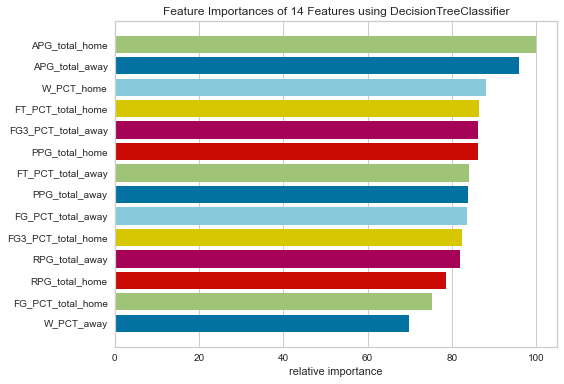

---------------------------------------------
i=1


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


WINNER:

Best decision tree accuracy ({'criterion': 'entropy'}): 0.50
              precision    recall  f1-score   support

           0       0.50      0.51      0.51      1860
           1       0.51      0.50      0.50      1915

    accuracy                           0.50      3775
   macro avg       0.50      0.50      0.50      3775
weighted avg       0.50      0.50      0.50      3775



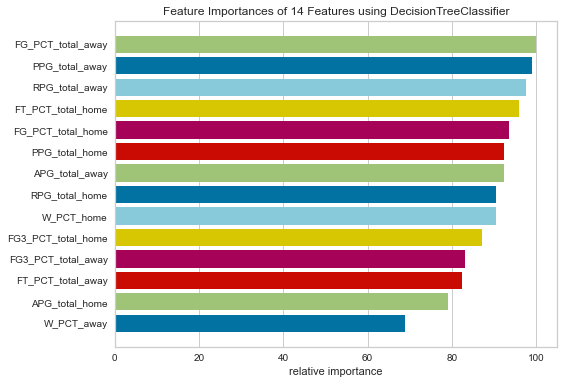

---------------------------------------------
i=2


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


WINNER:

Best decision tree accuracy ({'criterion': 'gini'}): 0.50
              precision    recall  f1-score   support

           0       0.50      0.48      0.49      1913
           1       0.49      0.51      0.50      1862

    accuracy                           0.50      3775
   macro avg       0.50      0.50      0.50      3775
weighted avg       0.50      0.50      0.50      3775



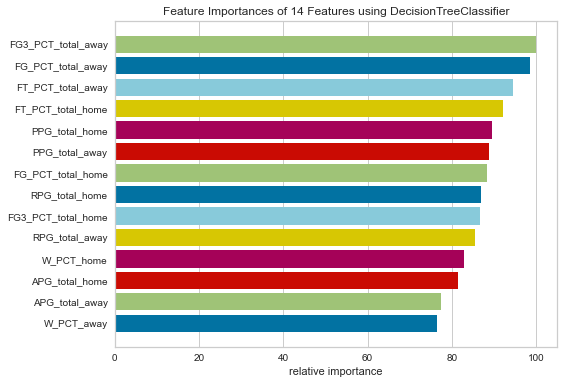

---------------------------------------------
i=3


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


WINNER:

Best decision tree accuracy ({'criterion': 'gini'}): 0.50
              precision    recall  f1-score   support

           0       0.50      0.48      0.49      1904
           1       0.50      0.51      0.50      1871

    accuracy                           0.50      3775
   macro avg       0.50      0.50      0.50      3775
weighted avg       0.50      0.50      0.50      3775



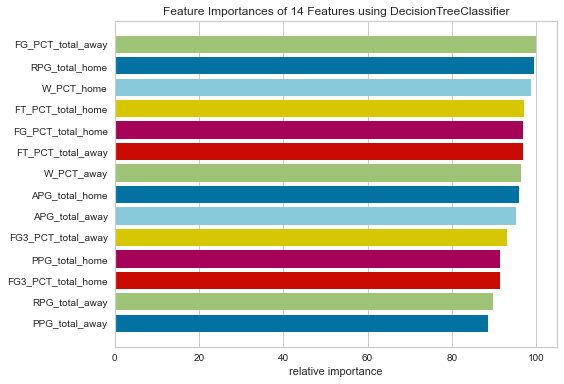

---------------------------------------------
i=4


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


WINNER:

Best decision tree accuracy ({'criterion': 'gini'}): 0.50
              precision    recall  f1-score   support

           0       0.49      0.52      0.50      1845
           1       0.51      0.49      0.50      1930

    accuracy                           0.50      3775
   macro avg       0.50      0.50      0.50      3775
weighted avg       0.50      0.50      0.50      3775



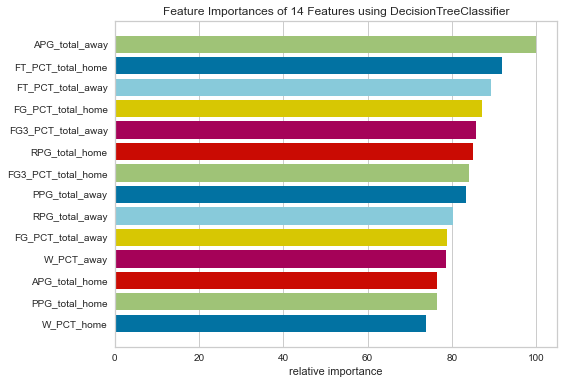

---------------------------------------------
Mean accuracy: 0.49923867367269054
Max accuracy: 0.5046357615894039
Min accuracy: 0.4960275423728814
i=5


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


FGP:

Best decision tree accuracy ({'criterion': 'gini'}): 0.49
              precision    recall  f1-score   support

           0       0.47      0.50      0.48      2005
           1       0.51      0.49      0.50      2146

    accuracy                           0.49      4151
   macro avg       0.49      0.49      0.49      4151
weighted avg       0.49      0.49      0.49      4151



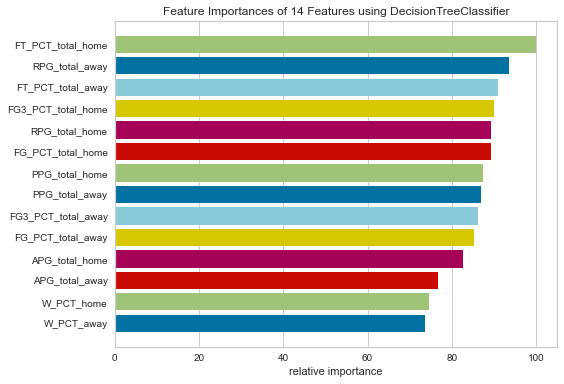

---------------------------------------------
i=6


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


FGP:

Best decision tree accuracy ({'criterion': 'gini'}): 0.50
              precision    recall  f1-score   support

           0       0.51      0.49      0.50      2127
           1       0.49      0.51      0.50      2024

    accuracy                           0.50      4151
   macro avg       0.50      0.50      0.50      4151
weighted avg       0.50      0.50      0.50      4151



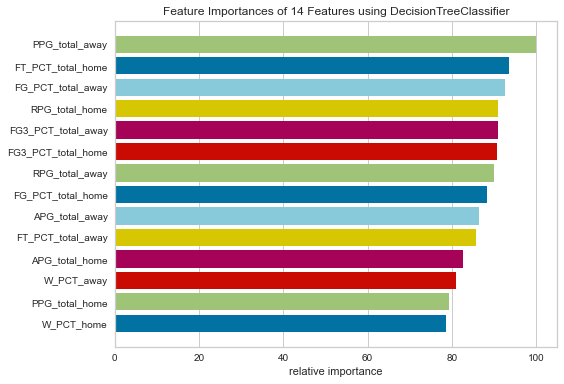

---------------------------------------------
i=7


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


FGP:

Best decision tree accuracy ({'criterion': 'entropy'}): 0.50
              precision    recall  f1-score   support

           0       0.51      0.49      0.50      2125
           1       0.48      0.51      0.49      2025

    accuracy                           0.50      4150
   macro avg       0.50      0.50      0.50      4150
weighted avg       0.50      0.50      0.50      4150



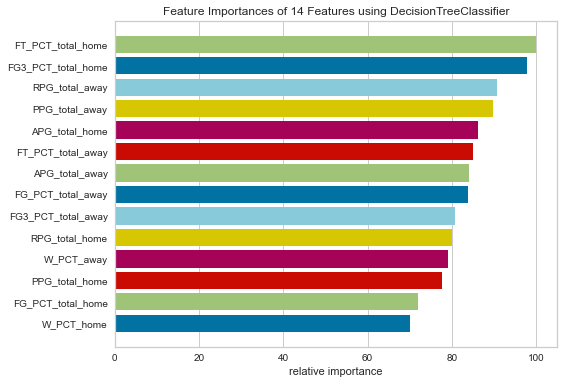

---------------------------------------------
i=8


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


FGP:

Best decision tree accuracy ({'criterion': 'entropy'}): 0.50
              precision    recall  f1-score   support

           0       0.50      0.51      0.51      2078
           1       0.50      0.49      0.49      2072

    accuracy                           0.50      4150
   macro avg       0.50      0.50      0.50      4150
weighted avg       0.50      0.50      0.50      4150



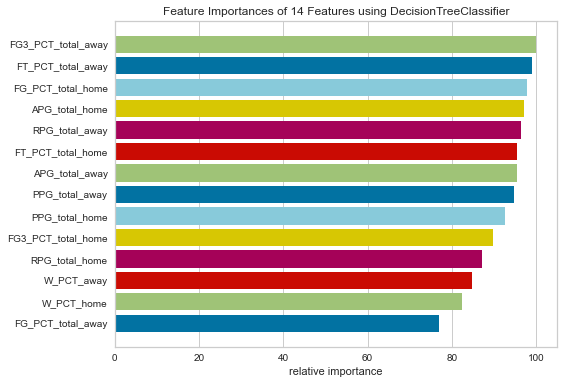

---------------------------------------------
i=9


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


FGP:

Best decision tree accuracy ({'criterion': 'gini'}): 0.50
              precision    recall  f1-score   support

           0       0.49      0.51      0.50      2041
           1       0.51      0.49      0.49      2109

    accuracy                           0.50      4150
   macro avg       0.50      0.50      0.50      4150
weighted avg       0.50      0.50      0.50      4150



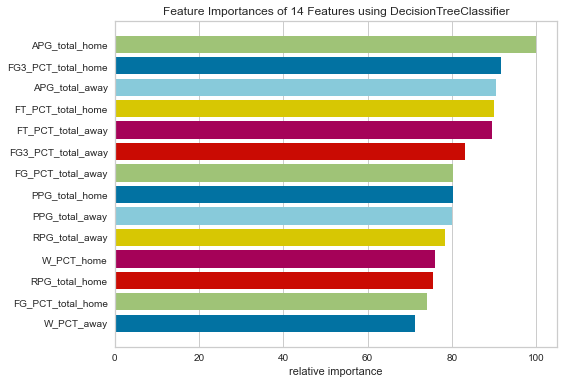

---------------------------------------------
Mean accuracy: 0.4969282332896994
Max accuracy: 0.5013249819320645
Min accuracy: 0.4900024090580583
i=10


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


FG3:

Best decision tree accuracy ({'criterion': 'gini'}): 0.50
              precision    recall  f1-score   support

           0       0.49      0.51      0.50      2252
           1       0.50      0.48      0.49      2296

    accuracy                           0.50      4548
   macro avg       0.50      0.50      0.50      4548
weighted avg       0.50      0.50      0.50      4548



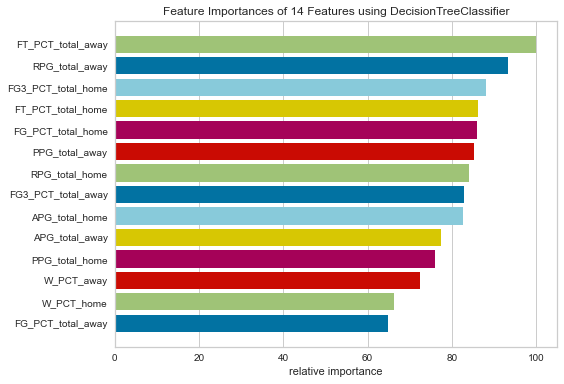

---------------------------------------------
i=11


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


FG3:

Best decision tree accuracy ({'criterion': 'gini'}): 0.50
              precision    recall  f1-score   support

           0       0.49      0.49      0.49      2257
           1       0.50      0.50      0.50      2291

    accuracy                           0.50      4548
   macro avg       0.50      0.50      0.50      4548
weighted avg       0.50      0.50      0.50      4548



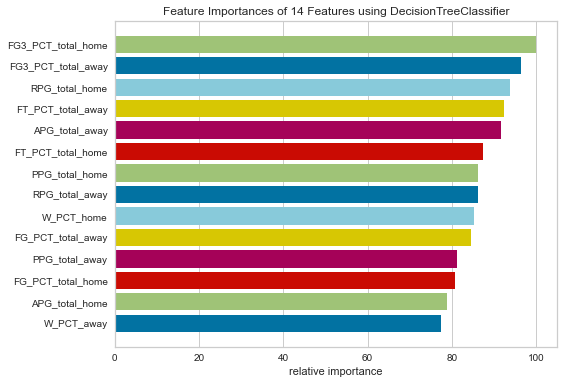

---------------------------------------------
i=12


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


FG3:

Best decision tree accuracy ({'criterion': 'gini'}): 0.50
              precision    recall  f1-score   support

           0       0.51      0.49      0.50      2321
           1       0.49      0.51      0.50      2227

    accuracy                           0.50      4548
   macro avg       0.50      0.50      0.50      4548
weighted avg       0.50      0.50      0.50      4548



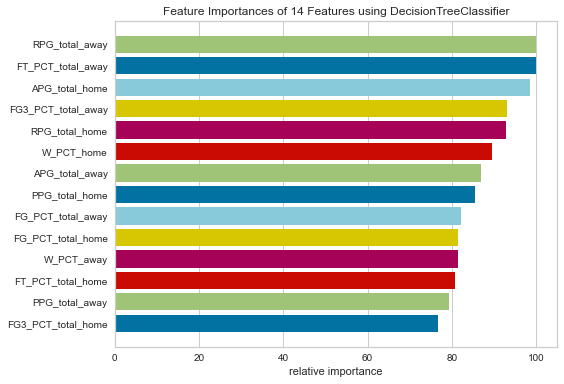

---------------------------------------------
i=13


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


FG3:

Best decision tree accuracy ({'criterion': 'gini'}): 0.48
              precision    recall  f1-score   support

           0       0.49      0.48      0.48      2312
           1       0.47      0.48      0.48      2236

    accuracy                           0.48      4548
   macro avg       0.48      0.48      0.48      4548
weighted avg       0.48      0.48      0.48      4548



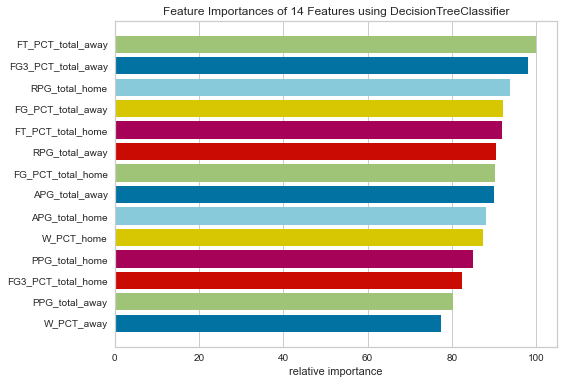

---------------------------------------------
i=14


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


FG3:

Best decision tree accuracy ({'criterion': 'gini'}): 0.50
              precision    recall  f1-score   support

           0       0.49      0.50      0.50      2228
           1       0.51      0.51      0.51      2320

    accuracy                           0.50      4548
   macro avg       0.50      0.50      0.50      4548
weighted avg       0.50      0.50      0.50      4548



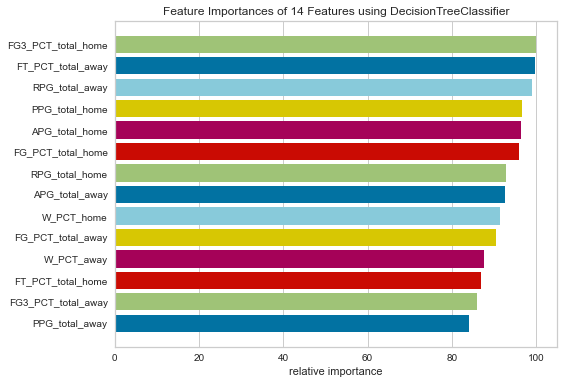

---------------------------------------------
Mean accuracy: 0.4922493403693931
Max accuracy: 0.49912049252418644
Min accuracy: 0.4793315743183817
i=15


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


FT:

Best decision tree accuracy ({'criterion': 'gini'}): 0.50
              precision    recall  f1-score   support

           0       0.49      0.50      0.50      2255
           1       0.51      0.51      0.51      2322

    accuracy                           0.50      4577
   macro avg       0.50      0.50      0.50      4577
weighted avg       0.50      0.50      0.50      4577



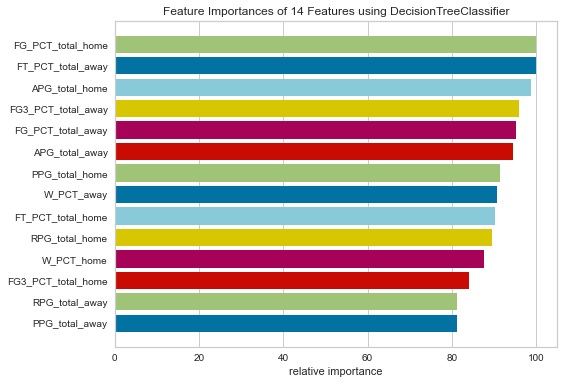

---------------------------------------------
i=16


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


FT:

Best decision tree accuracy ({'criterion': 'gini'}): 0.50
              precision    recall  f1-score   support

           0       0.50      0.51      0.50      2292
           1       0.50      0.50      0.50      2285

    accuracy                           0.50      4577
   macro avg       0.50      0.50      0.50      4577
weighted avg       0.50      0.50      0.50      4577



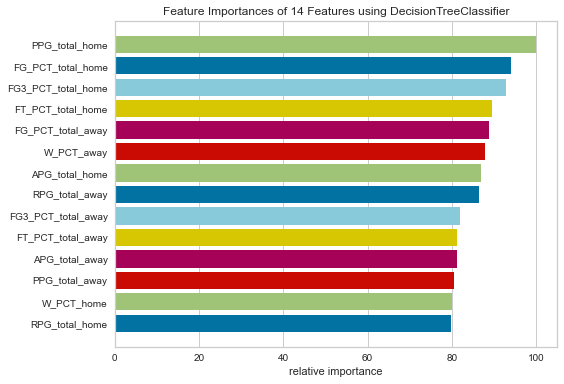

---------------------------------------------
i=17


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


FT:

Best decision tree accuracy ({'criterion': 'entropy'}): 0.51
              precision    recall  f1-score   support

           0       0.52      0.51      0.51      2322
           1       0.50      0.51      0.51      2255

    accuracy                           0.51      4577
   macro avg       0.51      0.51      0.51      4577
weighted avg       0.51      0.51      0.51      4577



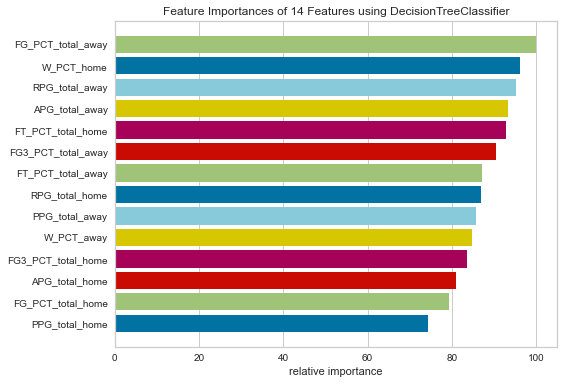

---------------------------------------------
i=18


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


FT:

Best decision tree accuracy ({'criterion': 'entropy'}): 0.50
              precision    recall  f1-score   support

           0       0.51      0.48      0.50      2330
           1       0.49      0.51      0.50      2247

    accuracy                           0.50      4577
   macro avg       0.50      0.50      0.50      4577
weighted avg       0.50      0.50      0.50      4577



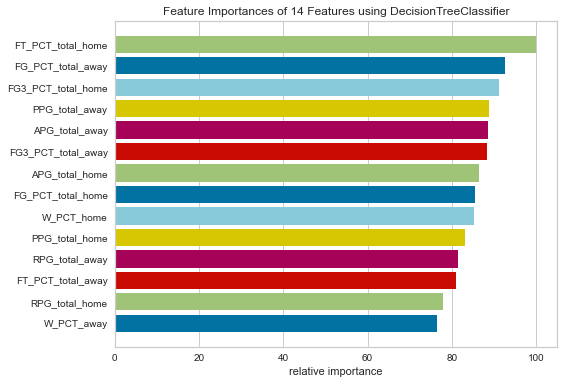

---------------------------------------------
i=19


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


FT:

Best decision tree accuracy ({'criterion': 'gini'}): 0.51
              precision    recall  f1-score   support

           0       0.50      0.52      0.51      2243
           1       0.52      0.51      0.51      2333

    accuracy                           0.51      4576
   macro avg       0.51      0.51      0.51      4576
weighted avg       0.51      0.51      0.51      4576



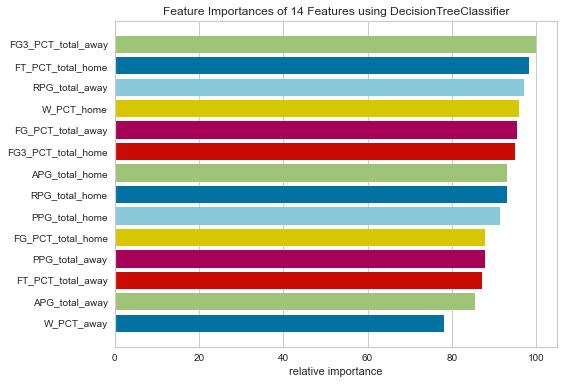

---------------------------------------------
Mean accuracy: 0.5026764256062923
Max accuracy: 0.5086301070570243
Min accuracy: 0.49792440463185494
i=20


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


AST:

Best decision tree accuracy ({'criterion': 'entropy'}): 0.50
              precision    recall  f1-score   support

           0       0.49      0.50      0.50      2048
           1       0.51      0.49      0.50      2116

    accuracy                           0.50      4164
   macro avg       0.50      0.50      0.50      4164
weighted avg       0.50      0.50      0.50      4164



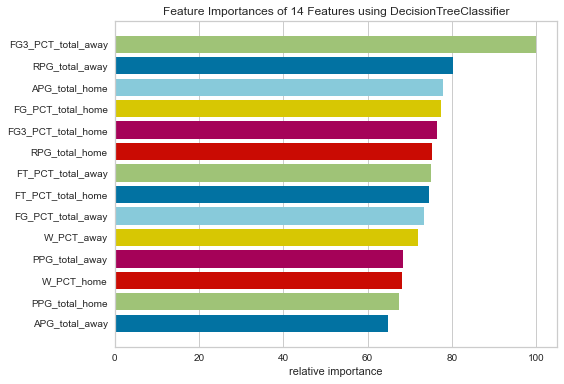

---------------------------------------------
i=21


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


AST:

Best decision tree accuracy ({'criterion': 'entropy'}): 0.49
              precision    recall  f1-score   support

           0       0.50      0.50      0.50      2096
           1       0.49      0.49      0.49      2068

    accuracy                           0.49      4164
   macro avg       0.49      0.49      0.49      4164
weighted avg       0.49      0.49      0.49      4164



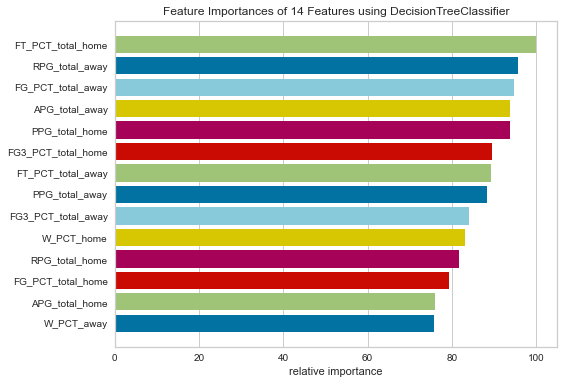

---------------------------------------------
i=22


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


AST:

Best decision tree accuracy ({'criterion': 'gini'}): 0.51
              precision    recall  f1-score   support

           0       0.53      0.50      0.52      2132
           1       0.50      0.52      0.51      2032

    accuracy                           0.51      4164
   macro avg       0.51      0.51      0.51      4164
weighted avg       0.51      0.51      0.51      4164



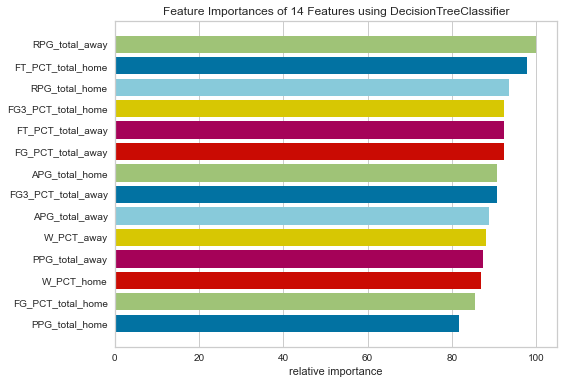

---------------------------------------------
i=23


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


AST:

Best decision tree accuracy ({'criterion': 'entropy'}): 0.50
              precision    recall  f1-score   support

           0       0.50      0.51      0.50      2087
           1       0.50      0.50      0.50      2076

    accuracy                           0.50      4163
   macro avg       0.50      0.50      0.50      4163
weighted avg       0.50      0.50      0.50      4163



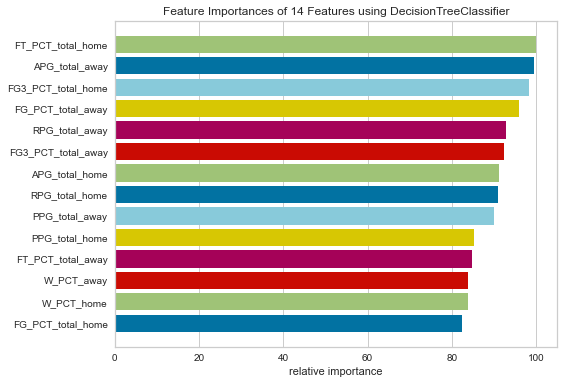

---------------------------------------------
i=24


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


AST:

Best decision tree accuracy ({'criterion': 'entropy'}): 0.51
              precision    recall  f1-score   support

           0       0.50      0.51      0.51      2046
           1       0.52      0.50      0.51      2117

    accuracy                           0.51      4163
   macro avg       0.51      0.51      0.51      4163
weighted avg       0.51      0.51      0.51      4163



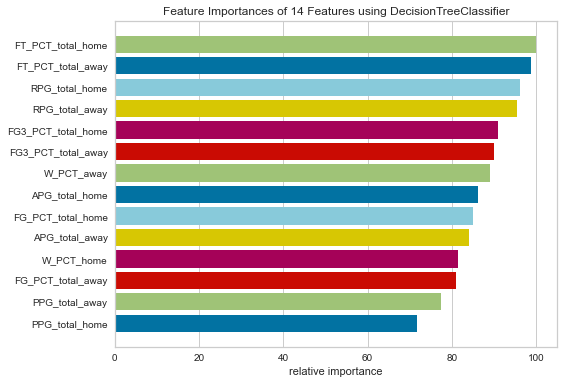

---------------------------------------------
Mean accuracy: 0.5013509006080972
Max accuracy: 0.5136887608069164
Min accuracy: 0.4942363112391931
i=25


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


REB:

Best decision tree accuracy ({'criterion': 'gini'}): 0.49
              precision    recall  f1-score   support

           0       0.48      0.49      0.49      2141
           1       0.49      0.48      0.48      2174

    accuracy                           0.49      4315
   macro avg       0.49      0.49      0.49      4315
weighted avg       0.49      0.49      0.49      4315



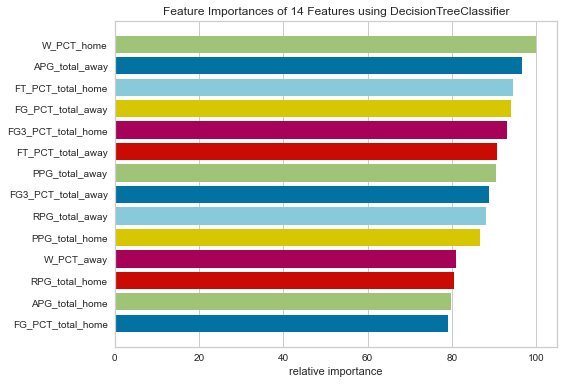

---------------------------------------------
i=26


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


REB:

Best decision tree accuracy ({'criterion': 'entropy'}): 0.48
              precision    recall  f1-score   support

           0       0.49      0.48      0.48      2163
           1       0.48      0.49      0.48      2152

    accuracy                           0.48      4315
   macro avg       0.48      0.48      0.48      4315
weighted avg       0.48      0.48      0.48      4315



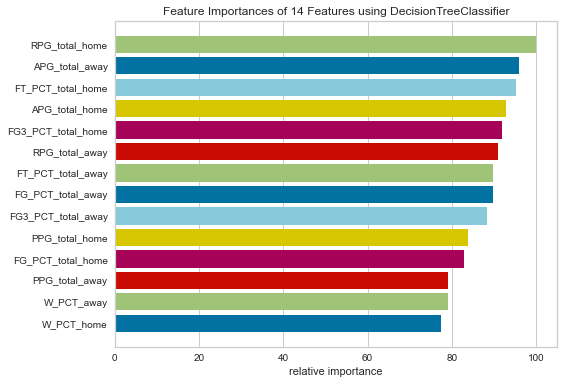

---------------------------------------------
i=27


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


REB:

Best decision tree accuracy ({'criterion': 'gini'}): 0.49
              precision    recall  f1-score   support

           0       0.49      0.49      0.49      2181
           1       0.48      0.48      0.48      2133

    accuracy                           0.49      4314
   macro avg       0.49      0.49      0.49      4314
weighted avg       0.49      0.49      0.49      4314



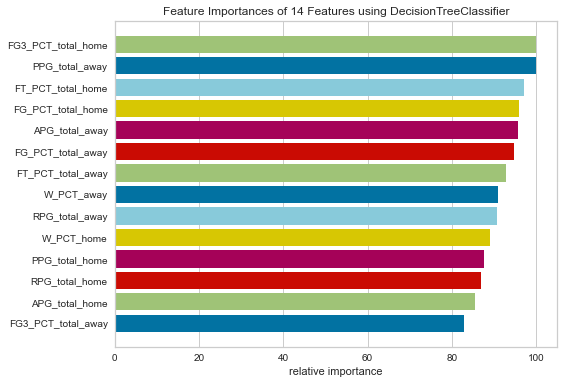

---------------------------------------------
i=28


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


REB:

Best decision tree accuracy ({'criterion': 'entropy'}): 0.52
              precision    recall  f1-score   support

           0       0.52      0.52      0.52      2182
           1       0.51      0.51      0.51      2132

    accuracy                           0.52      4314
   macro avg       0.52      0.52      0.52      4314
weighted avg       0.52      0.52      0.52      4314



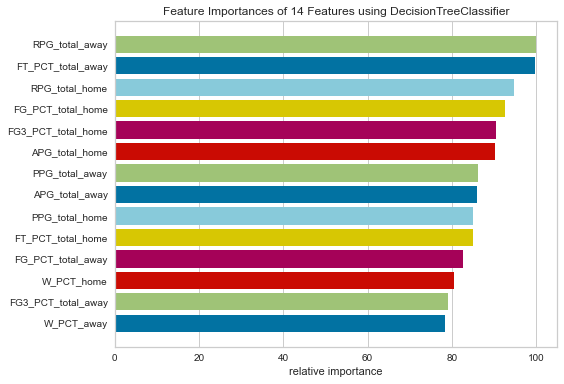

---------------------------------------------
i=29


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


REB:

Best decision tree accuracy ({'criterion': 'entropy'}): 0.49
              precision    recall  f1-score   support

           0       0.49      0.49      0.49      2119
           1       0.50      0.50      0.50      2195

    accuracy                           0.49      4314
   macro avg       0.49      0.49      0.49      4314
weighted avg       0.49      0.49      0.49      4314



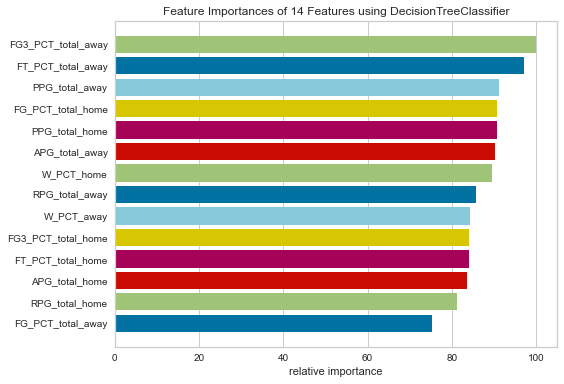

---------------------------------------------
Mean accuracy: 0.49327950014262767
Max accuracy: 0.5155308298562818
Min accuracy: 0.4838933951332561


In [26]:
print_cross_validated_and_plot(X_train_dicts, X_test_dicts, y_train_dicts, y_test_dicts, {'criterion':['gini','entropy']})

In [27]:
# plt.figure(figsize=(15,10))
# t = plot_tree(decision_tree_clf)

## Try prune max depth

i=0
WINNER:

Best decision tree accuracy ({'max_depth': 40, 'criterion': 'gini'}): 0.50
              precision    recall  f1-score   support

           0       0.50      0.49      0.50      1916
           1       0.49      0.50      0.50      1860

    accuracy                           0.50      3776
   macro avg       0.50      0.50      0.50      3776
weighted avg       0.50      0.50      0.50      3776



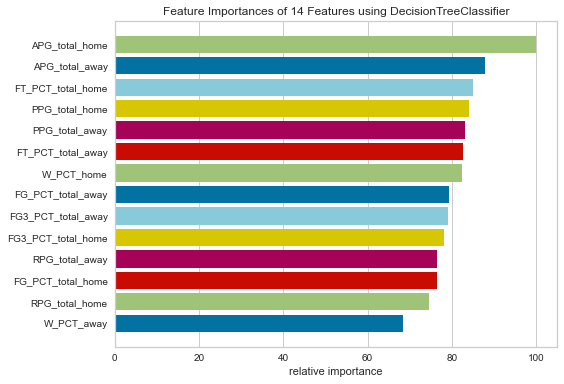

---------------------------------------------
i=1
WINNER:

Best decision tree accuracy ({'max_depth': 57, 'criterion': 'entropy'}): 0.50
              precision    recall  f1-score   support

           0       0.49      0.50      0.50      1860
           1       0.51      0.49      0.50      1915

    accuracy                           0.50      3775
   macro avg       0.50      0.50      0.50      3775
weighted avg       0.50      0.50      0.50      3775



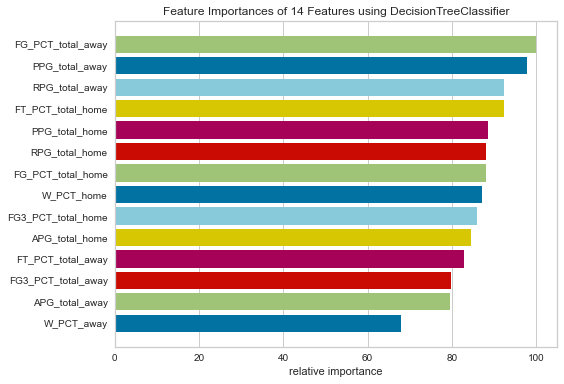

---------------------------------------------
i=2
WINNER:

Best decision tree accuracy ({'max_depth': 37, 'criterion': 'gini'}): 0.50
              precision    recall  f1-score   support

           0       0.51      0.48      0.50      1913
           1       0.50      0.52      0.51      1862

    accuracy                           0.50      3775
   macro avg       0.50      0.50      0.50      3775
weighted avg       0.50      0.50      0.50      3775



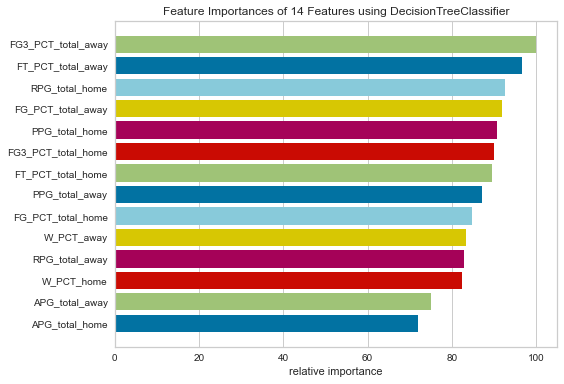

---------------------------------------------
i=3
WINNER:

Best decision tree accuracy ({'max_depth': 29, 'criterion': 'gini'}): 0.50
              precision    recall  f1-score   support

           0       0.51      0.50      0.50      1904
           1       0.50      0.51      0.50      1871

    accuracy                           0.50      3775
   macro avg       0.50      0.50      0.50      3775
weighted avg       0.50      0.50      0.50      3775



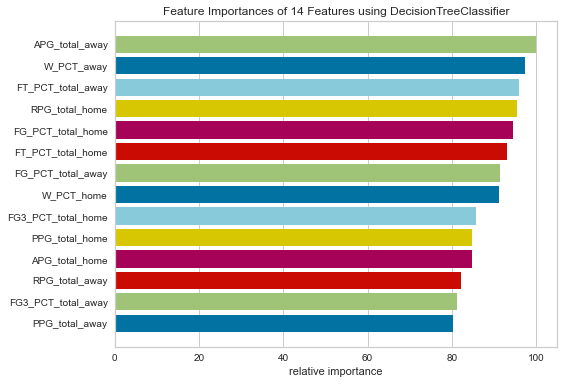

---------------------------------------------
i=4
WINNER:

Best decision tree accuracy ({'max_depth': 41, 'criterion': 'gini'}): 0.50
              precision    recall  f1-score   support

           0       0.49      0.51      0.50      1845
           1       0.51      0.49      0.50      1930

    accuracy                           0.50      3775
   macro avg       0.50      0.50      0.50      3775
weighted avg       0.50      0.50      0.50      3775



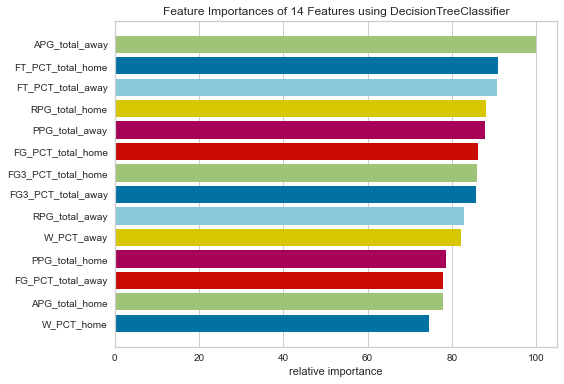

---------------------------------------------
Mean accuracy: 0.4998346300089797
Max accuracy: 0.5027814569536424
Min accuracy: 0.4970868644067797
i=5
FGP:

Best decision tree accuracy ({'max_depth': 48, 'criterion': 'gini'}): 0.49
              precision    recall  f1-score   support

           0       0.47      0.49      0.48      2005
           1       0.50      0.48      0.49      2146

    accuracy                           0.49      4151
   macro avg       0.49      0.49      0.49      4151
weighted avg       0.49      0.49      0.49      4151



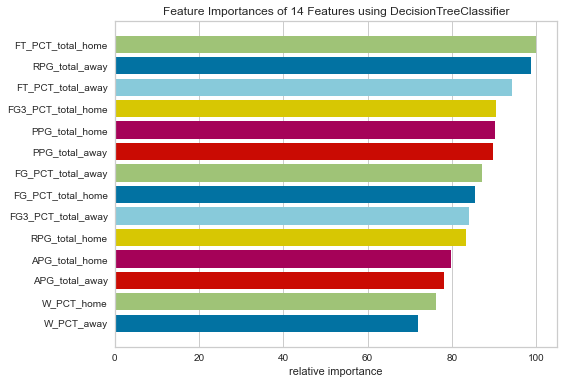

---------------------------------------------
i=6
FGP:

Best decision tree accuracy ({'max_depth': 48, 'criterion': 'gini'}): 0.50
              precision    recall  f1-score   support

           0       0.51      0.50      0.50      2127
           1       0.49      0.50      0.49      2024

    accuracy                           0.50      4151
   macro avg       0.50      0.50      0.50      4151
weighted avg       0.50      0.50      0.50      4151



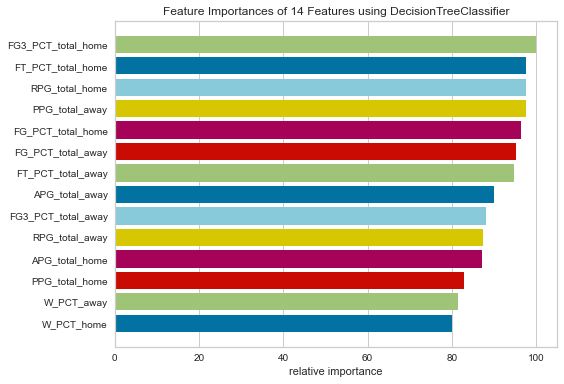

---------------------------------------------
i=7
FGP:

Best decision tree accuracy ({'max_depth': 45, 'criterion': 'entropy'}): 0.49
              precision    recall  f1-score   support

           0       0.50      0.49      0.49      2125
           1       0.48      0.49      0.48      2025

    accuracy                           0.49      4150
   macro avg       0.49      0.49      0.49      4150
weighted avg       0.49      0.49      0.49      4150



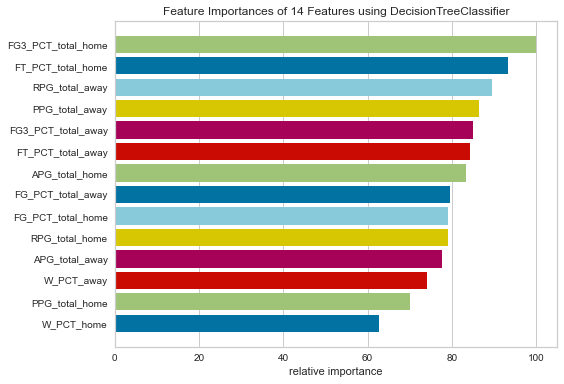

---------------------------------------------
i=8
FGP:

Best decision tree accuracy ({'max_depth': 40, 'criterion': 'entropy'}): 0.51
              precision    recall  f1-score   support

           0       0.51      0.45      0.48      2078
           1       0.51      0.56      0.53      2072

    accuracy                           0.51      4150
   macro avg       0.51      0.51      0.51      4150
weighted avg       0.51      0.51      0.51      4150



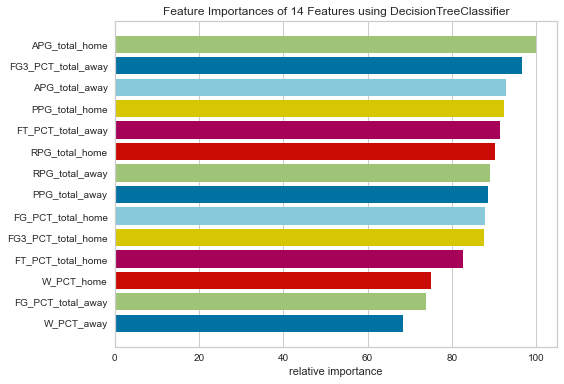

---------------------------------------------
i=9
FGP:

Best decision tree accuracy ({'max_depth': 51, 'criterion': 'gini'}): 0.50
              precision    recall  f1-score   support

           0       0.49      0.51      0.50      2041
           1       0.51      0.50      0.50      2109

    accuracy                           0.50      4150
   macro avg       0.50      0.50      0.50      4150
weighted avg       0.50      0.50      0.50      4150



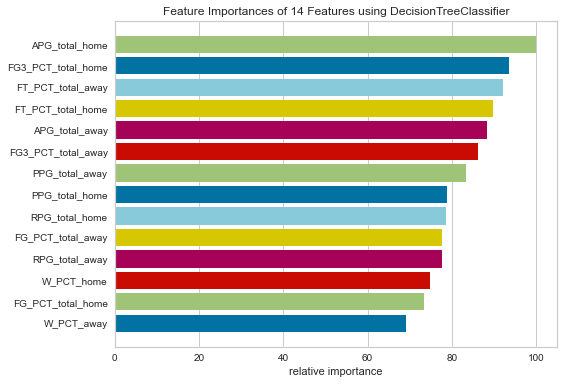

---------------------------------------------
Mean accuracy: 0.49566353585868406
Max accuracy: 0.5079518072289156
Min accuracy: 0.4861479161647796
i=10
FG3:

Best decision tree accuracy ({'max_depth': 51, 'criterion': 'gini'}): 0.50
              precision    recall  f1-score   support

           0       0.49      0.51      0.50      2252
           1       0.50      0.48      0.49      2296

    accuracy                           0.50      4548
   macro avg       0.50      0.50      0.50      4548
weighted avg       0.50      0.50      0.50      4548



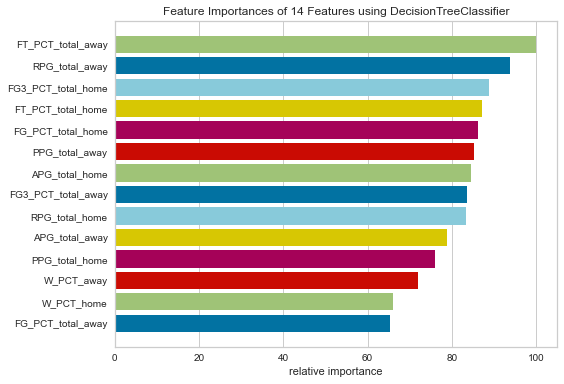

---------------------------------------------
i=11
FG3:

Best decision tree accuracy ({'max_depth': 59, 'criterion': 'gini'}): 0.50
              precision    recall  f1-score   support

           0       0.49      0.49      0.49      2257
           1       0.50      0.50      0.50      2291

    accuracy                           0.50      4548
   macro avg       0.50      0.50      0.50      4548
weighted avg       0.50      0.50      0.50      4548



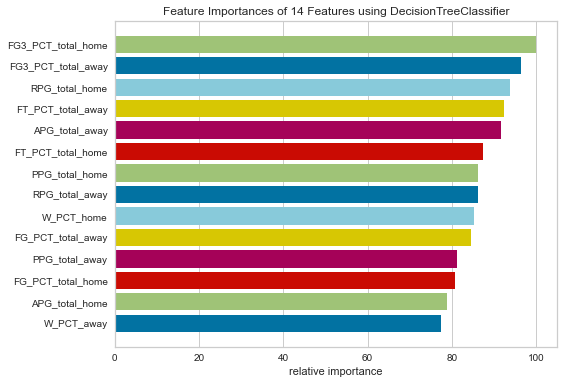

---------------------------------------------
i=12
FG3:

Best decision tree accuracy ({'max_depth': 54, 'criterion': 'gini'}): 0.50
              precision    recall  f1-score   support

           0       0.51      0.50      0.51      2321
           1       0.49      0.50      0.49      2227

    accuracy                           0.50      4548
   macro avg       0.50      0.50      0.50      4548
weighted avg       0.50      0.50      0.50      4548



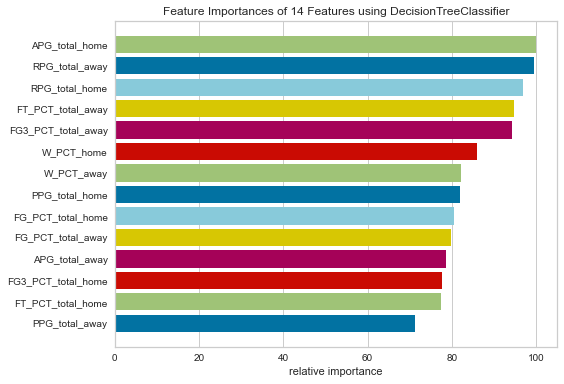

---------------------------------------------
i=13
FG3:

Best decision tree accuracy ({'max_depth': 56, 'criterion': 'gini'}): 0.48
              precision    recall  f1-score   support

           0       0.49      0.48      0.48      2312
           1       0.47      0.48      0.48      2236

    accuracy                           0.48      4548
   macro avg       0.48      0.48      0.48      4548
weighted avg       0.48      0.48      0.48      4548



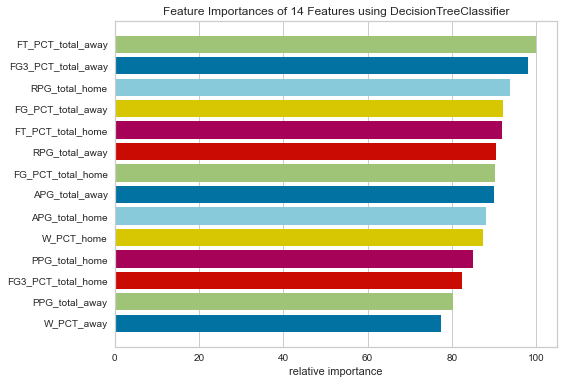

---------------------------------------------
i=14
FG3:

Best decision tree accuracy ({'max_depth': 36, 'criterion': 'gini'}): 0.50
              precision    recall  f1-score   support

           0       0.49      0.51      0.50      2228
           1       0.51      0.50      0.50      2320

    accuracy                           0.50      4548
   macro avg       0.50      0.50      0.50      4548
weighted avg       0.50      0.50      0.50      4548



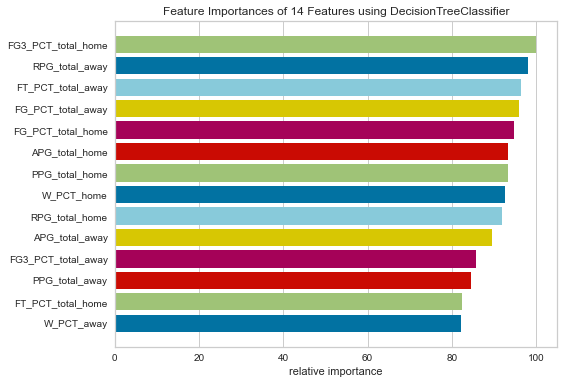

---------------------------------------------
Mean accuracy: 0.49257915567282323
Max accuracy: 0.49978012313104664
Min accuracy: 0.4793315743183817
i=15
FT:

Best decision tree accuracy ({'max_depth': 46, 'criterion': 'gini'}): 0.50
              precision    recall  f1-score   support

           0       0.49      0.50      0.50      2255
           1       0.51      0.51      0.51      2322

    accuracy                           0.50      4577
   macro avg       0.50      0.50      0.50      4577
weighted avg       0.50      0.50      0.50      4577



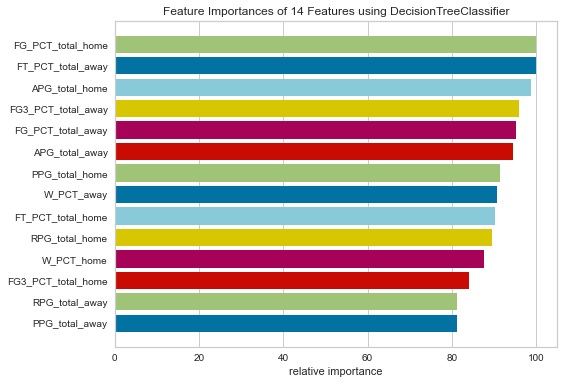

---------------------------------------------
i=16
FT:

Best decision tree accuracy ({'max_depth': 41, 'criterion': 'gini'}): 0.51
              precision    recall  f1-score   support

           0       0.51      0.50      0.51      2292
           1       0.50      0.51      0.50      2285

    accuracy                           0.51      4577
   macro avg       0.51      0.51      0.51      4577
weighted avg       0.51      0.51      0.51      4577



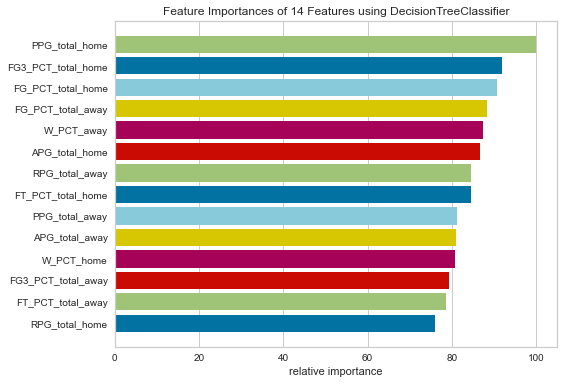

---------------------------------------------
i=17
FT:

Best decision tree accuracy ({'max_depth': 57, 'criterion': 'entropy'}): 0.51
              precision    recall  f1-score   support

           0       0.52      0.51      0.51      2322
           1       0.50      0.51      0.51      2255

    accuracy                           0.51      4577
   macro avg       0.51      0.51      0.51      4577
weighted avg       0.51      0.51      0.51      4577



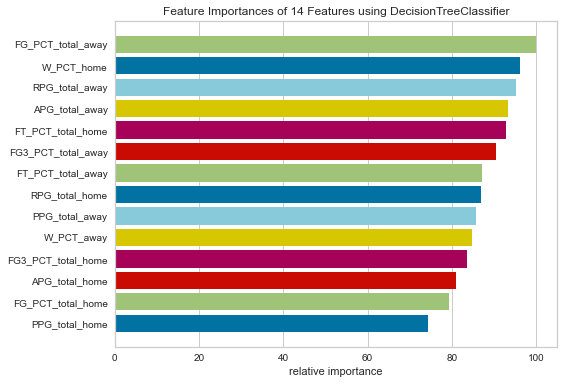

---------------------------------------------
i=18
FT:

Best decision tree accuracy ({'max_depth': 56, 'criterion': 'gini'}): 0.52
              precision    recall  f1-score   support

           0       0.53      0.51      0.52      2330
           1       0.51      0.53      0.52      2247

    accuracy                           0.52      4577
   macro avg       0.52      0.52      0.52      4577
weighted avg       0.52      0.52      0.52      4577



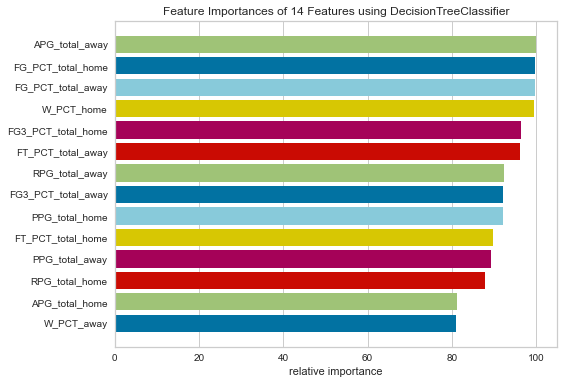

---------------------------------------------
i=19
FT:

Best decision tree accuracy ({'max_depth': 40, 'criterion': 'gini'}): 0.52
              precision    recall  f1-score   support

           0       0.51      0.53      0.52      2243
           1       0.53      0.51      0.52      2333

    accuracy                           0.52      4576
   macro avg       0.52      0.52      0.52      4576
weighted avg       0.52      0.52      0.52      4576



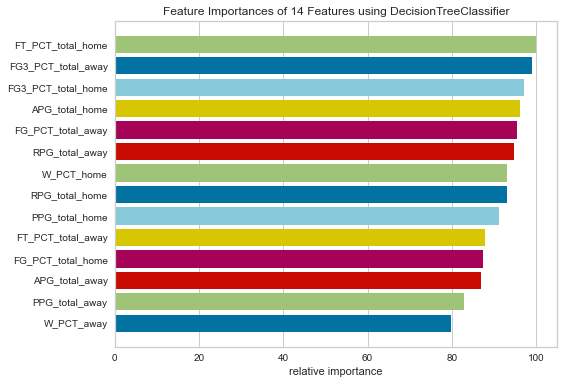

---------------------------------------------
Mean accuracy: 0.5088485907799869
Max accuracy: 0.5193358094821936
Min accuracy: 0.5022940790911077
i=20
AST:

Best decision tree accuracy ({'max_depth': 39, 'criterion': 'entropy'}): 0.50
              precision    recall  f1-score   support

           0       0.50      0.57      0.53      2048
           1       0.51      0.43      0.47      2116

    accuracy                           0.50      4164
   macro avg       0.50      0.50      0.50      4164
weighted avg       0.50      0.50      0.50      4164



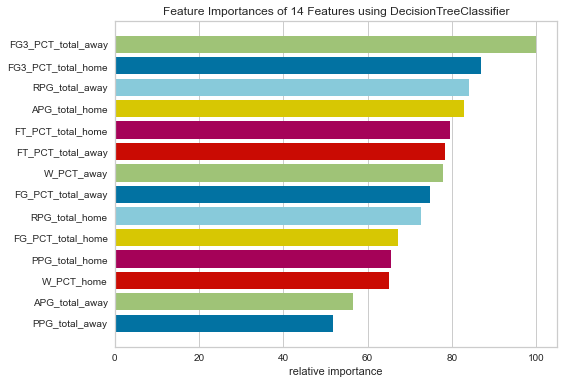

---------------------------------------------
i=21
AST:

Best decision tree accuracy ({'max_depth': 40, 'criterion': 'entropy'}): 0.50
              precision    recall  f1-score   support

           0       0.50      0.49      0.50      2096
           1       0.49      0.51      0.50      2068

    accuracy                           0.50      4164
   macro avg       0.50      0.50      0.50      4164
weighted avg       0.50      0.50      0.50      4164



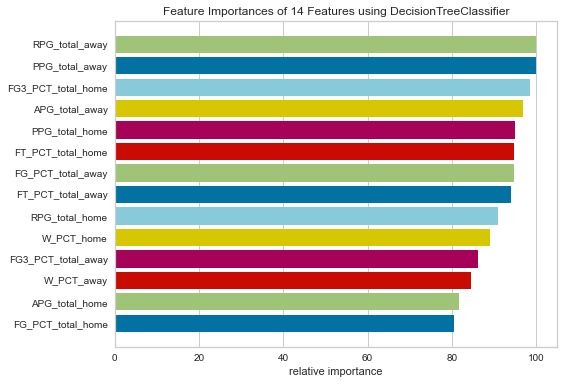

---------------------------------------------
i=22
AST:

Best decision tree accuracy ({'max_depth': 50, 'criterion': 'gini'}): 0.51
              precision    recall  f1-score   support

           0       0.52      0.51      0.52      2132
           1       0.50      0.51      0.51      2032

    accuracy                           0.51      4164
   macro avg       0.51      0.51      0.51      4164
weighted avg       0.51      0.51      0.51      4164



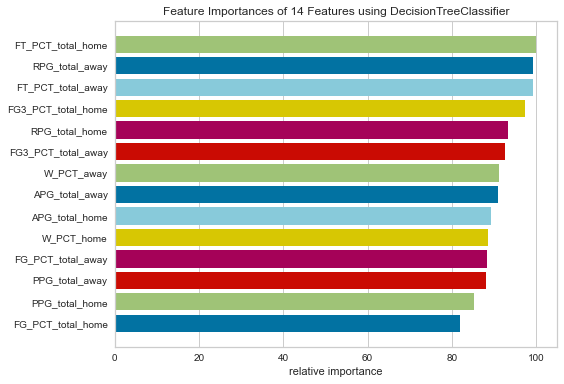

---------------------------------------------
i=23
AST:

Best decision tree accuracy ({'max_depth': 57, 'criterion': 'gini'}): 0.49
              precision    recall  f1-score   support

           0       0.50      0.51      0.50      2087
           1       0.49      0.47      0.48      2076

    accuracy                           0.49      4163
   macro avg       0.49      0.49      0.49      4163
weighted avg       0.49      0.49      0.49      4163



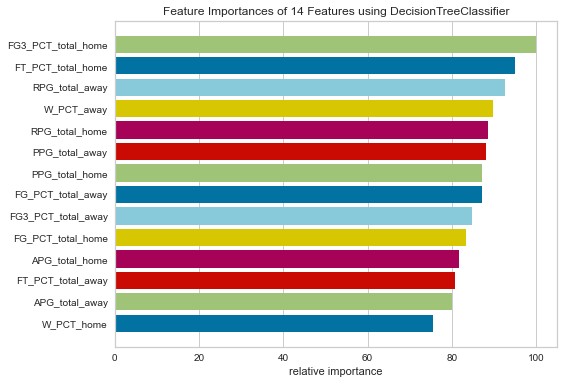

---------------------------------------------
i=24
AST:

Best decision tree accuracy ({'max_depth': 58, 'criterion': 'entropy'}): 0.51
              precision    recall  f1-score   support

           0       0.50      0.53      0.51      2046
           1       0.52      0.49      0.50      2117

    accuracy                           0.51      4163
   macro avg       0.51      0.51      0.51      4163
weighted avg       0.51      0.51      0.51      4163



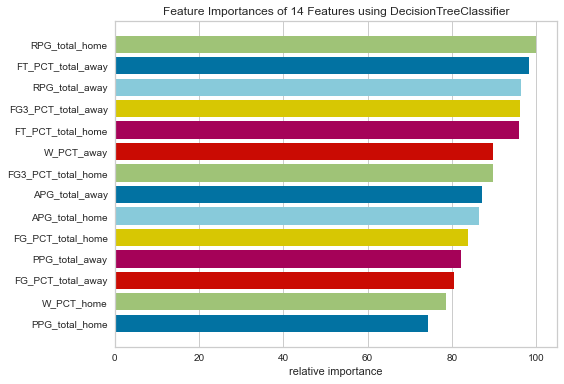

---------------------------------------------
Mean accuracy: 0.5020109483088634
Max accuracy: 0.5122478386167147
Min accuracy: 0.4943550324285371
i=25
REB:

Best decision tree accuracy ({'max_depth': 48, 'criterion': 'gini'}): 0.49
              precision    recall  f1-score   support

           0       0.49      0.50      0.49      2141
           1       0.49      0.48      0.49      2174

    accuracy                           0.49      4315
   macro avg       0.49      0.49      0.49      4315
weighted avg       0.49      0.49      0.49      4315



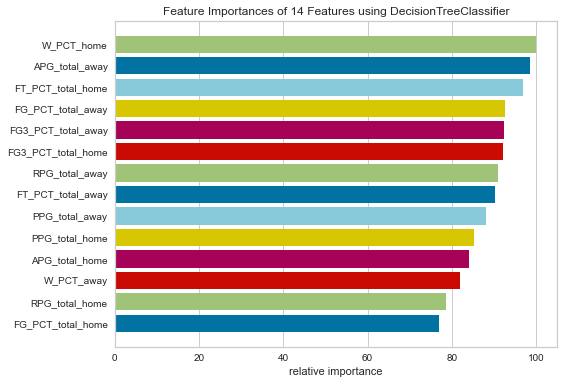

---------------------------------------------
i=26
REB:

Best decision tree accuracy ({'max_depth': 29, 'criterion': 'gini'}): 0.50
              precision    recall  f1-score   support

           0       0.50      0.54      0.52      2163
           1       0.49      0.45      0.47      2152

    accuracy                           0.50      4315
   macro avg       0.50      0.50      0.49      4315
weighted avg       0.50      0.50      0.49      4315



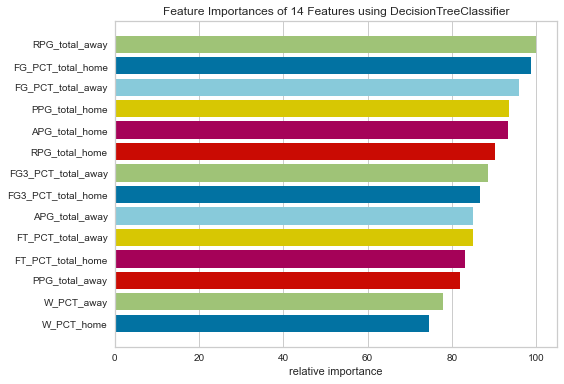

---------------------------------------------
i=27
REB:

Best decision tree accuracy ({'max_depth': 45, 'criterion': 'gini'}): 0.48
              precision    recall  f1-score   support

           0       0.49      0.49      0.49      2181
           1       0.47      0.46      0.47      2133

    accuracy                           0.48      4314
   macro avg       0.48      0.48      0.48      4314
weighted avg       0.48      0.48      0.48      4314



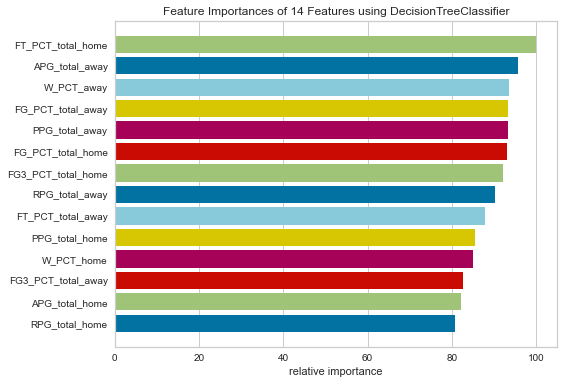

---------------------------------------------
i=28
REB:

Best decision tree accuracy ({'max_depth': 46, 'criterion': 'entropy'}): 0.51
              precision    recall  f1-score   support

           0       0.52      0.50      0.51      2182
           1       0.51      0.53      0.52      2132

    accuracy                           0.51      4314
   macro avg       0.52      0.52      0.51      4314
weighted avg       0.52      0.51      0.51      4314



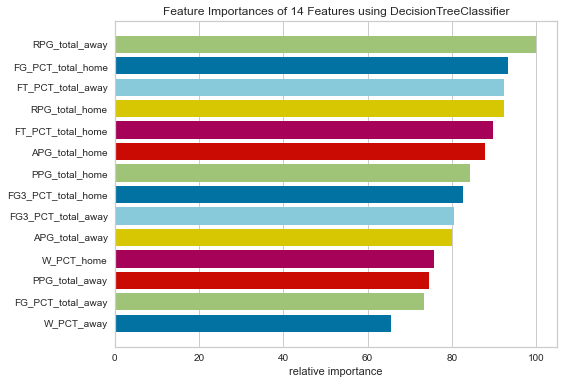

---------------------------------------------
i=29
REB:

Best decision tree accuracy ({'max_depth': 45, 'criterion': 'entropy'}): 0.50
              precision    recall  f1-score   support

           0       0.49      0.57      0.53      2119
           1       0.51      0.42      0.46      2195

    accuracy                           0.50      4314
   macro avg       0.50      0.50      0.49      4314
weighted avg       0.50      0.50      0.49      4314



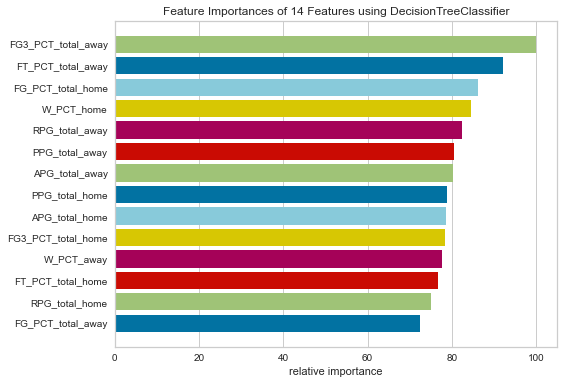

---------------------------------------------
Mean accuracy: 0.4948432197630824
Max accuracy: 0.5148354195642095
Min accuracy: 0.47913769123783034


In [28]:
print_cross_validated_and_plot(X_train_dicts, X_test_dicts, y_train_dicts, y_test_dicts, {
    'max_depth': [*range(4,60)],
    'criterion': ['gini', 'entropy'],
})

## Try prune impurity decrease

i=0
WINNER:

Best decision tree accuracy ({'min_impurity_decrease': 0.05, 'criterion': 'gini'}): 0.49
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1916
           1       0.49      1.00      0.66      1860

    accuracy                           0.49      3776
   macro avg       0.25      0.50      0.33      3776
weighted avg       0.24      0.49      0.33      3776



c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

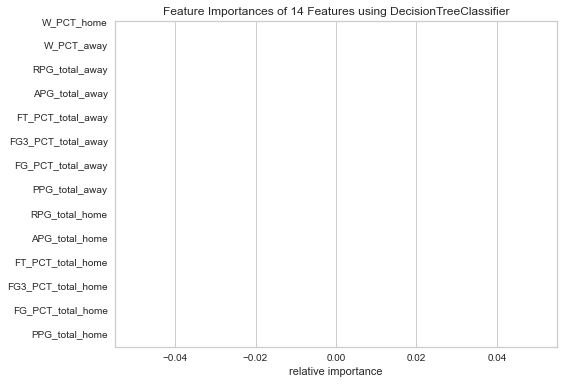

---------------------------------------------
i=1
WINNER:

Best decision tree accuracy ({'min_impurity_decrease': 0.85, 'criterion': 'gini'}): 0.49
              precision    recall  f1-score   support

           0       0.49      1.00      0.66      1860
           1       0.00      0.00      0.00      1915

    accuracy                           0.49      3775
   macro avg       0.25      0.50      0.33      3775
weighted avg       0.24      0.49      0.33      3775



c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

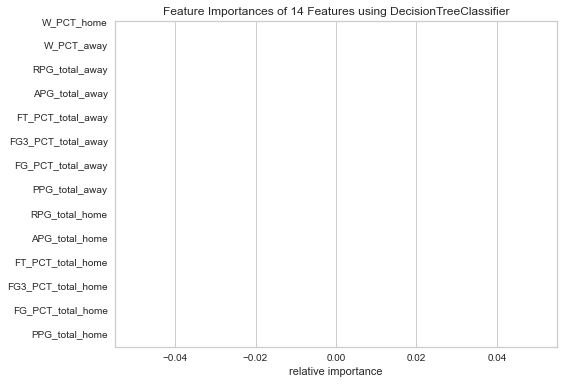

---------------------------------------------
i=2
WINNER:

Best decision tree accuracy ({'min_impurity_decrease': 0.7, 'criterion': 'gini'}): 0.49
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1913
           1       0.49      1.00      0.66      1862

    accuracy                           0.49      3775
   macro avg       0.25      0.50      0.33      3775
weighted avg       0.24      0.49      0.33      3775



c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

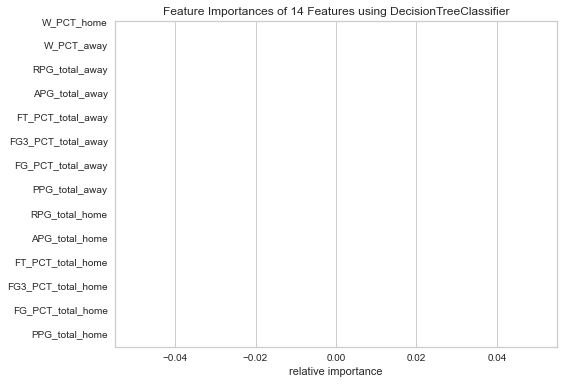

---------------------------------------------
i=3
WINNER:

Best decision tree accuracy ({'min_impurity_decrease': 0.1, 'criterion': 'entropy'}): 0.50
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1904
           1       0.50      1.00      0.66      1871

    accuracy                           0.50      3775
   macro avg       0.25      0.50      0.33      3775
weighted avg       0.25      0.50      0.33      3775



c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

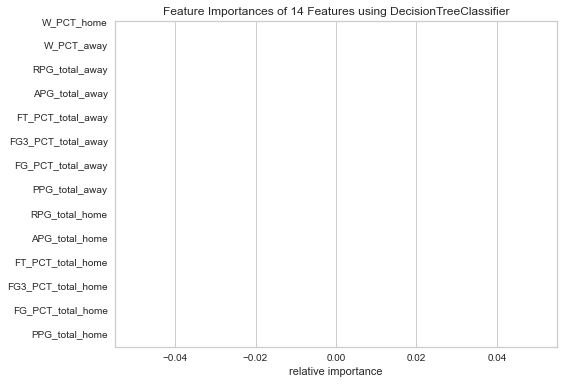

---------------------------------------------
i=4
WINNER:

Best decision tree accuracy ({'min_impurity_decrease': 0.85, 'criterion': 'entropy'}): 0.49
              precision    recall  f1-score   support

           0       0.49      1.00      0.66      1845
           1       0.00      0.00      0.00      1930

    accuracy                           0.49      3775
   macro avg       0.24      0.50      0.33      3775
weighted avg       0.24      0.49      0.32      3775



c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

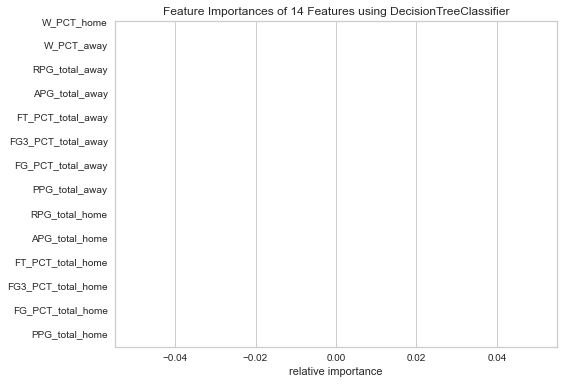

---------------------------------------------
Mean accuracy: 0.49354353743405543
Max accuracy: 0.49562913907284767
Min accuracy: 0.4925847457627119
i=5
FGP:

Best decision tree accuracy ({'min_impurity_decrease': 0.45, 'criterion': 'gini'}): 0.48
              precision    recall  f1-score   support

           0       0.48      1.00      0.65      2005
           1       0.00      0.00      0.00      2146

    accuracy                           0.48      4151
   macro avg       0.24      0.50      0.33      4151
weighted avg       0.23      0.48      0.31      4151



c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

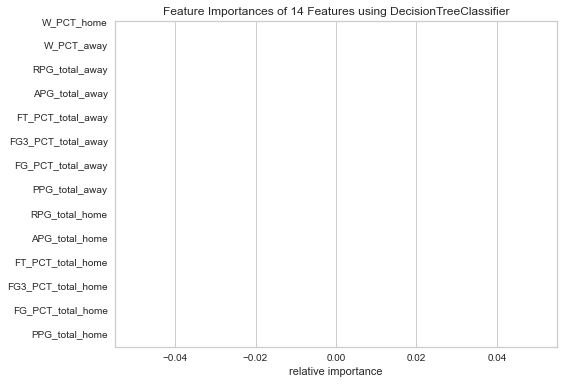

---------------------------------------------
i=6
FGP:

Best decision tree accuracy ({'min_impurity_decrease': 0.65, 'criterion': 'gini'}): 0.49
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2127
           1       0.49      1.00      0.66      2024

    accuracy                           0.49      4151
   macro avg       0.24      0.50      0.33      4151
weighted avg       0.24      0.49      0.32      4151



c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

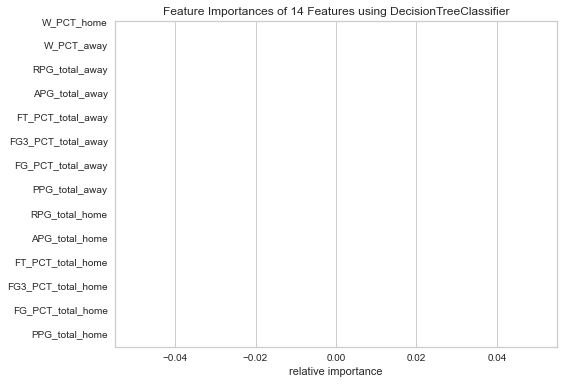

---------------------------------------------
i=7
FGP:

Best decision tree accuracy ({'min_impurity_decrease': 0.3, 'criterion': 'gini'}): 0.49
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2125
           1       0.49      1.00      0.66      2025

    accuracy                           0.49      4150
   macro avg       0.24      0.50      0.33      4150
weighted avg       0.24      0.49      0.32      4150



c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

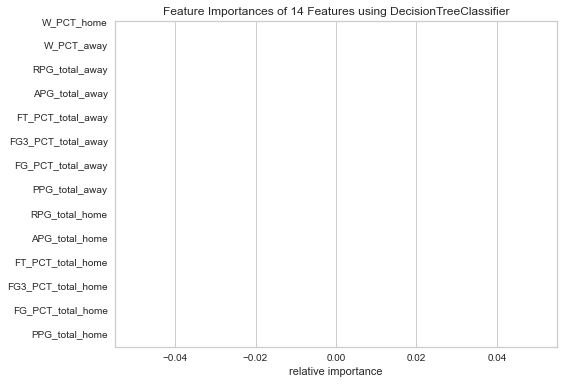

---------------------------------------------
i=8
FGP:

Best decision tree accuracy ({'min_impurity_decrease': 0.2, 'criterion': 'entropy'}): 0.50
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2078
           1       0.50      1.00      0.67      2072

    accuracy                           0.50      4150
   macro avg       0.25      0.50      0.33      4150
weighted avg       0.25      0.50      0.33      4150



c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

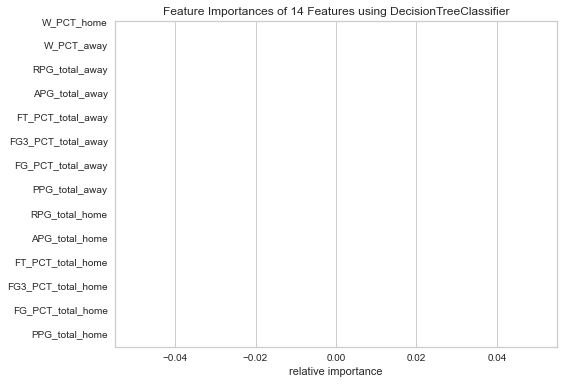

---------------------------------------------
i=9
FGP:

Best decision tree accuracy ({'min_impurity_decrease': 0.25, 'criterion': 'gini'}): 0.49
              precision    recall  f1-score   support

           0       0.49      1.00      0.66      2041
           1       0.00      0.00      0.00      2109

    accuracy                           0.49      4150
   macro avg       0.25      0.50      0.33      4150
weighted avg       0.24      0.49      0.32      4150



c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

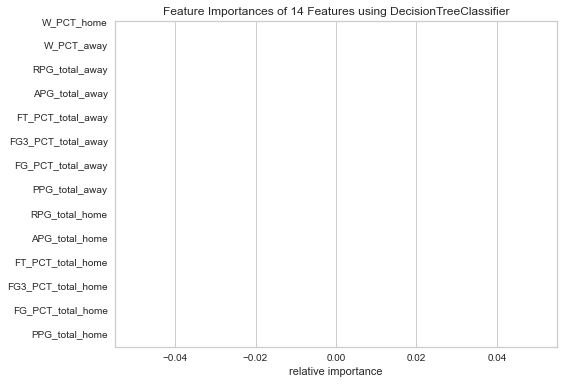

---------------------------------------------
Mean accuracy: 0.4894596018378501
Max accuracy: 0.49927710843373496
Min accuracy: 0.4830161406889906
i=10
FG3:

Best decision tree accuracy ({'min_impurity_decrease': 0.5, 'criterion': 'gini'}): 0.50
              precision    recall  f1-score   support

           0       0.50      1.00      0.66      2252
           1       0.00      0.00      0.00      2296

    accuracy                           0.50      4548
   macro avg       0.25      0.50      0.33      4548
weighted avg       0.25      0.50      0.33      4548



c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

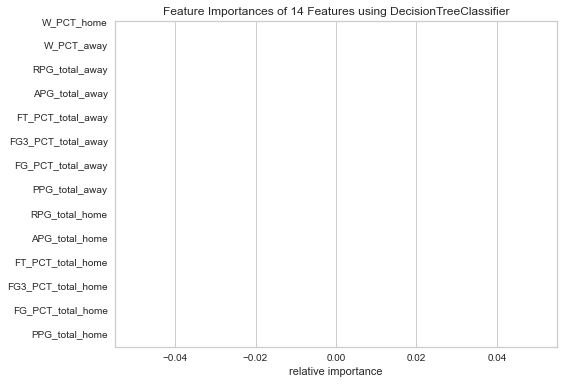

---------------------------------------------
i=11
FG3:

Best decision tree accuracy ({'min_impurity_decrease': 0.9, 'criterion': 'gini'}): 0.50
              precision    recall  f1-score   support

           0       0.50      1.00      0.66      2257
           1       0.00      0.00      0.00      2291

    accuracy                           0.50      4548
   macro avg       0.25      0.50      0.33      4548
weighted avg       0.25      0.50      0.33      4548



c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

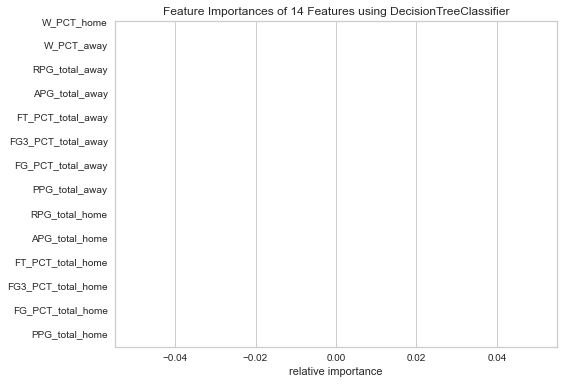

---------------------------------------------
i=12
FG3:

Best decision tree accuracy ({'min_impurity_decrease': 0.2, 'criterion': 'entropy'}): 0.49
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2321
           1       0.49      1.00      0.66      2227

    accuracy                           0.49      4548
   macro avg       0.24      0.50      0.33      4548
weighted avg       0.24      0.49      0.32      4548



c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

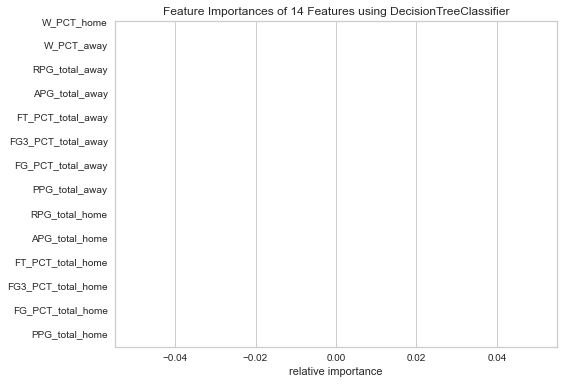

---------------------------------------------
i=13
FG3:

Best decision tree accuracy ({'min_impurity_decrease': 0.7, 'criterion': 'gini'}): 0.49
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2312
           1       0.49      1.00      0.66      2236

    accuracy                           0.49      4548
   macro avg       0.25      0.50      0.33      4548
weighted avg       0.24      0.49      0.32      4548



c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

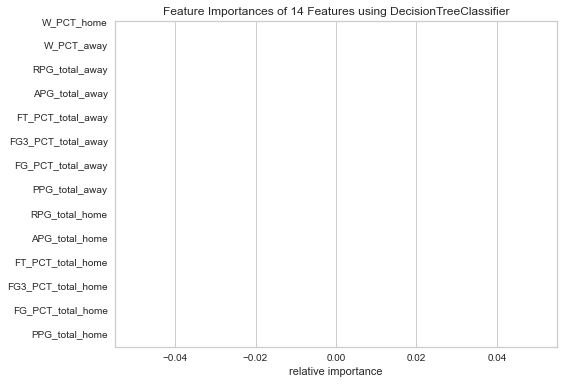

---------------------------------------------
i=14
FG3:

Best decision tree accuracy ({'min_impurity_decrease': 0.7, 'criterion': 'gini'}): 0.49
              precision    recall  f1-score   support

           0       0.49      1.00      0.66      2228
           1       0.00      0.00      0.00      2320

    accuracy                           0.49      4548
   macro avg       0.24      0.50      0.33      4548
weighted avg       0.24      0.49      0.32      4548



c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

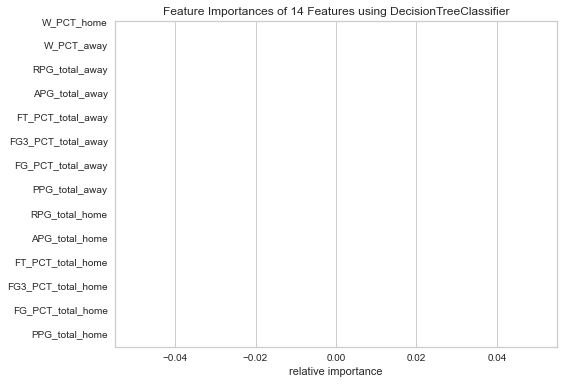

---------------------------------------------
Mean accuracy: 0.493183817062445
Max accuracy: 0.4962620932277924
Min accuracy: 0.48966578715919085
i=15
FT:

Best decision tree accuracy ({'min_impurity_decrease': 0.15, 'criterion': 'gini'}): 0.49
              precision    recall  f1-score   support

           0       0.49      1.00      0.66      2255
           1       0.00      0.00      0.00      2322

    accuracy                           0.49      4577
   macro avg       0.25      0.50      0.33      4577
weighted avg       0.24      0.49      0.33      4577



c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

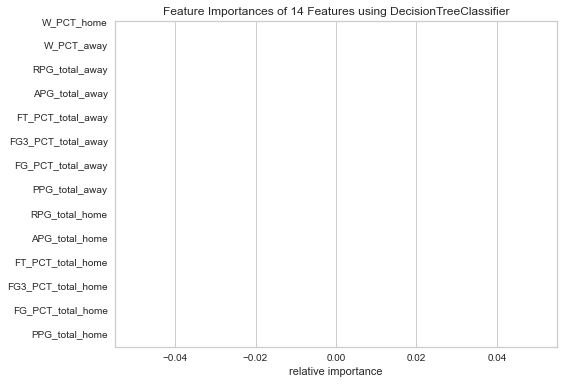

---------------------------------------------
i=16
FT:

Best decision tree accuracy ({'min_impurity_decrease': 0.2, 'criterion': 'entropy'}): 0.50
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2292
           1       0.50      1.00      0.67      2285

    accuracy                           0.50      4577
   macro avg       0.25      0.50      0.33      4577
weighted avg       0.25      0.50      0.33      4577



c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

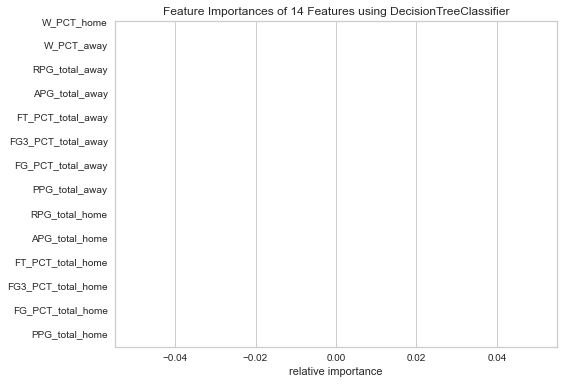

---------------------------------------------
i=17
FT:

Best decision tree accuracy ({'min_impurity_decrease': 0.1, 'criterion': 'gini'}): 0.49
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2322
           1       0.49      1.00      0.66      2255

    accuracy                           0.49      4577
   macro avg       0.25      0.50      0.33      4577
weighted avg       0.24      0.49      0.33      4577



c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

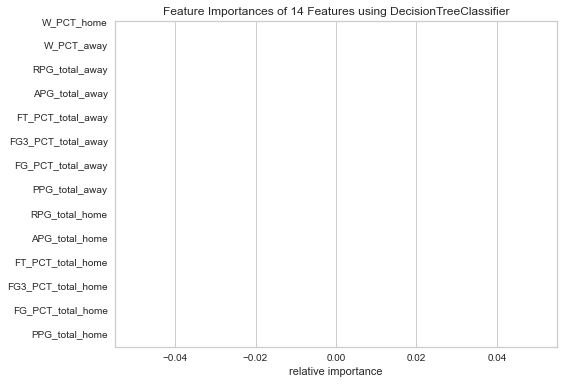

---------------------------------------------
i=18
FT:

Best decision tree accuracy ({'min_impurity_decrease': 0.05, 'criterion': 'entropy'}): 0.49
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2330
           1       0.49      1.00      0.66      2247

    accuracy                           0.49      4577
   macro avg       0.25      0.50      0.33      4577
weighted avg       0.24      0.49      0.32      4577



c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

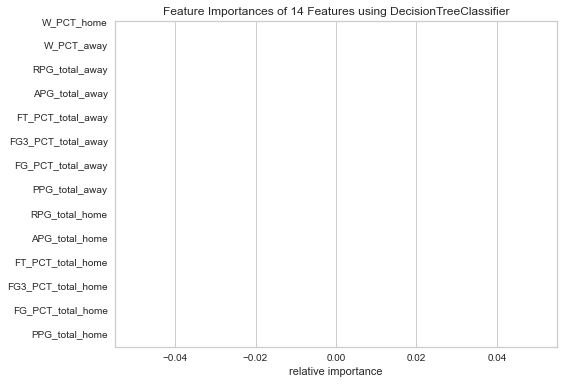

---------------------------------------------
i=19
FT:

Best decision tree accuracy ({'min_impurity_decrease': 0.3, 'criterion': 'gini'}): 0.49
              precision    recall  f1-score   support

           0       0.49      1.00      0.66      2243
           1       0.00      0.00      0.00      2333

    accuracy                           0.49      4576
   macro avg       0.25      0.50      0.33      4576
weighted avg       0.24      0.49      0.32      4576



c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

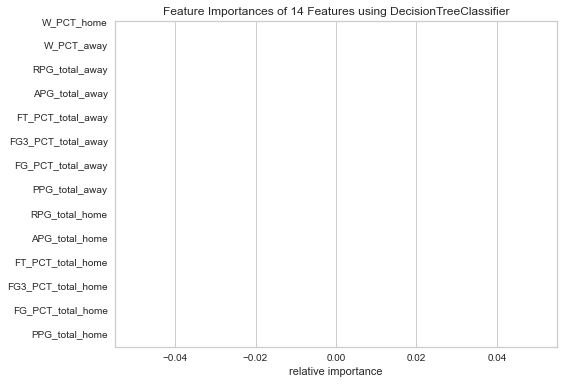

---------------------------------------------
Mean accuracy: 0.49388245575704615
Max accuracy: 0.49923530696963075
Min accuracy: 0.4909329254970505
i=20
AST:

Best decision tree accuracy ({'min_impurity_decrease': 0.3, 'criterion': 'gini'}): 0.49
              precision    recall  f1-score   support

           0       0.49      1.00      0.66      2048
           1       0.00      0.00      0.00      2116

    accuracy                           0.49      4164
   macro avg       0.25      0.50      0.33      4164
weighted avg       0.24      0.49      0.32      4164



c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

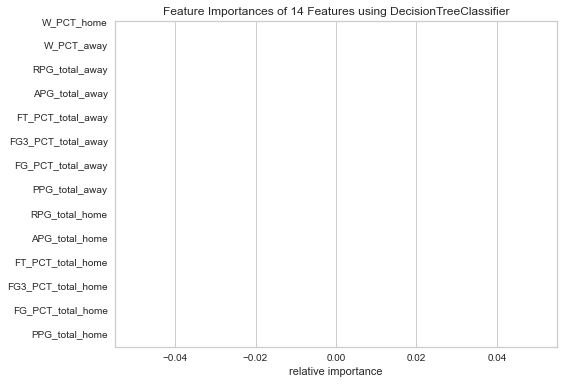

---------------------------------------------
i=21
AST:

Best decision tree accuracy ({'min_impurity_decrease': 0.95, 'criterion': 'entropy'}): 0.50
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2096
           1       0.50      1.00      0.66      2068

    accuracy                           0.50      4164
   macro avg       0.25      0.50      0.33      4164
weighted avg       0.25      0.50      0.33      4164



c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

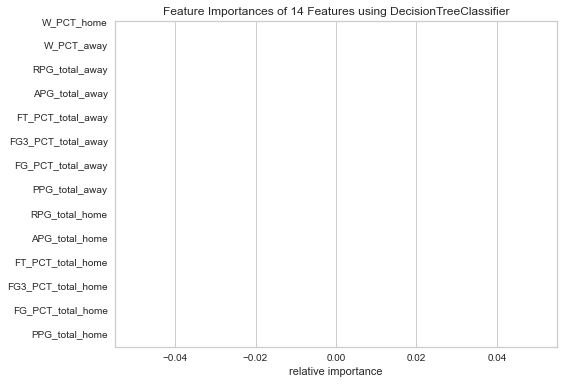

---------------------------------------------
i=22
AST:

Best decision tree accuracy ({'min_impurity_decrease': 0.5, 'criterion': 'entropy'}): 0.49
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2132
           1       0.49      1.00      0.66      2032

    accuracy                           0.49      4164
   macro avg       0.24      0.50      0.33      4164
weighted avg       0.24      0.49      0.32      4164



c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

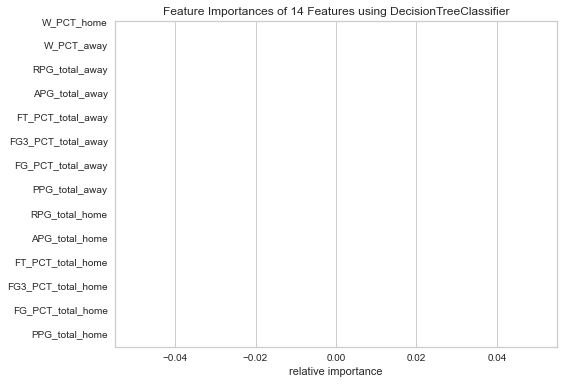

---------------------------------------------
i=23
AST:

Best decision tree accuracy ({'min_impurity_decrease': 0.8, 'criterion': 'entropy'}): 0.50
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2087
           1       0.50      1.00      0.67      2076

    accuracy                           0.50      4163
   macro avg       0.25      0.50      0.33      4163
weighted avg       0.25      0.50      0.33      4163



c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

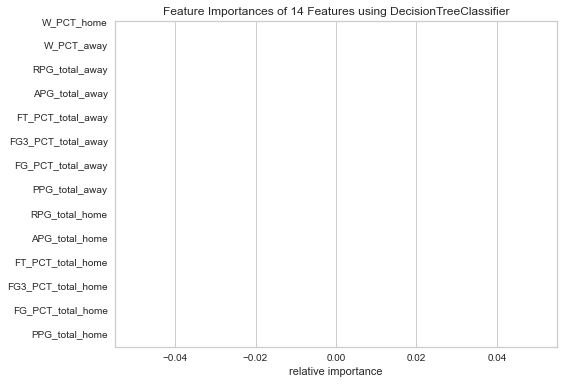

---------------------------------------------
i=24
AST:

Best decision tree accuracy ({'min_impurity_decrease': 0.4, 'criterion': 'gini'}): 0.49
              precision    recall  f1-score   support

           0       0.49      1.00      0.66      2046
           1       0.00      0.00      0.00      2117

    accuracy                           0.49      4163
   macro avg       0.25      0.50      0.33      4163
weighted avg       0.24      0.49      0.32      4163



c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

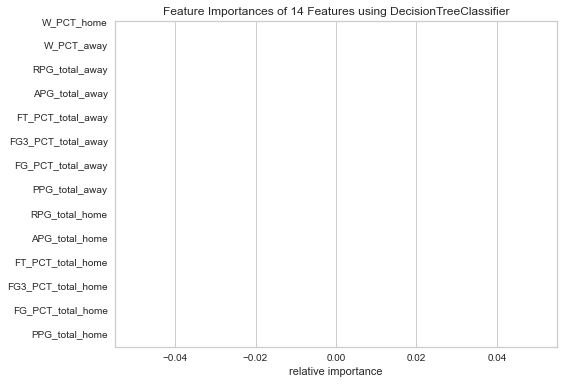

---------------------------------------------
Mean accuracy: 0.49378594373423257
Max accuracy: 0.49867883737689167
Min accuracy: 0.48799231508165225
i=25
REB:

Best decision tree accuracy ({'min_impurity_decrease': 0.95, 'criterion': 'entropy'}): 0.50
              precision    recall  f1-score   support

           0       0.50      1.00      0.66      2141
           1       0.00      0.00      0.00      2174

    accuracy                           0.50      4315
   macro avg       0.25      0.50      0.33      4315
weighted avg       0.25      0.50      0.33      4315



c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

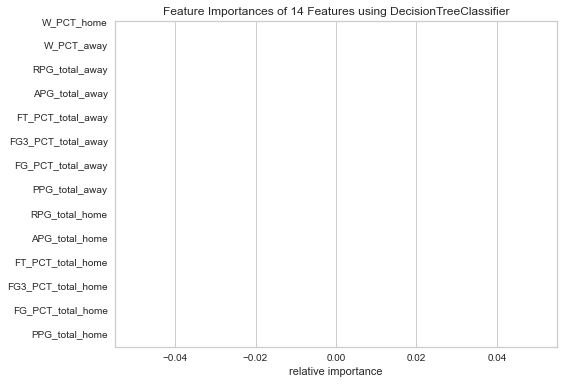

---------------------------------------------
i=26
REB:

Best decision tree accuracy ({'min_impurity_decrease': 0.4, 'criterion': 'gini'}): 0.50
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2163
           1       0.50      1.00      0.67      2152

    accuracy                           0.50      4315
   macro avg       0.25      0.50      0.33      4315
weighted avg       0.25      0.50      0.33      4315



c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

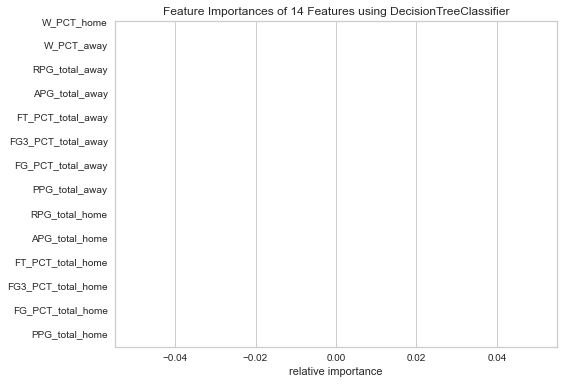

---------------------------------------------
i=27
REB:

Best decision tree accuracy ({'min_impurity_decrease': 0.9, 'criterion': 'gini'}): 0.49
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2181
           1       0.49      1.00      0.66      2133

    accuracy                           0.49      4314
   macro avg       0.25      0.50      0.33      4314
weighted avg       0.24      0.49      0.33      4314



c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

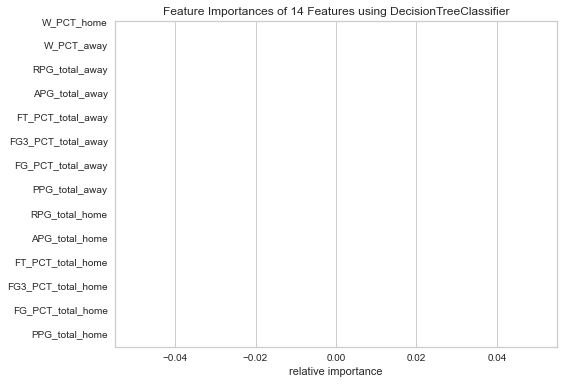

---------------------------------------------
i=28
REB:

Best decision tree accuracy ({'min_impurity_decrease': 0.65, 'criterion': 'gini'}): 0.49
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2182
           1       0.49      1.00      0.66      2132

    accuracy                           0.49      4314
   macro avg       0.25      0.50      0.33      4314
weighted avg       0.24      0.49      0.33      4314



c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

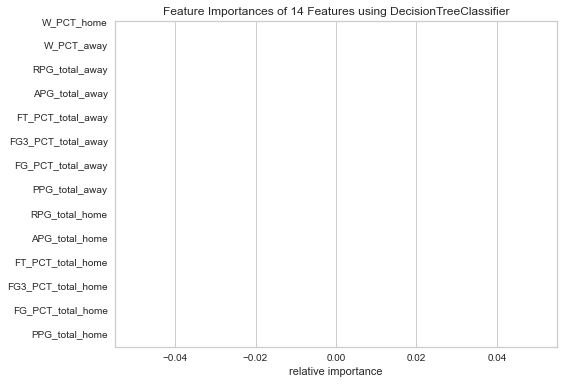

---------------------------------------------
i=29
REB:

Best decision tree accuracy ({'min_impurity_decrease': 0.9, 'criterion': 'entropy'}): 0.49
              precision    recall  f1-score   support

           0       0.49      1.00      0.66      2119
           1       0.00      0.00      0.00      2195

    accuracy                           0.49      4314
   macro avg       0.25      0.50      0.33      4314
weighted avg       0.24      0.49      0.32      4314



c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

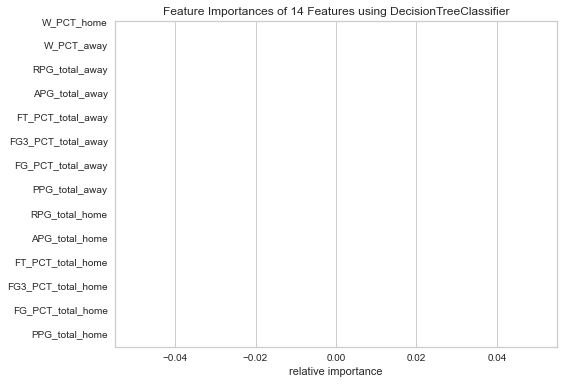

---------------------------------------------
Mean accuracy: 0.4958857845673173
Max accuracy: 0.49872537659327926
Min accuracy: 0.49420491423273066


In [29]:
# print_all_metrics_and_plot(
#     DecisionTreeClassifier(random_state=0),
#     X_train_dict,
#     X_test_dict,
#     {
#         'min_impurity_decrease': [0.0,0.01],
#         'criterion': ['gini', 'entropy'],
#     },
# )
print_cross_validated_and_plot(X_train_dicts, X_test_dicts, y_train_dicts, y_test_dicts, {
    'min_impurity_decrease': [0.0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95],
    'criterion': ['gini', 'entropy'],
})
# print('Any non-zero min_impurity_decrease causes all classifications to be 1')

## Try prune max leaves

i=0
WINNER:

Best decision tree accuracy ({'max_leaf_nodes': 1126, 'criterion': 'entropy'}): 0.50
              precision    recall  f1-score   support

           0       0.51      0.36      0.42      1916
           1       0.49      0.65      0.56      1860

    accuracy                           0.50      3776
   macro avg       0.50      0.50      0.49      3776
weighted avg       0.50      0.50      0.49      3776



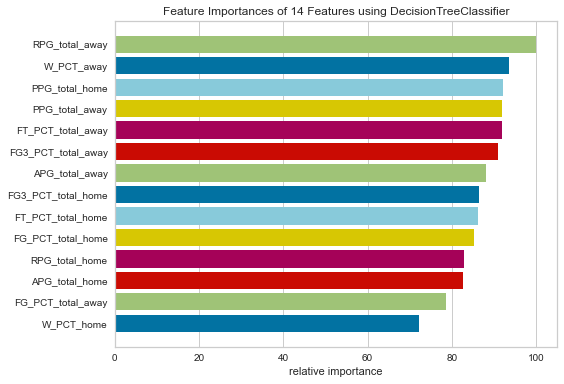

---------------------------------------------
i=1
WINNER:

Best decision tree accuracy ({'max_leaf_nodes': 1988, 'criterion': 'entropy'}): 0.50
              precision    recall  f1-score   support

           0       0.49      0.50      0.50      1860
           1       0.51      0.50      0.51      1915

    accuracy                           0.50      3775
   macro avg       0.50      0.50      0.50      3775
weighted avg       0.50      0.50      0.50      3775



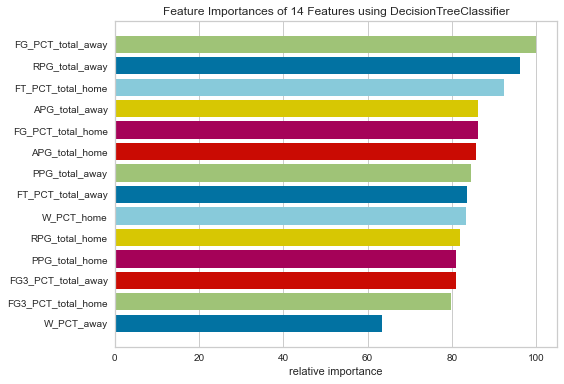

---------------------------------------------
i=2
WINNER:

Best decision tree accuracy ({'max_leaf_nodes': 1686, 'criterion': 'gini'}): 0.50
              precision    recall  f1-score   support

           0       0.51      0.48      0.50      1913
           1       0.50      0.52      0.51      1862

    accuracy                           0.50      3775
   macro avg       0.50      0.50      0.50      3775
weighted avg       0.50      0.50      0.50      3775



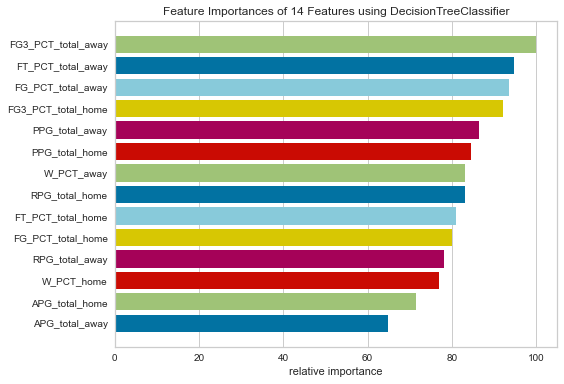

---------------------------------------------
i=3
WINNER:

Best decision tree accuracy ({'max_leaf_nodes': 1540, 'criterion': 'gini'}): 0.52
              precision    recall  f1-score   support

           0       0.52      0.51      0.52      1904
           1       0.51      0.52      0.52      1871

    accuracy                           0.52      3775
   macro avg       0.52      0.52      0.52      3775
weighted avg       0.52      0.52      0.52      3775



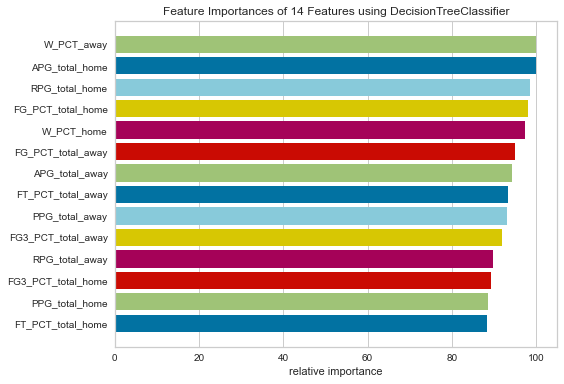

---------------------------------------------
i=4
WINNER:

Best decision tree accuracy ({'max_leaf_nodes': 1908, 'criterion': 'gini'}): 0.51
              precision    recall  f1-score   support

           0       0.50      0.52      0.51      1845
           1       0.52      0.49      0.51      1930

    accuracy                           0.51      3775
   macro avg       0.51      0.51      0.51      3775
weighted avg       0.51      0.51      0.51      3775



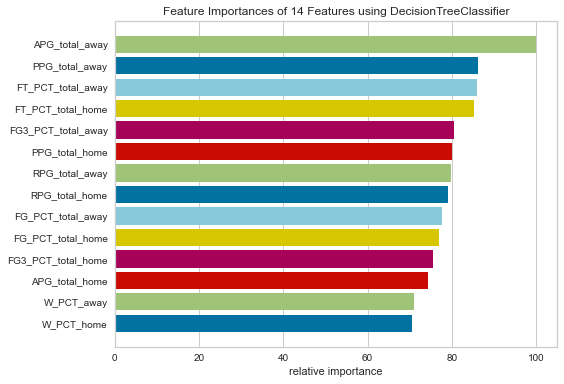

---------------------------------------------
Mean accuracy: 0.505728476821192
Max accuracy: 0.5170860927152318
Min accuracy: 0.5
i=5
FGP:

Best decision tree accuracy ({'max_leaf_nodes': 1860, 'criterion': 'entropy'}): 0.51
              precision    recall  f1-score   support

           0       0.49      0.56      0.52      2005
           1       0.53      0.46      0.49      2146

    accuracy                           0.51      4151
   macro avg       0.51      0.51      0.51      4151
weighted avg       0.51      0.51      0.50      4151



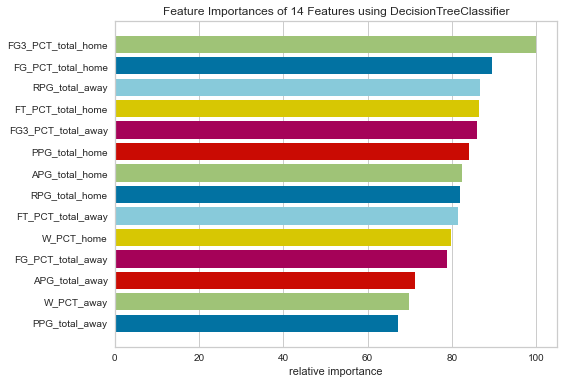

---------------------------------------------
i=6
FGP:

Best decision tree accuracy ({'max_leaf_nodes': 1596, 'criterion': 'gini'}): 0.50
              precision    recall  f1-score   support

           0       0.52      0.50      0.51      2127
           1       0.49      0.51      0.50      2024

    accuracy                           0.50      4151
   macro avg       0.50      0.50      0.50      4151
weighted avg       0.50      0.50      0.50      4151



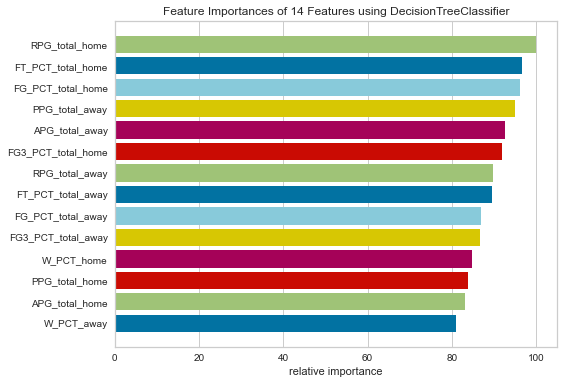

---------------------------------------------
i=7
FGP:

Best decision tree accuracy ({'max_leaf_nodes': 1958, 'criterion': 'gini'}): 0.49
              precision    recall  f1-score   support

           0       0.51      0.49      0.50      2125
           1       0.48      0.50      0.49      2025

    accuracy                           0.49      4150
   macro avg       0.49      0.49      0.49      4150
weighted avg       0.49      0.49      0.49      4150



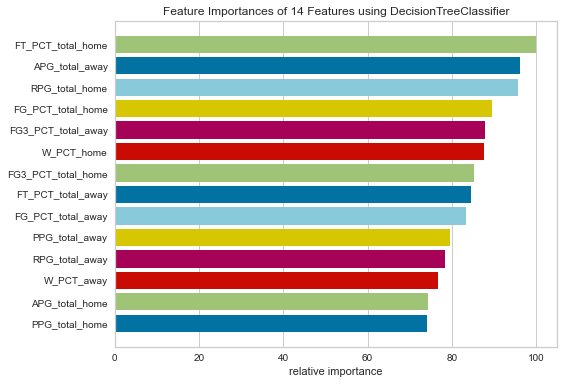

---------------------------------------------
i=8
FGP:

Best decision tree accuracy ({'max_leaf_nodes': 1998, 'criterion': 'entropy'}): 0.51
              precision    recall  f1-score   support

           0       0.51      0.47      0.49      2078
           1       0.51      0.56      0.53      2072

    accuracy                           0.51      4150
   macro avg       0.51      0.51      0.51      4150
weighted avg       0.51      0.51      0.51      4150



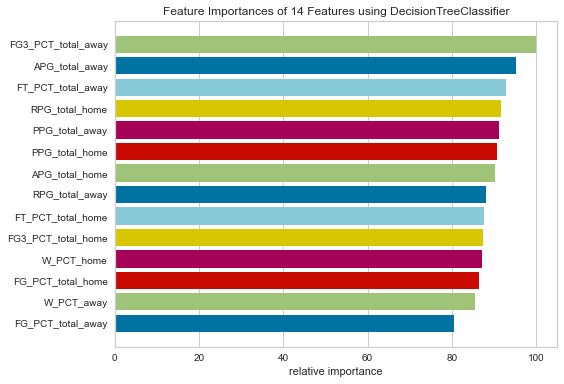

---------------------------------------------
i=9
FGP:

Best decision tree accuracy ({'max_leaf_nodes': 1892, 'criterion': 'entropy'}): 0.49
              precision    recall  f1-score   support

           0       0.48      0.40      0.44      2041
           1       0.50      0.59      0.54      2109

    accuracy                           0.49      4150
   macro avg       0.49      0.49      0.49      4150
weighted avg       0.49      0.49      0.49      4150



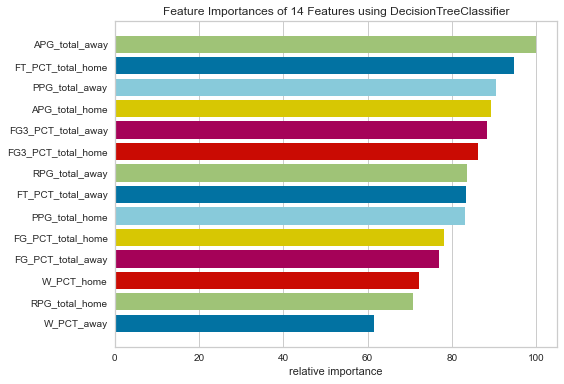

---------------------------------------------
Mean accuracy: 0.5039753086061423
Max accuracy: 0.5120481927710844
Min accuracy: 0.4939759036144578
i=10
FG3:

Best decision tree accuracy ({'max_leaf_nodes': 1734, 'criterion': 'gini'}): 0.50
              precision    recall  f1-score   support

           0       0.49      0.52      0.51      2252
           1       0.50      0.48      0.49      2296

    accuracy                           0.50      4548
   macro avg       0.50      0.50      0.50      4548
weighted avg       0.50      0.50      0.50      4548



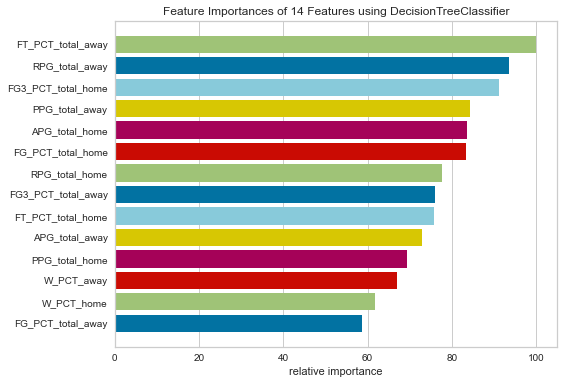

---------------------------------------------
i=11
FG3:

Best decision tree accuracy ({'max_leaf_nodes': 1860, 'criterion': 'gini'}): 0.50
              precision    recall  f1-score   support

           0       0.49      0.51      0.50      2257
           1       0.50      0.49      0.49      2291

    accuracy                           0.50      4548
   macro avg       0.50      0.50      0.50      4548
weighted avg       0.50      0.50      0.50      4548



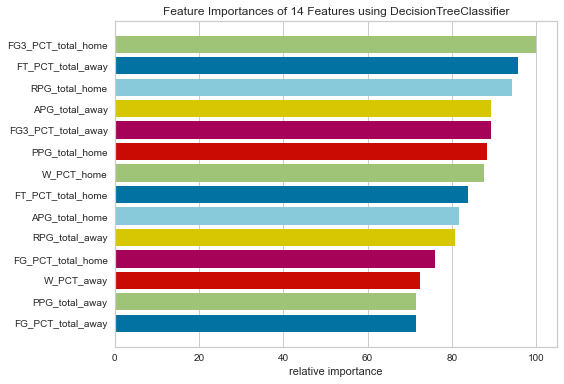

---------------------------------------------
i=12
FG3:

Best decision tree accuracy ({'max_leaf_nodes': 1944, 'criterion': 'gini'}): 0.50
              precision    recall  f1-score   support

           0       0.51      0.50      0.51      2321
           1       0.49      0.50      0.50      2227

    accuracy                           0.50      4548
   macro avg       0.50      0.50      0.50      4548
weighted avg       0.50      0.50      0.50      4548



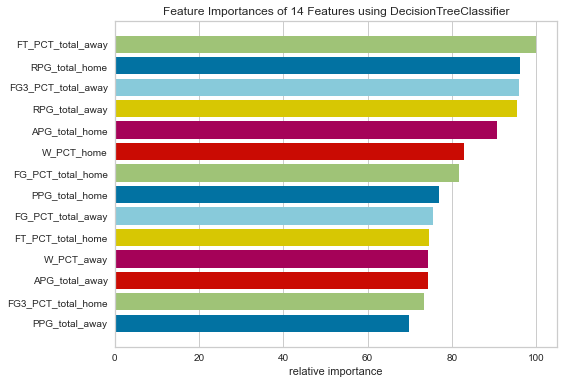

---------------------------------------------
i=13
FG3:

Best decision tree accuracy ({'max_leaf_nodes': 1416, 'criterion': 'entropy'}): 0.50
              precision    recall  f1-score   support

           0       0.50      0.58      0.54      2312
           1       0.49      0.41      0.44      2236

    accuracy                           0.50      4548
   macro avg       0.50      0.50      0.49      4548
weighted avg       0.50      0.50      0.49      4548



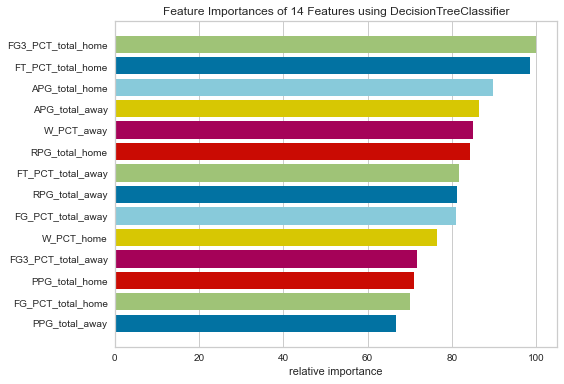

---------------------------------------------
i=14
FG3:

Best decision tree accuracy ({'max_leaf_nodes': 1650, 'criterion': 'gini'}): 0.51
              precision    recall  f1-score   support

           0       0.50      0.50      0.50      2228
           1       0.52      0.51      0.51      2320

    accuracy                           0.51      4548
   macro avg       0.51      0.51      0.51      4548
weighted avg       0.51      0.51      0.51      4548



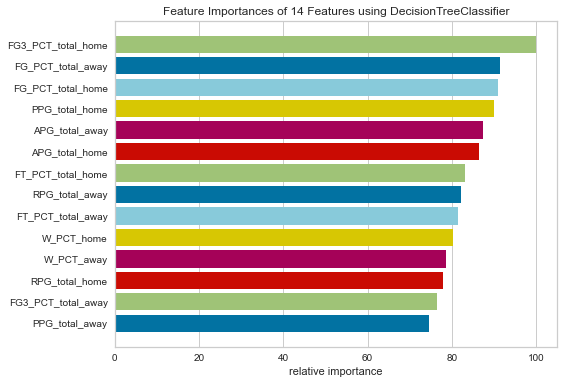

---------------------------------------------
Mean accuracy: 0.498570800351803
Max accuracy: 0.5015391380826737
Min accuracy: 0.4962620932277924
i=15
FT:

Best decision tree accuracy ({'max_leaf_nodes': 1478, 'criterion': 'gini'}): 0.50
              precision    recall  f1-score   support

           0       0.49      0.51      0.50      2255
           1       0.51      0.50      0.50      2322

    accuracy                           0.50      4577
   macro avg       0.50      0.50      0.50      4577
weighted avg       0.50      0.50      0.50      4577



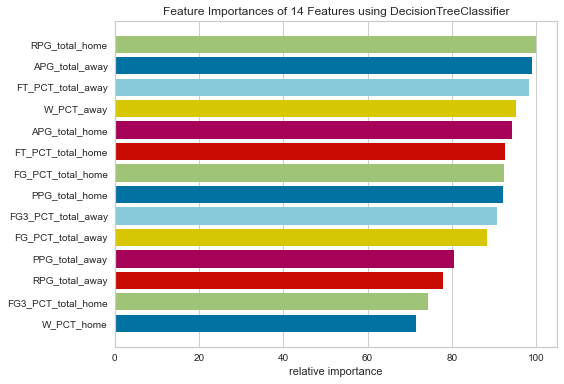

---------------------------------------------
i=16
FT:

Best decision tree accuracy ({'max_leaf_nodes': 1854, 'criterion': 'gini'}): 0.50
              precision    recall  f1-score   support

           0       0.50      0.52      0.51      2292
           1       0.50      0.47      0.48      2285

    accuracy                           0.50      4577
   macro avg       0.50      0.50      0.50      4577
weighted avg       0.50      0.50      0.50      4577



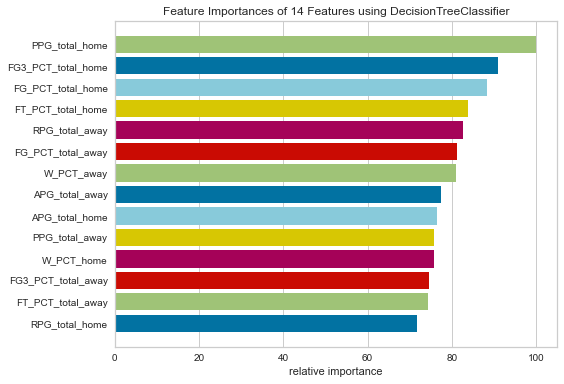

---------------------------------------------
i=17
FT:

Best decision tree accuracy ({'max_leaf_nodes': 1756, 'criterion': 'entropy'}): 0.50
              precision    recall  f1-score   support

           0       0.51      0.55      0.53      2322
           1       0.49      0.46      0.47      2255

    accuracy                           0.50      4577
   macro avg       0.50      0.50      0.50      4577
weighted avg       0.50      0.50      0.50      4577



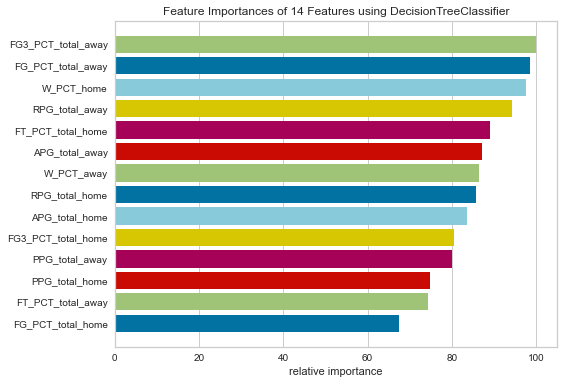

---------------------------------------------
i=18
FT:

Best decision tree accuracy ({'max_leaf_nodes': 1990, 'criterion': 'gini'}): 0.51
              precision    recall  f1-score   support

           0       0.52      0.51      0.51      2330
           1       0.50      0.52      0.51      2247

    accuracy                           0.51      4577
   macro avg       0.51      0.51      0.51      4577
weighted avg       0.51      0.51      0.51      4577



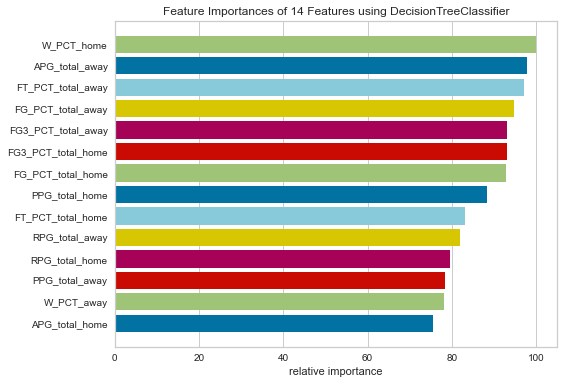

---------------------------------------------
i=19
FT:

Best decision tree accuracy ({'max_leaf_nodes': 1870, 'criterion': 'entropy'}): 0.49
              precision    recall  f1-score   support

           0       0.48      0.54      0.51      2243
           1       0.50      0.45      0.48      2333

    accuracy                           0.49      4576
   macro avg       0.49      0.49      0.49      4576
weighted avg       0.49      0.49      0.49      4576



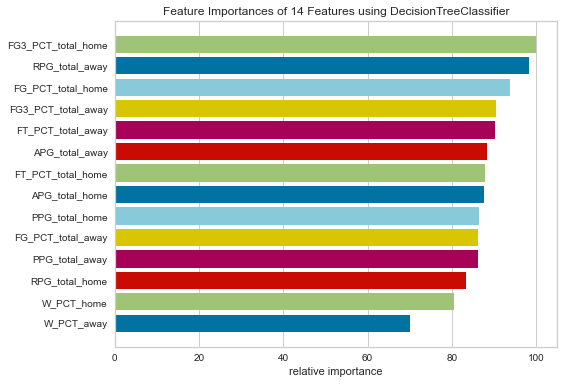

---------------------------------------------
Mean accuracy: 0.502894909329255
Max accuracy: 0.5119073629014639
Min accuracy: 0.49639501857111645
i=20
AST:

Best decision tree accuracy ({'max_leaf_nodes': 1440, 'criterion': 'entropy'}): 0.50
              precision    recall  f1-score   support

           0       0.49      0.56      0.52      2048
           1       0.51      0.44      0.47      2116

    accuracy                           0.50      4164
   macro avg       0.50      0.50      0.50      4164
weighted avg       0.50      0.50      0.50      4164



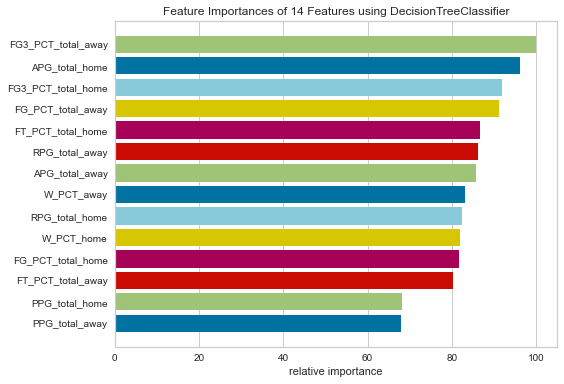

---------------------------------------------
i=21
AST:

Best decision tree accuracy ({'max_leaf_nodes': 1310, 'criterion': 'entropy'}): 0.50
              precision    recall  f1-score   support

           0       0.50      0.49      0.50      2096
           1       0.50      0.51      0.50      2068

    accuracy                           0.50      4164
   macro avg       0.50      0.50      0.50      4164
weighted avg       0.50      0.50      0.50      4164



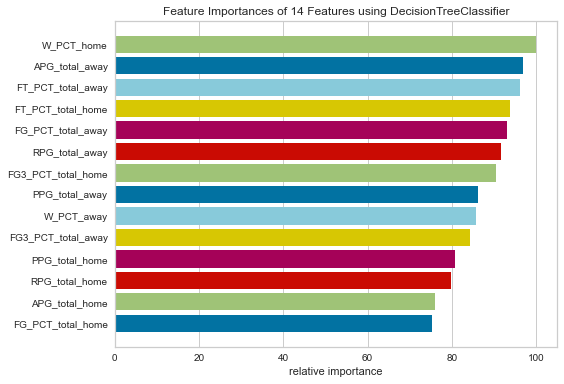

---------------------------------------------
i=22
AST:

Best decision tree accuracy ({'max_leaf_nodes': 1950, 'criterion': 'entropy'}): 0.51
              precision    recall  f1-score   support

           0       0.52      0.58      0.55      2132
           1       0.49      0.43      0.46      2032

    accuracy                           0.51      4164
   macro avg       0.50      0.50      0.50      4164
weighted avg       0.50      0.51      0.50      4164



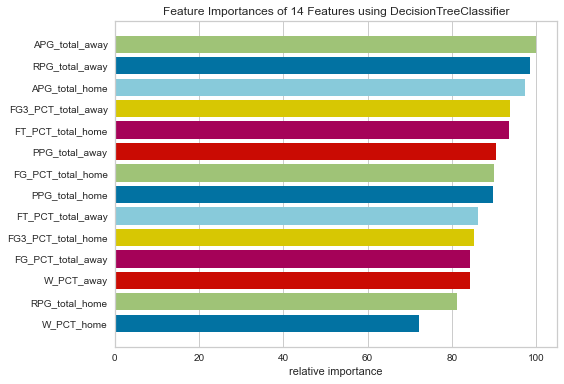

---------------------------------------------
i=23
AST:

Best decision tree accuracy ({'max_leaf_nodes': 1920, 'criterion': 'entropy'}): 0.51
              precision    recall  f1-score   support

           0       0.51      0.56      0.53      2087
           1       0.51      0.45      0.48      2076

    accuracy                           0.51      4163
   macro avg       0.51      0.51      0.51      4163
weighted avg       0.51      0.51      0.51      4163



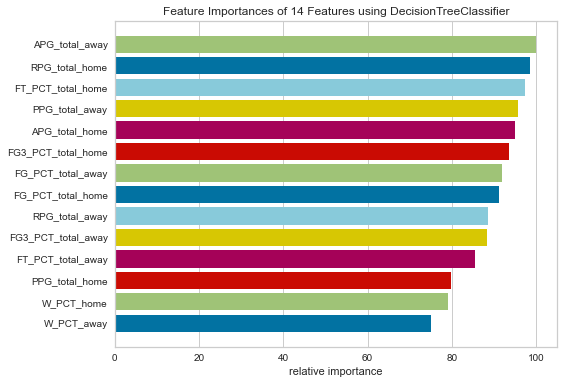

---------------------------------------------
i=24
AST:

Best decision tree accuracy ({'max_leaf_nodes': 1782, 'criterion': 'entropy'}): 0.50
              precision    recall  f1-score   support

           0       0.49      0.54      0.51      2046
           1       0.51      0.46      0.48      2117

    accuracy                           0.50      4163
   macro avg       0.50      0.50      0.50      4163
weighted avg       0.50      0.50      0.50      4163



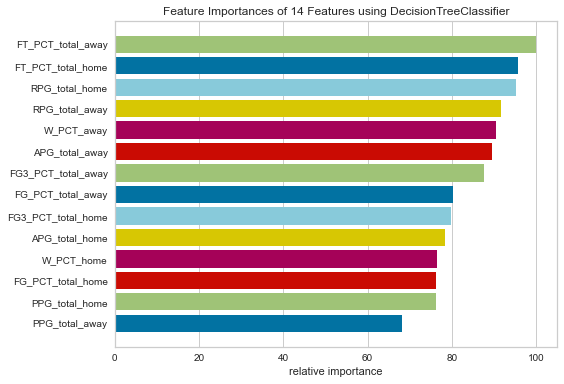

---------------------------------------------
Mean accuracy: 0.5029123323048779
Max accuracy: 0.5078068700456402
Min accuracy: 0.4978386167146974
i=25
REB:

Best decision tree accuracy ({'max_leaf_nodes': 1970, 'criterion': 'gini'}): 0.50
              precision    recall  f1-score   support

           0       0.49      0.50      0.50      2141
           1       0.50      0.49      0.49      2174

    accuracy                           0.50      4315
   macro avg       0.50      0.50      0.50      4315
weighted avg       0.50      0.50      0.50      4315



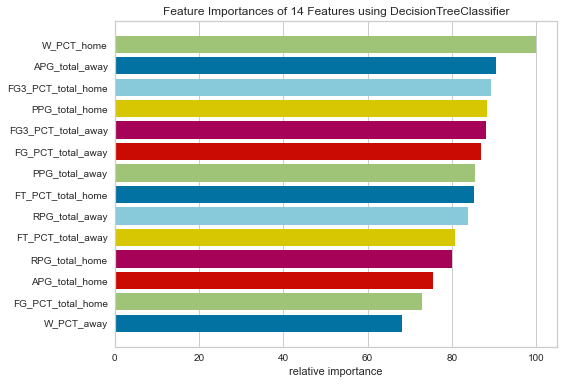

---------------------------------------------
i=26
REB:

Best decision tree accuracy ({'max_leaf_nodes': 1790, 'criterion': 'entropy'}): 0.49
              precision    recall  f1-score   support

           0       0.49      0.63      0.55      2163
           1       0.48      0.35      0.41      2152

    accuracy                           0.49      4315
   macro avg       0.49      0.49      0.48      4315
weighted avg       0.49      0.49      0.48      4315



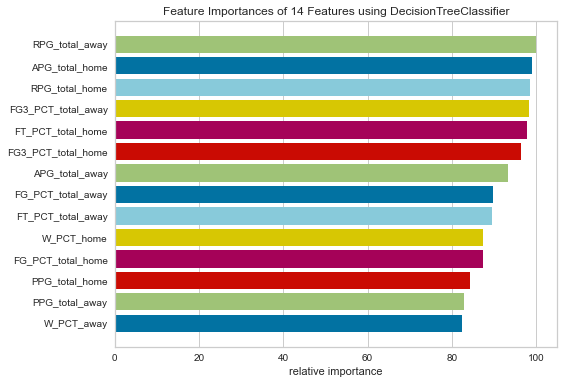

---------------------------------------------
i=27
REB:

Best decision tree accuracy ({'max_leaf_nodes': 1942, 'criterion': 'entropy'}): 0.50
              precision    recall  f1-score   support

           0       0.51      0.52      0.52      2181
           1       0.50      0.48      0.49      2133

    accuracy                           0.50      4314
   macro avg       0.50      0.50      0.50      4314
weighted avg       0.50      0.50      0.50      4314



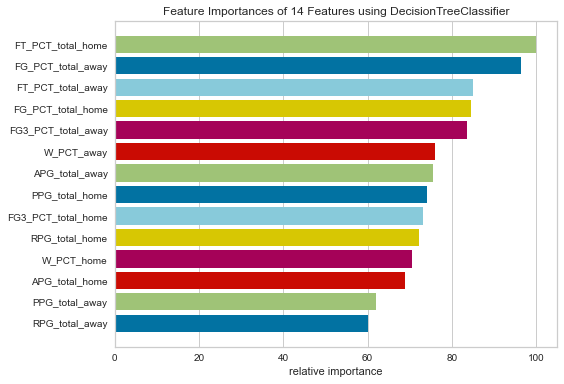

---------------------------------------------
i=28
REB:

Best decision tree accuracy ({'max_leaf_nodes': 1212, 'criterion': 'gini'}): 0.52
              precision    recall  f1-score   support

           0       0.52      0.51      0.52      2182
           1       0.51      0.52      0.52      2132

    accuracy                           0.52      4314
   macro avg       0.52      0.52      0.52      4314
weighted avg       0.52      0.52      0.52      4314



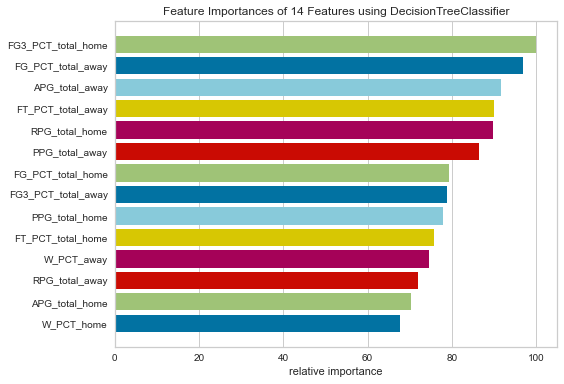

---------------------------------------------
i=29
REB:

Best decision tree accuracy ({'max_leaf_nodes': 1810, 'criterion': 'entropy'}): 0.50
              precision    recall  f1-score   support

           0       0.50      0.51      0.50      2119
           1       0.51      0.50      0.51      2195

    accuracy                           0.50      4314
   macro avg       0.50      0.50      0.50      4314
weighted avg       0.50      0.50      0.50      4314



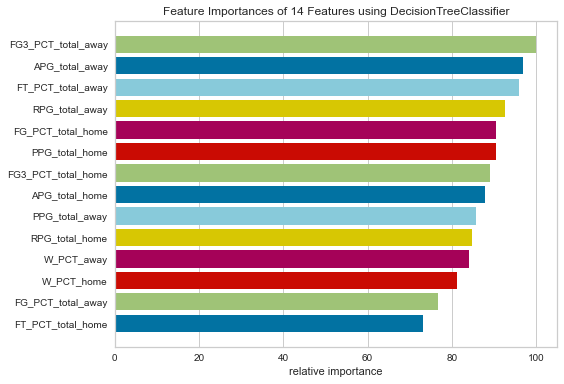

---------------------------------------------
Mean accuracy: 0.5008701895416094
Max accuracy: 0.5171534538711173
Min accuracy: 0.4885283893395133


In [30]:
# print_all_metrics_and_plot(
#     DecisionTreeClassifier(random_state=0),
#     X_train_dict,
#     X_test_dict,
#     {
#         'max_leaf_nodes': [*range(4,60)],
#         'criterion': ['gini', 'entropy'],
#     },
# )
print_cross_validated_and_plot(X_train_dicts, X_test_dicts, y_train_dicts, y_test_dicts, {
    'max_leaf_nodes': [*range(4,2000,2)],
    'criterion': ['gini', 'entropy'],
})

## Try prune max features

i=0
WINNER:

Best decision tree accuracy ({'max_features': 9, 'criterion': 'gini'}): 0.50
              precision    recall  f1-score   support

           0       0.51      0.50      0.51      1916
           1       0.50      0.50      0.50      1860

    accuracy                           0.50      3776
   macro avg       0.50      0.50      0.50      3776
weighted avg       0.50      0.50      0.50      3776



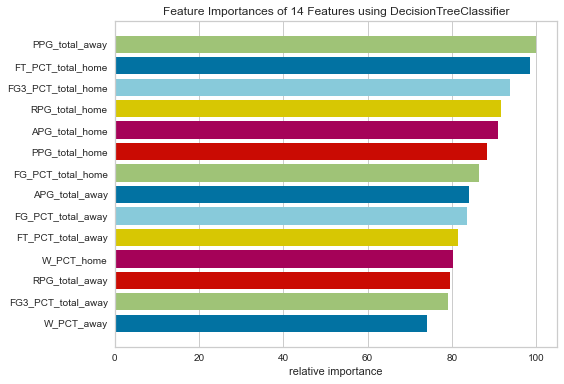

---------------------------------------------
i=1
WINNER:

Best decision tree accuracy ({'max_features': 1, 'criterion': 'gini'}): 0.51
              precision    recall  f1-score   support

           0       0.50      0.52      0.51      1860
           1       0.52      0.50      0.51      1915

    accuracy                           0.51      3775
   macro avg       0.51      0.51      0.51      3775
weighted avg       0.51      0.51      0.51      3775



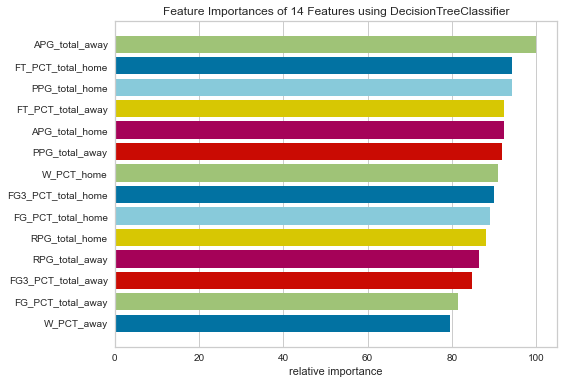

---------------------------------------------
i=2
WINNER:

Best decision tree accuracy ({'max_features': 1, 'criterion': 'gini'}): 0.50
              precision    recall  f1-score   support

           0       0.51      0.51      0.51      1913
           1       0.49      0.49      0.49      1862

    accuracy                           0.50      3775
   macro avg       0.50      0.50      0.50      3775
weighted avg       0.50      0.50      0.50      3775



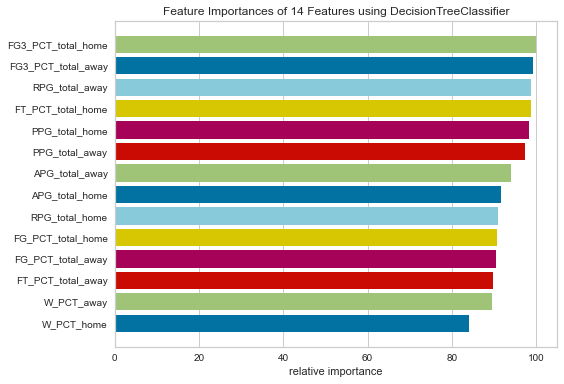

---------------------------------------------
i=3
WINNER:

Best decision tree accuracy ({'max_features': 1, 'criterion': 'gini'}): 0.50
              precision    recall  f1-score   support

           0       0.51      0.50      0.50      1904
           1       0.50      0.50      0.50      1871

    accuracy                           0.50      3775
   macro avg       0.50      0.50      0.50      3775
weighted avg       0.50      0.50      0.50      3775



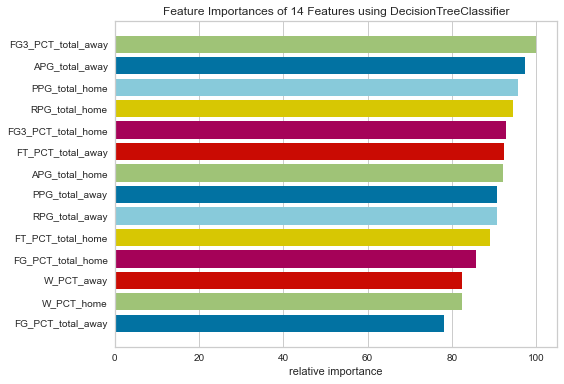

---------------------------------------------
i=4
WINNER:

Best decision tree accuracy ({'max_features': 2, 'criterion': 'entropy'}): 0.50
              precision    recall  f1-score   support

           0       0.49      0.51      0.50      1845
           1       0.51      0.49      0.50      1930

    accuracy                           0.50      3775
   macro avg       0.50      0.50      0.50      3775
weighted avg       0.50      0.50      0.50      3775



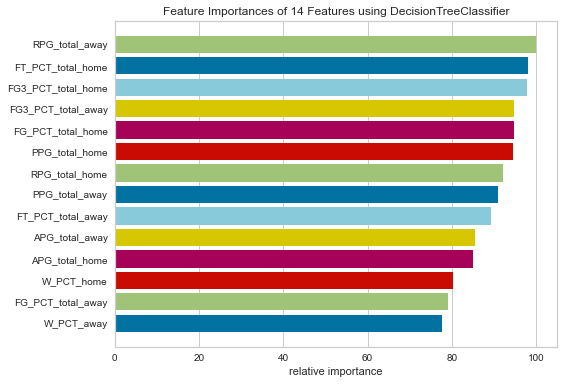

---------------------------------------------
Mean accuracy: 0.5028805842406555
Max accuracy: 0.5083443708609271
Min accuracy: 0.4990728476821192
i=5
FGP:

Best decision tree accuracy ({'max_features': 2, 'criterion': 'entropy'}): 0.51
              precision    recall  f1-score   support

           0       0.49      0.51      0.50      2005
           1       0.52      0.50      0.51      2146

    accuracy                           0.51      4151
   macro avg       0.51      0.51      0.51      4151
weighted avg       0.51      0.51      0.51      4151



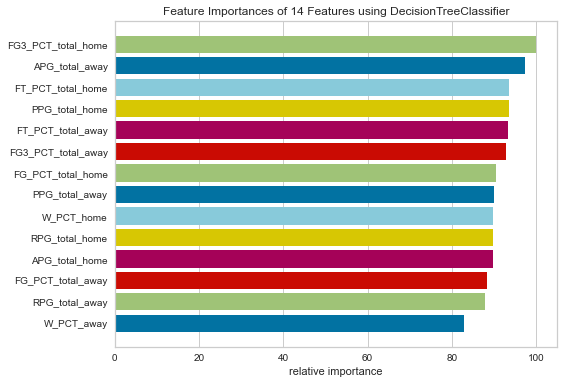

---------------------------------------------
i=6
FGP:

Best decision tree accuracy ({'max_features': 7, 'criterion': 'gini'}): 0.52
              precision    recall  f1-score   support

           0       0.53      0.51      0.52      2127
           1       0.50      0.53      0.51      2024

    accuracy                           0.52      4151
   macro avg       0.52      0.52      0.52      4151
weighted avg       0.52      0.52      0.52      4151



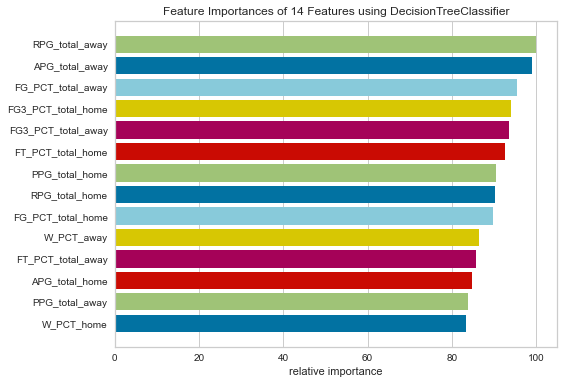

---------------------------------------------
i=7
FGP:

Best decision tree accuracy ({'max_features': 8, 'criterion': 'gini'}): 0.50
              precision    recall  f1-score   support

           0       0.51      0.51      0.51      2125
           1       0.49      0.49      0.49      2025

    accuracy                           0.50      4150
   macro avg       0.50      0.50      0.50      4150
weighted avg       0.50      0.50      0.50      4150



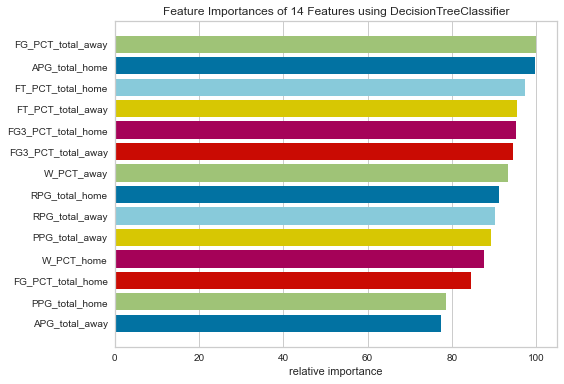

---------------------------------------------
i=8
FGP:

Best decision tree accuracy ({'max_features': 'sqrt', 'criterion': 'gini'}): 0.51
              precision    recall  f1-score   support

           0       0.51      0.50      0.51      2078
           1       0.51      0.52      0.51      2072

    accuracy                           0.51      4150
   macro avg       0.51      0.51      0.51      4150
weighted avg       0.51      0.51      0.51      4150



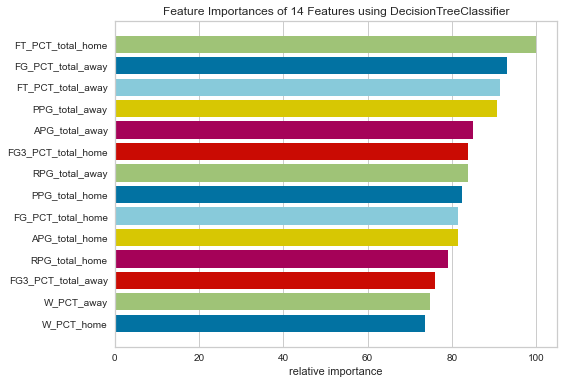

---------------------------------------------
i=9
FGP:

Best decision tree accuracy ({'max_features': 2, 'criterion': 'gini'}): 0.51
              precision    recall  f1-score   support

           0       0.50      0.50      0.50      2041
           1       0.52      0.52      0.52      2109

    accuracy                           0.51      4150
   macro avg       0.51      0.51      0.51      4150
weighted avg       0.51      0.51      0.51      4150



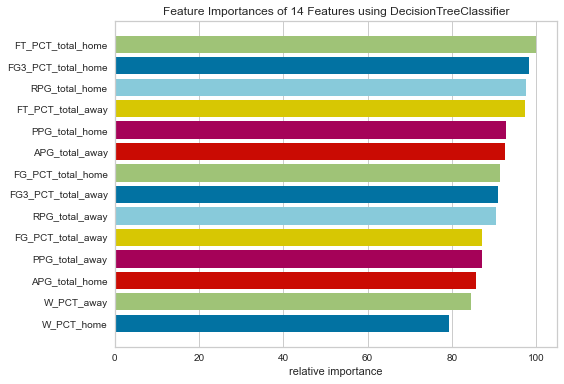

---------------------------------------------
Mean accuracy: 0.5079504430635091
Max accuracy: 0.5157793302818597
Min accuracy: 0.49903614457831325
i=10
FG3:

Best decision tree accuracy ({'max_features': 2, 'criterion': 'gini'}): 0.50
              precision    recall  f1-score   support

           0       0.50      0.50      0.50      2252
           1       0.51      0.51      0.51      2296

    accuracy                           0.50      4548
   macro avg       0.50      0.50      0.50      4548
weighted avg       0.50      0.50      0.50      4548



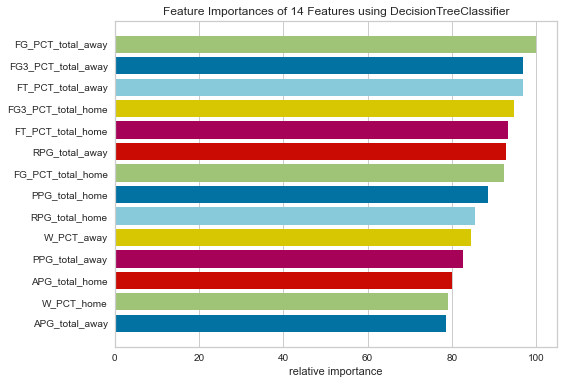

---------------------------------------------
i=11
FG3:

Best decision tree accuracy ({'max_features': 2, 'criterion': 'gini'}): 0.50
              precision    recall  f1-score   support

           0       0.50      0.49      0.50      2257
           1       0.51      0.51      0.51      2291

    accuracy                           0.50      4548
   macro avg       0.50      0.50      0.50      4548
weighted avg       0.50      0.50      0.50      4548



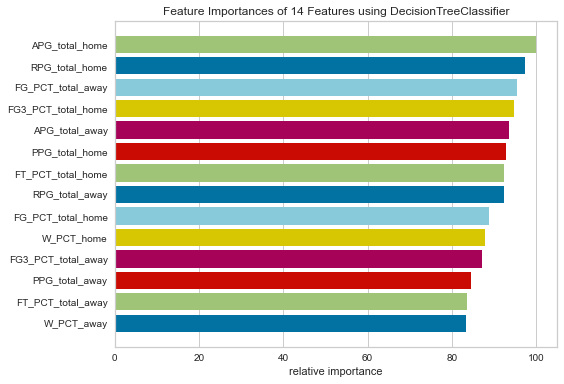

---------------------------------------------
i=12
FG3:

Best decision tree accuracy ({'max_features': 1, 'criterion': 'gini'}): 0.49
              precision    recall  f1-score   support

           0       0.50      0.49      0.49      2321
           1       0.48      0.49      0.48      2227

    accuracy                           0.49      4548
   macro avg       0.49      0.49      0.49      4548
weighted avg       0.49      0.49      0.49      4548



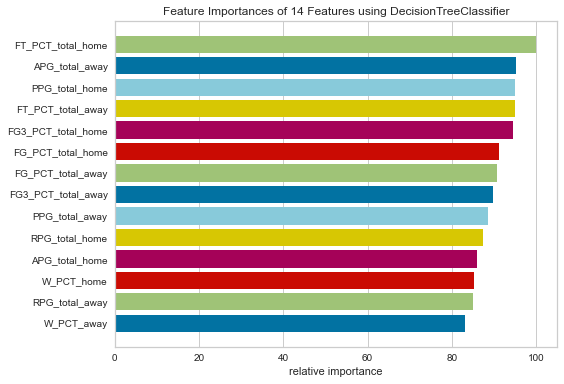

---------------------------------------------
i=13
FG3:

Best decision tree accuracy ({'max_features': 'log2', 'criterion': 'gini'}): 0.49
              precision    recall  f1-score   support

           0       0.50      0.49      0.50      2312
           1       0.49      0.49      0.49      2236

    accuracy                           0.49      4548
   macro avg       0.49      0.49      0.49      4548
weighted avg       0.49      0.49      0.49      4548



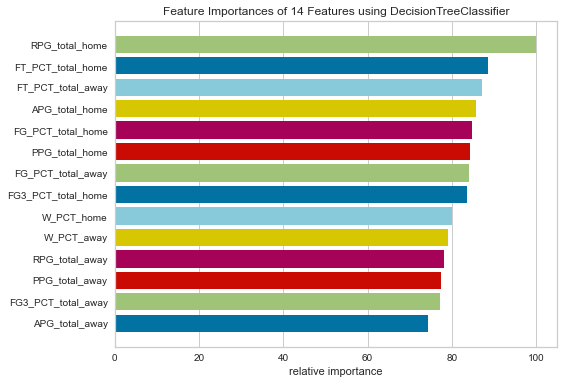

---------------------------------------------
i=14
FG3:

Best decision tree accuracy ({'max_features': 1, 'criterion': 'gini'}): 0.51
              precision    recall  f1-score   support

           0       0.50      0.51      0.50      2228
           1       0.52      0.50      0.51      2320

    accuracy                           0.51      4548
   macro avg       0.51      0.51      0.51      4548
weighted avg       0.51      0.51      0.51      4548



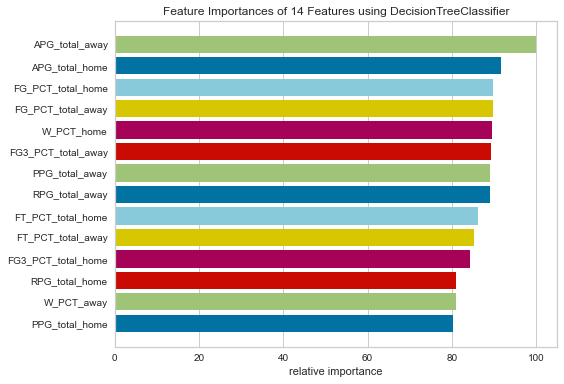

---------------------------------------------
Mean accuracy: 0.4962620932277924
Max accuracy: 0.503957783641161
Min accuracy: 0.48548812664907653
i=15
FT:

Best decision tree accuracy ({'max_features': 1, 'criterion': 'entropy'}): 0.51
              precision    recall  f1-score   support

           0       0.51      0.50      0.50      2255
           1       0.52      0.53      0.52      2322

    accuracy                           0.51      4577
   macro avg       0.51      0.51      0.51      4577
weighted avg       0.51      0.51      0.51      4577



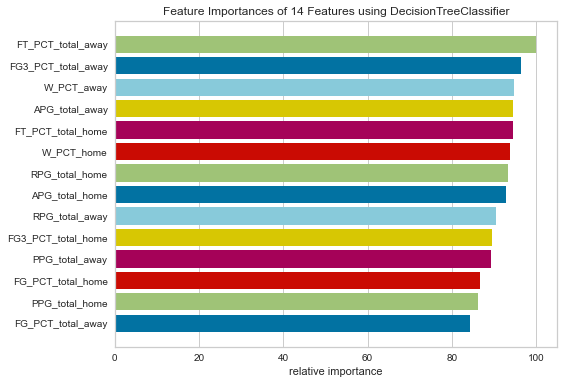

---------------------------------------------
i=16
FT:

Best decision tree accuracy ({'max_features': 2, 'criterion': 'gini'}): 0.50
              precision    recall  f1-score   support

           0       0.50      0.49      0.50      2292
           1       0.50      0.51      0.51      2285

    accuracy                           0.50      4577
   macro avg       0.50      0.50      0.50      4577
weighted avg       0.50      0.50      0.50      4577



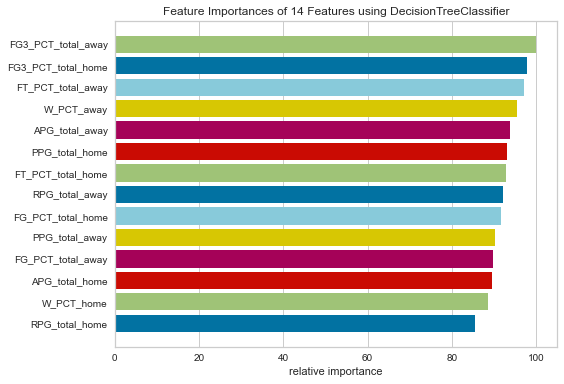

---------------------------------------------
i=17
FT:

Best decision tree accuracy ({'max_features': 1, 'criterion': 'entropy'}): 0.49
              precision    recall  f1-score   support

           0       0.50      0.49      0.49      2322
           1       0.48      0.49      0.49      2255

    accuracy                           0.49      4577
   macro avg       0.49      0.49      0.49      4577
weighted avg       0.49      0.49      0.49      4577



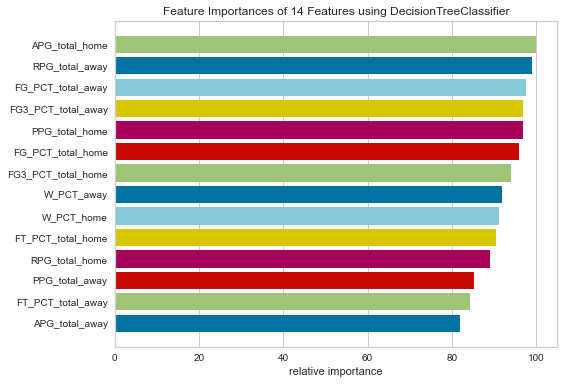

---------------------------------------------
i=18
FT:

Best decision tree accuracy ({'max_features': 1, 'criterion': 'gini'}): 0.51
              precision    recall  f1-score   support

           0       0.52      0.51      0.51      2330
           1       0.50      0.52      0.51      2247

    accuracy                           0.51      4577
   macro avg       0.51      0.51      0.51      4577
weighted avg       0.51      0.51      0.51      4577



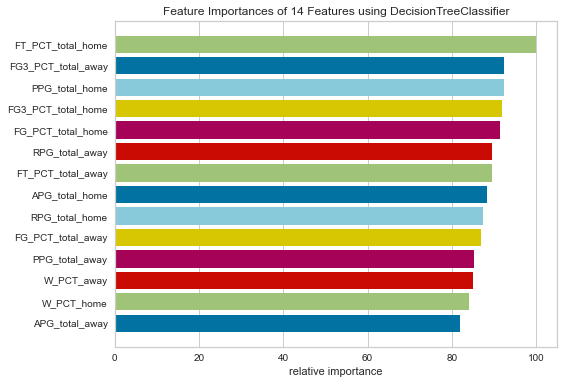

---------------------------------------------
i=19
FT:

Best decision tree accuracy ({'max_features': 1, 'criterion': 'gini'}): 0.52
              precision    recall  f1-score   support

           0       0.51      0.53      0.52      2243
           1       0.53      0.51      0.52      2333

    accuracy                           0.52      4576
   macro avg       0.52      0.52      0.52      4576
weighted avg       0.52      0.52      0.52      4576



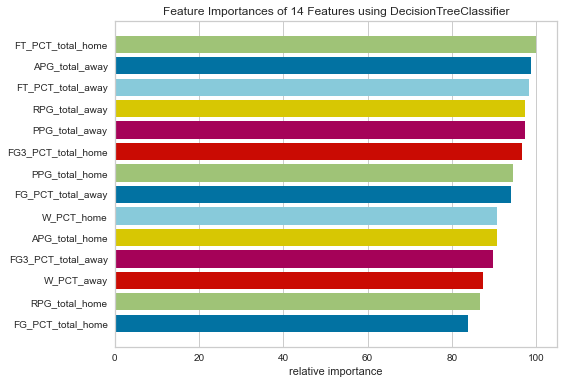

---------------------------------------------
Mean accuracy: 0.5049158837666594
Max accuracy: 0.5140922001310902
Min accuracy: 0.4911514092200131
i=20
AST:

Best decision tree accuracy ({'max_features': 2, 'criterion': 'gini'}): 0.50
              precision    recall  f1-score   support

           0       0.49      0.51      0.50      2048
           1       0.51      0.49      0.50      2116

    accuracy                           0.50      4164
   macro avg       0.50      0.50      0.50      4164
weighted avg       0.50      0.50      0.50      4164



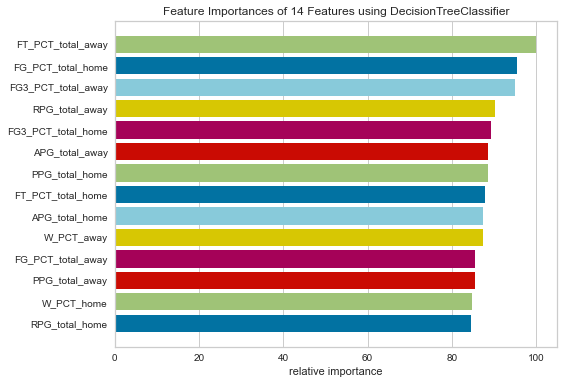

---------------------------------------------
i=21
AST:

Best decision tree accuracy ({'max_features': 2, 'criterion': 'gini'}): 0.50
              precision    recall  f1-score   support

           0       0.50      0.50      0.50      2096
           1       0.49      0.49      0.49      2068

    accuracy                           0.50      4164
   macro avg       0.50      0.50      0.50      4164
weighted avg       0.50      0.50      0.50      4164



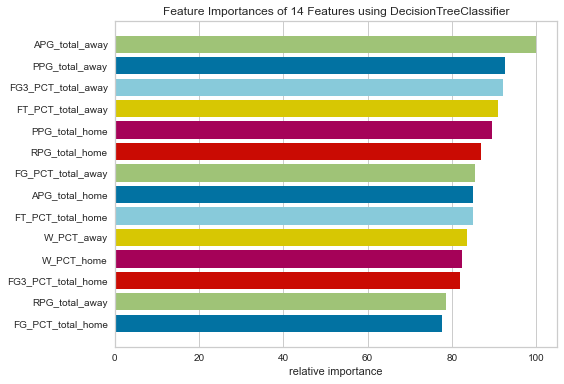

---------------------------------------------
i=22
AST:

Best decision tree accuracy ({'max_features': 1, 'criterion': 'gini'}): 0.50
              precision    recall  f1-score   support

           0       0.51      0.50      0.51      2132
           1       0.49      0.50      0.49      2032

    accuracy                           0.50      4164
   macro avg       0.50      0.50      0.50      4164
weighted avg       0.50      0.50      0.50      4164



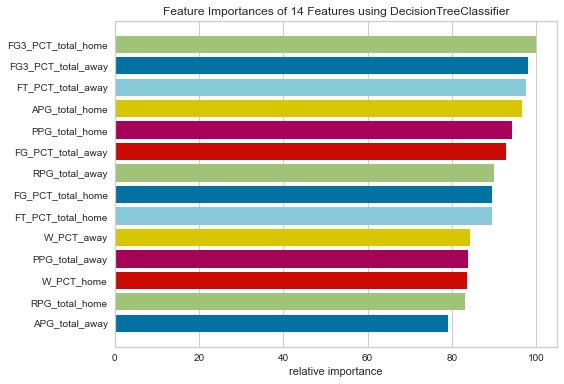

---------------------------------------------
i=23
AST:

Best decision tree accuracy ({'max_features': 1, 'criterion': 'gini'}): 0.50
              precision    recall  f1-score   support

           0       0.50      0.51      0.50      2087
           1       0.50      0.49      0.49      2076

    accuracy                           0.50      4163
   macro avg       0.50      0.50      0.50      4163
weighted avg       0.50      0.50      0.50      4163



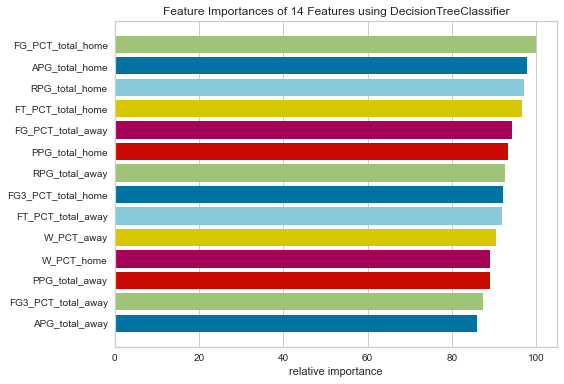

---------------------------------------------
i=24
AST:

Best decision tree accuracy ({'max_features': 4, 'criterion': 'gini'}): 0.50
              precision    recall  f1-score   support

           0       0.49      0.50      0.50      2046
           1       0.51      0.50      0.51      2117

    accuracy                           0.50      4163
   macro avg       0.50      0.50      0.50      4163
weighted avg       0.50      0.50      0.50      4163



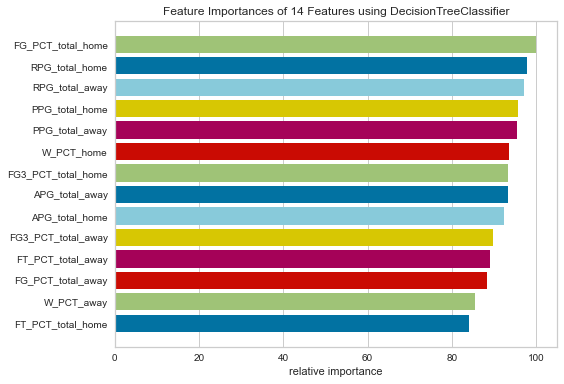

---------------------------------------------
Mean accuracy: 0.49876911855343364
Max accuracy: 0.5002401536983669
Min accuracy: 0.4978386167146974
i=25
REB:

Best decision tree accuracy ({'max_features': 1, 'criterion': 'entropy'}): 0.49
              precision    recall  f1-score   support

           0       0.49      0.49      0.49      2141
           1       0.49      0.49      0.49      2174

    accuracy                           0.49      4315
   macro avg       0.49      0.49      0.49      4315
weighted avg       0.49      0.49      0.49      4315



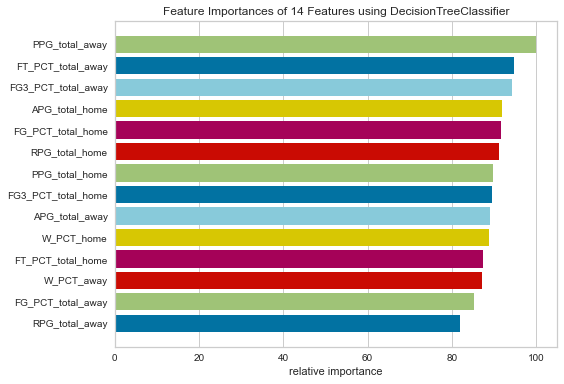

---------------------------------------------
i=26
REB:

Best decision tree accuracy ({'max_features': 1, 'criterion': 'entropy'}): 0.49
              precision    recall  f1-score   support

           0       0.49      0.48      0.49      2163
           1       0.49      0.50      0.49      2152

    accuracy                           0.49      4315
   macro avg       0.49      0.49      0.49      4315
weighted avg       0.49      0.49      0.49      4315



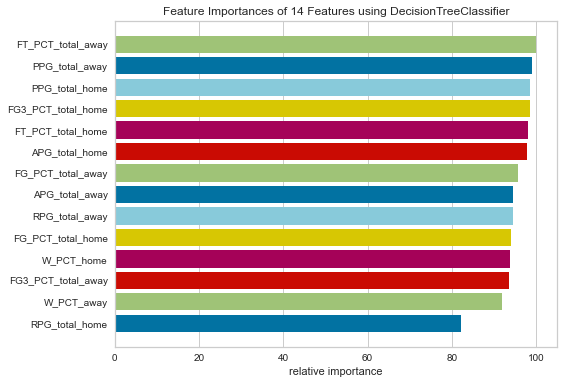

---------------------------------------------
i=27
REB:

Best decision tree accuracy ({'max_features': 11, 'criterion': 'gini'}): 0.50
              precision    recall  f1-score   support

           0       0.51      0.50      0.50      2181
           1       0.50      0.51      0.50      2133

    accuracy                           0.50      4314
   macro avg       0.50      0.50      0.50      4314
weighted avg       0.50      0.50      0.50      4314



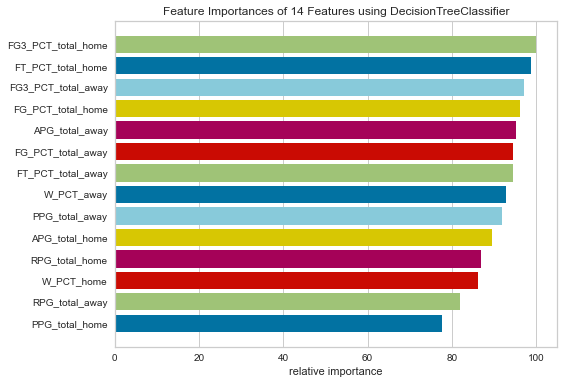

---------------------------------------------
i=28
REB:

Best decision tree accuracy ({'max_features': 1, 'criterion': 'gini'}): 0.50
              precision    recall  f1-score   support

           0       0.51      0.50      0.51      2182
           1       0.50      0.50      0.50      2132

    accuracy                           0.50      4314
   macro avg       0.50      0.50      0.50      4314
weighted avg       0.50      0.50      0.50      4314



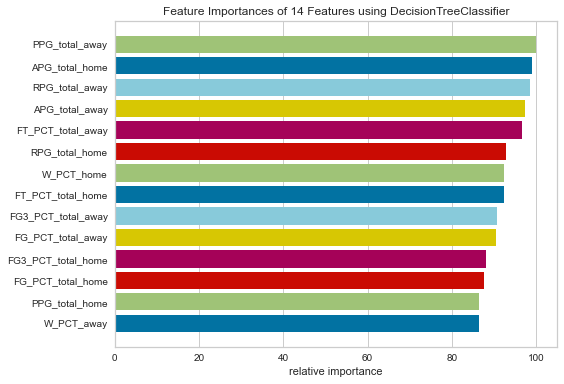

---------------------------------------------
i=29
REB:

Best decision tree accuracy ({'max_features': 1, 'criterion': 'entropy'}): 0.50
              precision    recall  f1-score   support

           0       0.49      0.50      0.49      2119
           1       0.50      0.49      0.50      2195

    accuracy                           0.50      4314
   macro avg       0.50      0.50      0.50      4314
weighted avg       0.50      0.50      0.50      4314



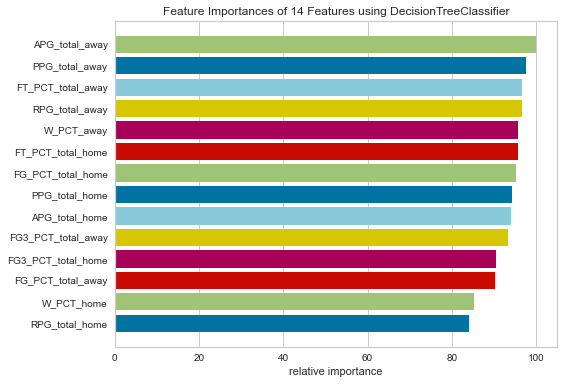

---------------------------------------------
Mean accuracy: 0.49588669781374184
Max accuracy: 0.5032452480296709
Min accuracy: 0.4892236384704519


In [31]:
# print_all_metrics_and_plot(
#     DecisionTreeClassifier(random_state=0),
#     X_train_dict,
#     X_test_dict,
#     {
#         'max_features': [*range(1,len(cumulative_stats_df.columns)//2+1), 'sqrt', 'log2', None],
#         'criterion': ['gini', 'entropy'],
#     },
# )
print_cross_validated_and_plot(X_train_dicts, X_test_dicts, y_train_dicts, y_test_dicts, {
    'max_features': [*range(1,len(cumulative_stats_df.columns)//2+1), 'sqrt', 'log2', None],
    'criterion': ['gini', 'entropy'],
})

## Try class weight balance

i=0


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


WINNER:

Best decision tree accuracy ({'criterion': 'gini', 'class_weight': 'balanced'}): 0.50
              precision    recall  f1-score   support

           0       0.51      0.50      0.51      1916
           1       0.50      0.51      0.50      1860

    accuracy                           0.50      3776
   macro avg       0.50      0.50      0.50      3776
weighted avg       0.50      0.50      0.50      3776



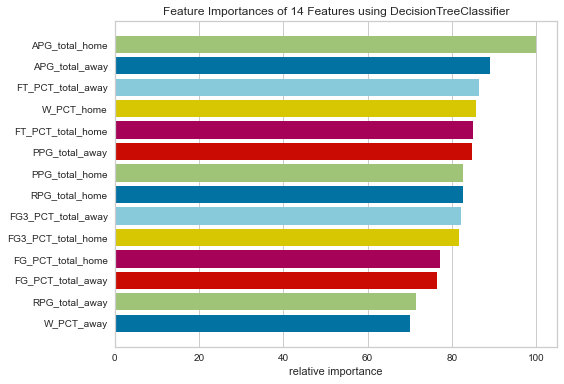

---------------------------------------------
i=1


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


WINNER:

Best decision tree accuracy ({'criterion': 'entropy', 'class_weight': 'balanced'}): 0.50
              precision    recall  f1-score   support

           0       0.49      0.50      0.50      1860
           1       0.51      0.49      0.50      1915

    accuracy                           0.50      3775
   macro avg       0.50      0.50      0.50      3775
weighted avg       0.50      0.50      0.50      3775



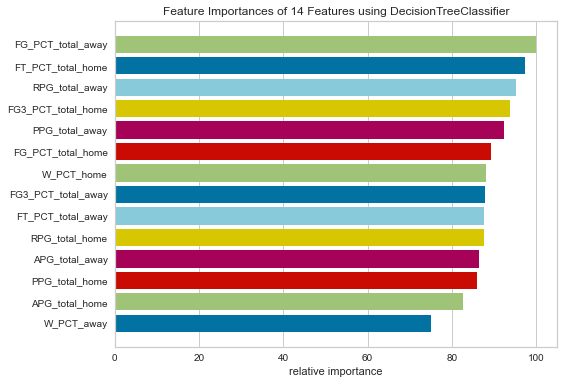

---------------------------------------------
i=2


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


WINNER:

Best decision tree accuracy ({'criterion': 'gini', 'class_weight': 'balanced'}): 0.49
              precision    recall  f1-score   support

           0       0.50      0.47      0.49      1913
           1       0.49      0.52      0.50      1862

    accuracy                           0.49      3775
   macro avg       0.50      0.50      0.49      3775
weighted avg       0.50      0.49      0.49      3775



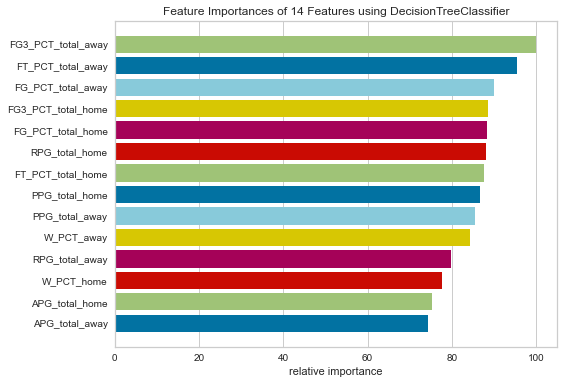

---------------------------------------------
i=3


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


WINNER:

Best decision tree accuracy ({'criterion': 'gini', 'class_weight': 'balanced'}): 0.51
              precision    recall  f1-score   support

           0       0.51      0.49      0.50      1904
           1       0.50      0.53      0.51      1871

    accuracy                           0.51      3775
   macro avg       0.51      0.51      0.51      3775
weighted avg       0.51      0.51      0.51      3775



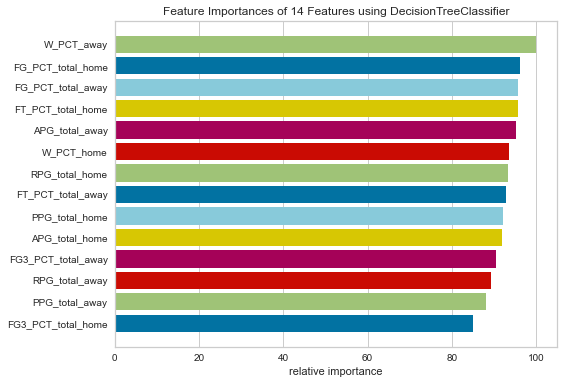

---------------------------------------------
i=4


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


WINNER:

Best decision tree accuracy ({'criterion': 'gini', 'class_weight': None}): 0.50
              precision    recall  f1-score   support

           0       0.49      0.52      0.50      1845
           1       0.51      0.49      0.50      1930

    accuracy                           0.50      3775
   macro avg       0.50      0.50      0.50      3775
weighted avg       0.50      0.50      0.50      3775



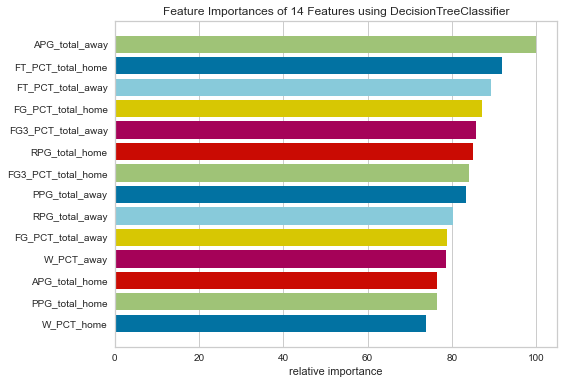

---------------------------------------------
Mean accuracy: 0.5005627209843978
Max accuracy: 0.5067549668874172
Min accuracy: 0.4948344370860927
i=5


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


FGP:

Best decision tree accuracy ({'criterion': 'gini', 'class_weight': 'balanced'}): 0.49
              precision    recall  f1-score   support

           0       0.48      0.50      0.49      2005
           1       0.51      0.49      0.50      2146

    accuracy                           0.49      4151
   macro avg       0.49      0.49      0.49      4151
weighted avg       0.49      0.49      0.49      4151



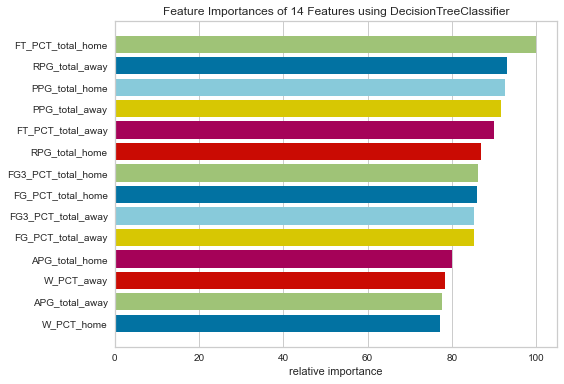

---------------------------------------------
i=6


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


FGP:

Best decision tree accuracy ({'criterion': 'gini', 'class_weight': 'balanced'}): 0.50
              precision    recall  f1-score   support

           0       0.51      0.50      0.50      2127
           1       0.49      0.51      0.50      2024

    accuracy                           0.50      4151
   macro avg       0.50      0.50      0.50      4151
weighted avg       0.50      0.50      0.50      4151



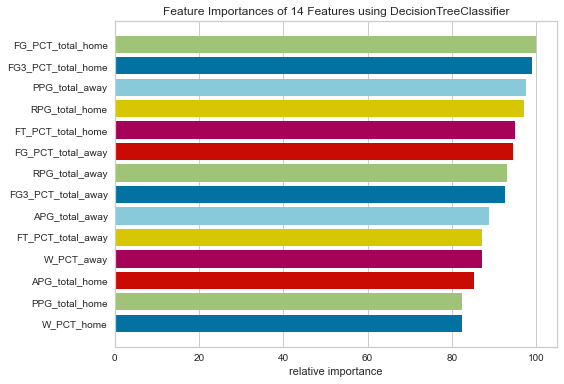

---------------------------------------------
i=7


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


FGP:

Best decision tree accuracy ({'criterion': 'entropy', 'class_weight': None}): 0.50
              precision    recall  f1-score   support

           0       0.51      0.49      0.50      2125
           1       0.48      0.51      0.49      2025

    accuracy                           0.50      4150
   macro avg       0.50      0.50      0.50      4150
weighted avg       0.50      0.50      0.50      4150



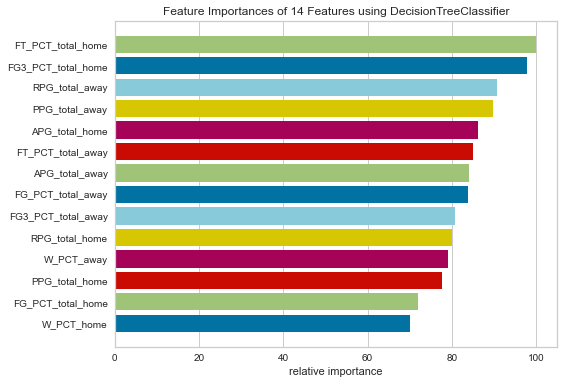

---------------------------------------------
i=8


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


FGP:

Best decision tree accuracy ({'criterion': 'entropy', 'class_weight': 'balanced'}): 0.51
              precision    recall  f1-score   support

           0       0.51      0.52      0.52      2078
           1       0.51      0.49      0.50      2072

    accuracy                           0.51      4150
   macro avg       0.51      0.51      0.51      4150
weighted avg       0.51      0.51      0.51      4150



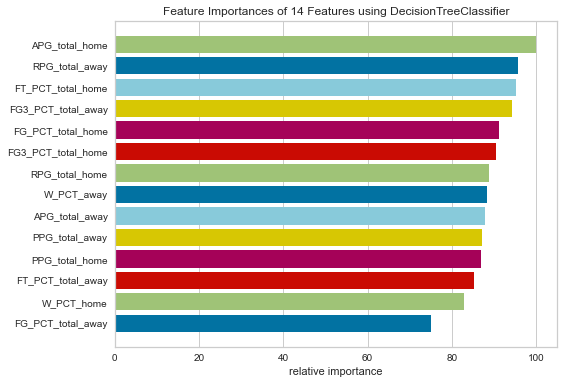

---------------------------------------------
i=9


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


FGP:

Best decision tree accuracy ({'criterion': 'gini', 'class_weight': 'balanced'}): 0.49
              precision    recall  f1-score   support

           0       0.48      0.50      0.49      2041
           1       0.50      0.49      0.49      2109

    accuracy                           0.49      4150
   macro avg       0.49      0.49      0.49      4150
weighted avg       0.49      0.49      0.49      4150



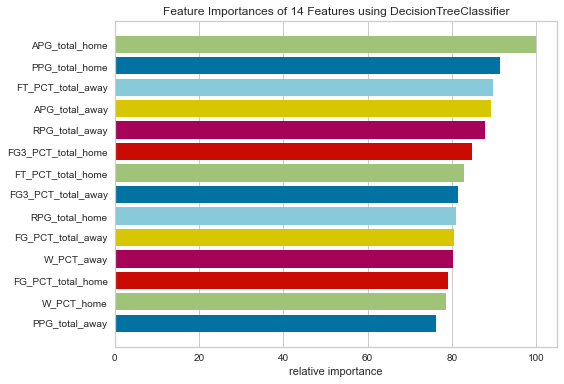

---------------------------------------------
Mean accuracy: 0.49987975027065623
Max accuracy: 0.5079518072289156
Min accuracy: 0.49409780775716694
i=10


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


FG3:

Best decision tree accuracy ({'criterion': 'gini', 'class_weight': 'balanced'}): 0.50
              precision    recall  f1-score   support

           0       0.50      0.52      0.51      2252
           1       0.51      0.49      0.50      2296

    accuracy                           0.50      4548
   macro avg       0.50      0.50      0.50      4548
weighted avg       0.50      0.50      0.50      4548



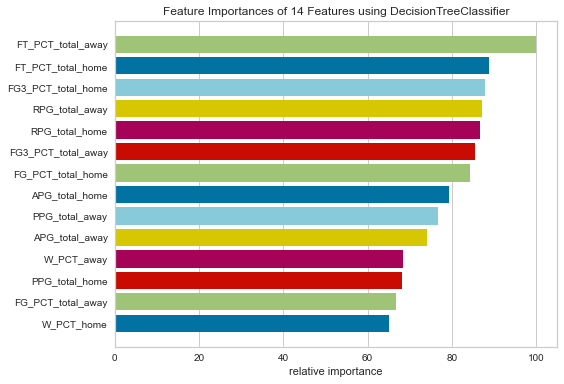

---------------------------------------------
i=11


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


FG3:

Best decision tree accuracy ({'criterion': 'gini', 'class_weight': None}): 0.50
              precision    recall  f1-score   support

           0       0.49      0.49      0.49      2257
           1       0.50      0.50      0.50      2291

    accuracy                           0.50      4548
   macro avg       0.50      0.50      0.50      4548
weighted avg       0.50      0.50      0.50      4548



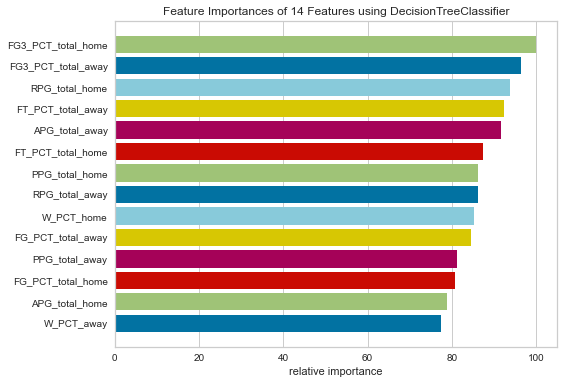

---------------------------------------------
i=12


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


FG3:

Best decision tree accuracy ({'criterion': 'gini', 'class_weight': 'balanced'}): 0.51
              precision    recall  f1-score   support

           0       0.52      0.50      0.51      2321
           1       0.50      0.53      0.51      2227

    accuracy                           0.51      4548
   macro avg       0.51      0.51      0.51      4548
weighted avg       0.51      0.51      0.51      4548



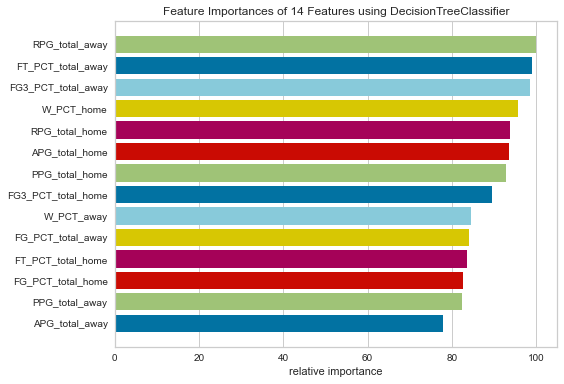

---------------------------------------------
i=13


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


FG3:

Best decision tree accuracy ({'criterion': 'gini', 'class_weight': None}): 0.48
              precision    recall  f1-score   support

           0       0.49      0.48      0.48      2312
           1       0.47      0.48      0.48      2236

    accuracy                           0.48      4548
   macro avg       0.48      0.48      0.48      4548
weighted avg       0.48      0.48      0.48      4548



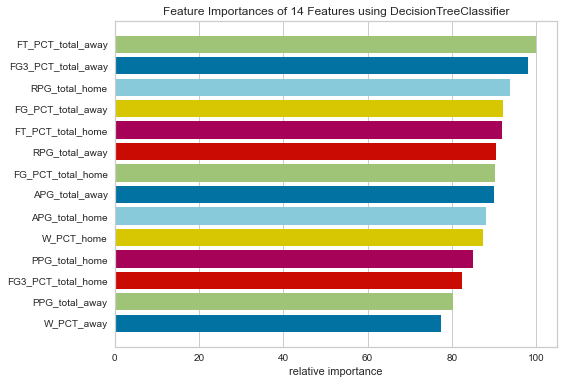

---------------------------------------------
i=14


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


FG3:

Best decision tree accuracy ({'criterion': 'gini', 'class_weight': 'balanced'}): 0.50
              precision    recall  f1-score   support

           0       0.49      0.50      0.50      2228
           1       0.51      0.51      0.51      2320

    accuracy                           0.50      4548
   macro avg       0.50      0.50      0.50      4548
weighted avg       0.50      0.50      0.50      4548



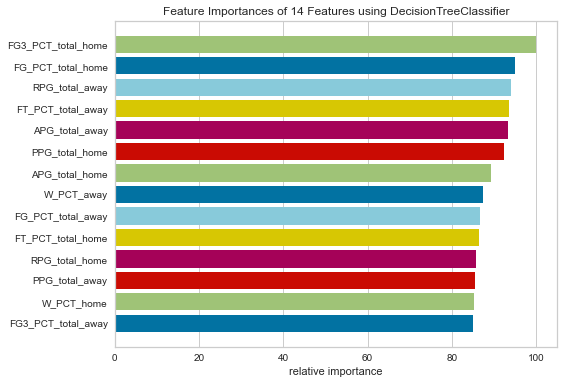

---------------------------------------------
Mean accuracy: 0.49703166226912926
Max accuracy: 0.5109938434476693
Min accuracy: 0.4793315743183817
i=15


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


FT:

Best decision tree accuracy ({'criterion': 'entropy', 'class_weight': 'balanced'}): 0.48
              precision    recall  f1-score   support

           0       0.48      0.48      0.48      2255
           1       0.49      0.48      0.49      2322

    accuracy                           0.48      4577
   macro avg       0.48      0.48      0.48      4577
weighted avg       0.48      0.48      0.48      4577



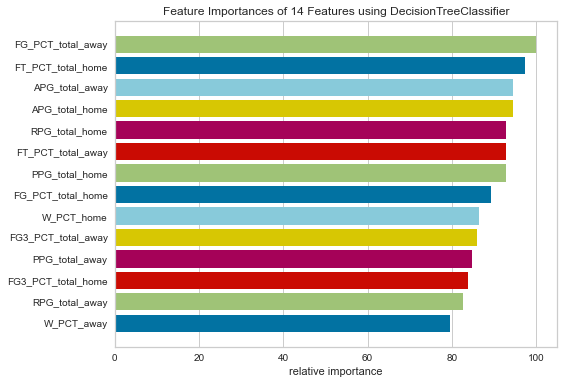

---------------------------------------------
i=16


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


FT:

Best decision tree accuracy ({'criterion': 'gini', 'class_weight': None}): 0.50
              precision    recall  f1-score   support

           0       0.50      0.51      0.50      2292
           1       0.50      0.50      0.50      2285

    accuracy                           0.50      4577
   macro avg       0.50      0.50      0.50      4577
weighted avg       0.50      0.50      0.50      4577



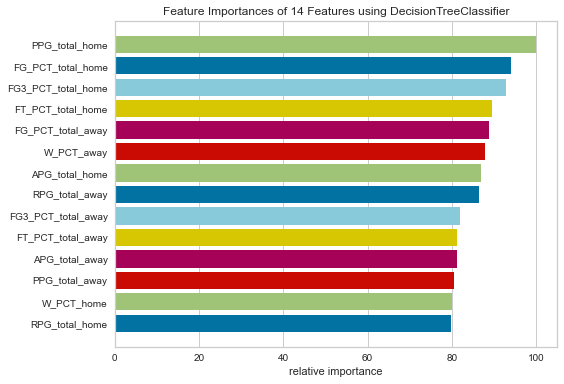

---------------------------------------------
i=17


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


FT:

Best decision tree accuracy ({'criterion': 'entropy', 'class_weight': None}): 0.51
              precision    recall  f1-score   support

           0       0.52      0.51      0.51      2322
           1       0.50      0.51      0.51      2255

    accuracy                           0.51      4577
   macro avg       0.51      0.51      0.51      4577
weighted avg       0.51      0.51      0.51      4577



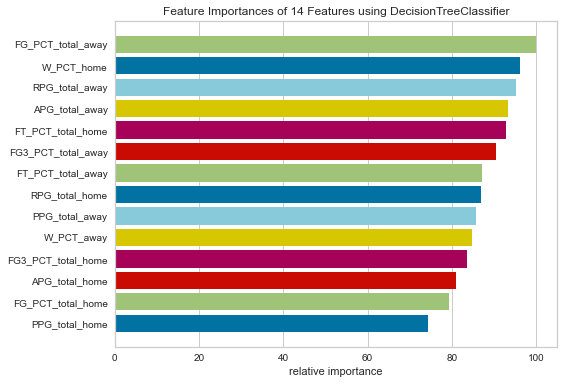

---------------------------------------------
i=18


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


FT:

Best decision tree accuracy ({'criterion': 'entropy', 'class_weight': None}): 0.50
              precision    recall  f1-score   support

           0       0.51      0.48      0.50      2330
           1       0.49      0.51      0.50      2247

    accuracy                           0.50      4577
   macro avg       0.50      0.50      0.50      4577
weighted avg       0.50      0.50      0.50      4577



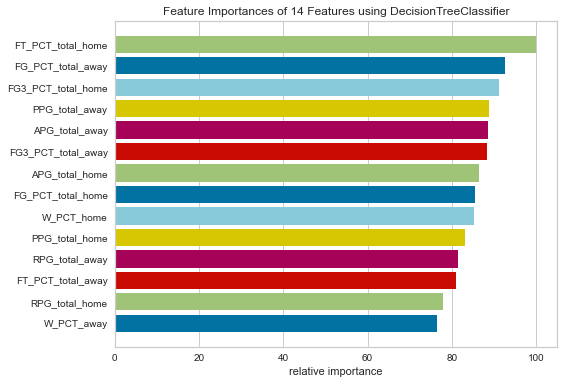

---------------------------------------------
i=19


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


FT:

Best decision tree accuracy ({'criterion': 'gini', 'class_weight': None}): 0.51
              precision    recall  f1-score   support

           0       0.50      0.52      0.51      2243
           1       0.52      0.51      0.51      2333

    accuracy                           0.51      4576
   macro avg       0.51      0.51      0.51      4576
weighted avg       0.51      0.51      0.51      4576



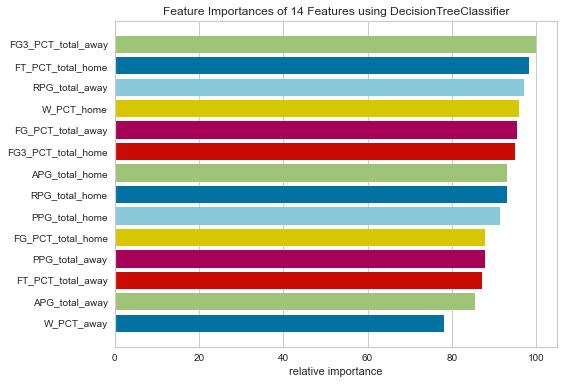

---------------------------------------------
Mean accuracy: 0.49792440463185494
Max accuracy: 0.5086301070570243
Min accuracy: 0.4832859951933581
i=20


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


AST:

Best decision tree accuracy ({'criterion': 'entropy', 'class_weight': 'balanced'}): 0.50
              precision    recall  f1-score   support

           0       0.49      0.52      0.51      2048
           1       0.51      0.49      0.50      2116

    accuracy                           0.50      4164
   macro avg       0.50      0.50      0.50      4164
weighted avg       0.50      0.50      0.50      4164



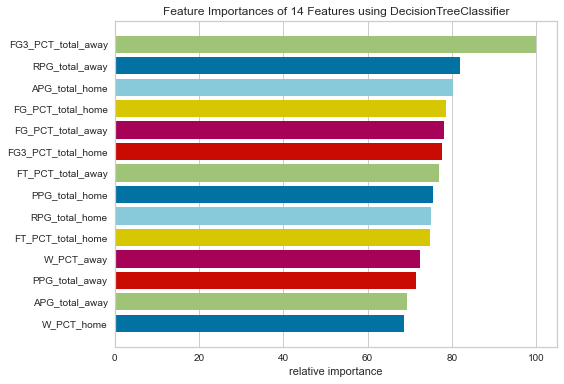

---------------------------------------------
i=21


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


AST:

Best decision tree accuracy ({'criterion': 'entropy', 'class_weight': None}): 0.49
              precision    recall  f1-score   support

           0       0.50      0.50      0.50      2096
           1       0.49      0.49      0.49      2068

    accuracy                           0.49      4164
   macro avg       0.49      0.49      0.49      4164
weighted avg       0.49      0.49      0.49      4164



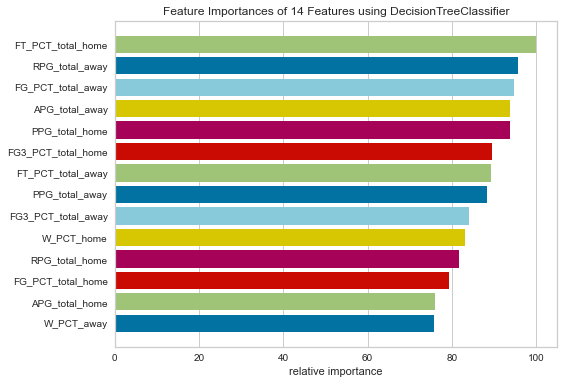

---------------------------------------------
i=22


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


AST:

Best decision tree accuracy ({'criterion': 'gini', 'class_weight': 'balanced'}): 0.51
              precision    recall  f1-score   support

           0       0.52      0.51      0.52      2132
           1       0.50      0.51      0.50      2032

    accuracy                           0.51      4164
   macro avg       0.51      0.51      0.51      4164
weighted avg       0.51      0.51      0.51      4164



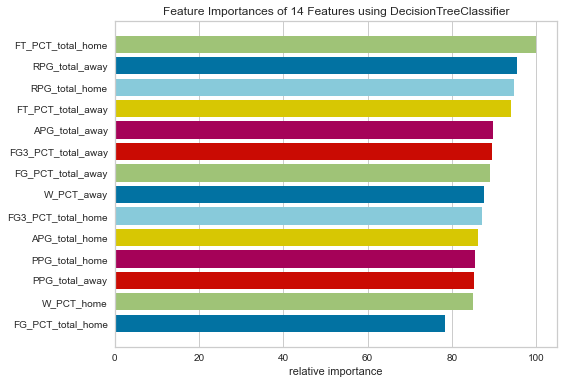

---------------------------------------------
i=23


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


AST:

Best decision tree accuracy ({'criterion': 'entropy', 'class_weight': 'balanced'}): 0.50
              precision    recall  f1-score   support

           0       0.51      0.52      0.51      2087
           1       0.50      0.49      0.49      2076

    accuracy                           0.50      4163
   macro avg       0.50      0.50      0.50      4163
weighted avg       0.50      0.50      0.50      4163



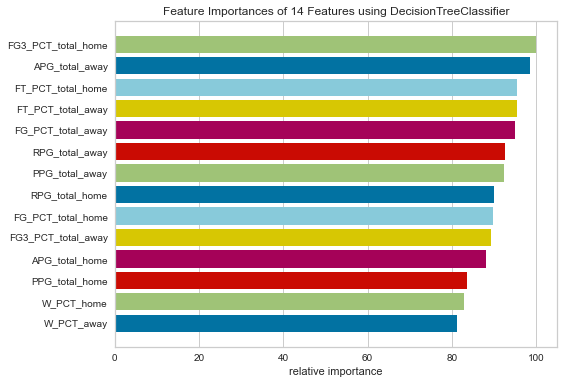

---------------------------------------------
i=24


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


AST:

Best decision tree accuracy ({'criterion': 'entropy', 'class_weight': None}): 0.51
              precision    recall  f1-score   support

           0       0.50      0.51      0.51      2046
           1       0.52      0.50      0.51      2117

    accuracy                           0.51      4163
   macro avg       0.51      0.51      0.51      4163
weighted avg       0.51      0.51      0.51      4163



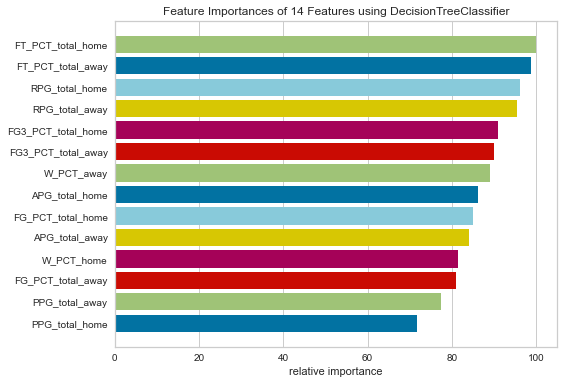

---------------------------------------------
Mean accuracy: 0.5026719766997263
Max accuracy: 0.5093659942363112
Min accuracy: 0.4942363112391931
i=25


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


REB:

Best decision tree accuracy ({'criterion': 'gini', 'class_weight': 'balanced'}): 0.49
              precision    recall  f1-score   support

           0       0.49      0.50      0.50      2141
           1       0.50      0.48      0.49      2174

    accuracy                           0.49      4315
   macro avg       0.49      0.49      0.49      4315
weighted avg       0.49      0.49      0.49      4315



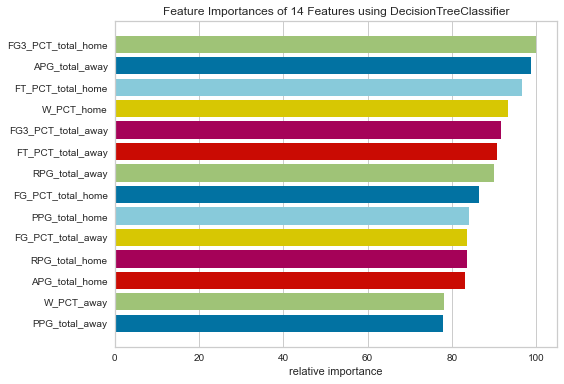

---------------------------------------------
i=26


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


REB:

Best decision tree accuracy ({'criterion': 'entropy', 'class_weight': 'balanced'}): 0.49
              precision    recall  f1-score   support

           0       0.49      0.49      0.49      2163
           1       0.48      0.48      0.48      2152

    accuracy                           0.49      4315
   macro avg       0.49      0.49      0.49      4315
weighted avg       0.49      0.49      0.49      4315



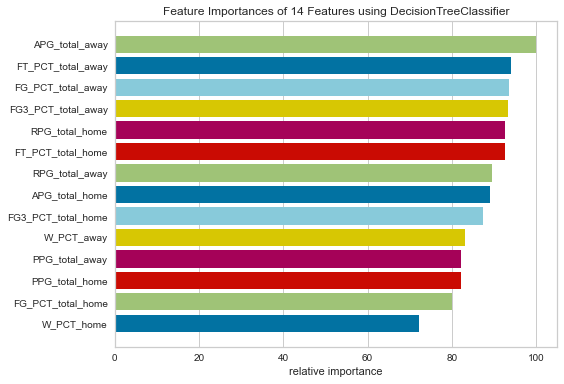

---------------------------------------------
i=27


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


REB:

Best decision tree accuracy ({'criterion': 'gini', 'class_weight': None}): 0.49
              precision    recall  f1-score   support

           0       0.49      0.49      0.49      2181
           1       0.48      0.48      0.48      2133

    accuracy                           0.49      4314
   macro avg       0.49      0.49      0.49      4314
weighted avg       0.49      0.49      0.49      4314



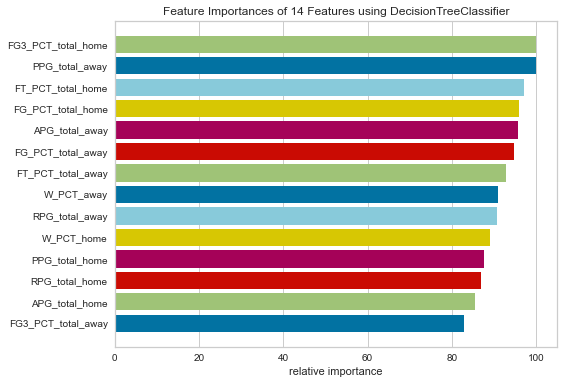

---------------------------------------------
i=28


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


REB:

Best decision tree accuracy ({'criterion': 'entropy', 'class_weight': None}): 0.52
              precision    recall  f1-score   support

           0       0.52      0.52      0.52      2182
           1       0.51      0.51      0.51      2132

    accuracy                           0.52      4314
   macro avg       0.52      0.52      0.52      4314
weighted avg       0.52      0.52      0.52      4314



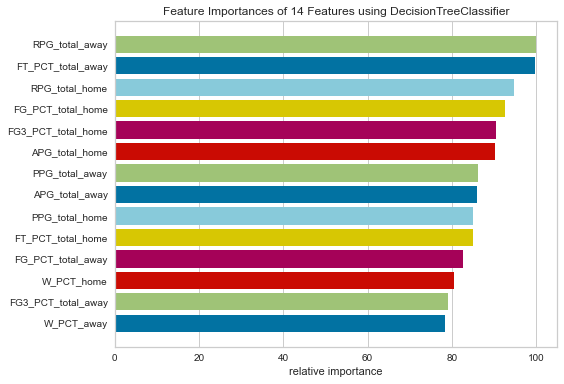

---------------------------------------------
i=29


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


REB:

Best decision tree accuracy ({'criterion': 'entropy', 'class_weight': None}): 0.49
              precision    recall  f1-score   support

           0       0.49      0.49      0.49      2119
           1       0.50      0.50      0.50      2195

    accuracy                           0.49      4314
   macro avg       0.49      0.49      0.49      4314
weighted avg       0.49      0.49      0.49      4314



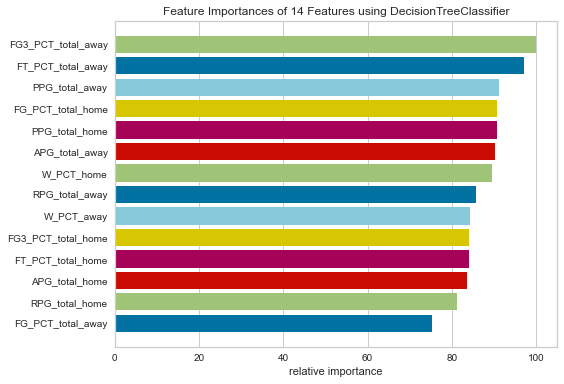

---------------------------------------------
Mean accuracy: 0.49565493467333444
Max accuracy: 0.5155308298562818
Min accuracy: 0.4852838933951333


In [32]:
# print_all_metrics_and_plot(
#     DecisionTreeClassifier(random_state=0),
#     X_train_dict,
#     X_test_dict,
#     {
#         'class_weight': ['balanced', None],
#         'criterion': ['gini', 'entropy'],
#     },
# )
print_cross_validated_and_plot(X_train_dicts, X_test_dicts, y_train_dicts, y_test_dicts, {
    'class_weight': ['balanced', None],
    'criterion': ['gini', 'entropy'],
})

## Try w/ diffrent random_state

In [33]:
print_all_metrics_and_plot(
    DecisionTreeClassifier(random_state=1234),
    X_train_dict,
    X_test_dict,
    {
        'max_depth': [*range(4,35)],
        'criterion': ['gini', 'entropy'],
    },
)

TypeError: print_all_metrics_and_plot() missing 2 required positional arguments: 'y_test_dict' and 'grid_cv_params'

In [ ]:
print_all_metrics_and_plot(
    DecisionTreeClassifier(random_state=76634),
    X_train_dict,
    X_test_dict,
    {
        'max_leaf_nodes': [*range(4,60)],
        'criterion': ['gini', 'entropy'],
    },
)